In [6]:
import os
from pytomography.io.SPECT import simind
from pytomography.projectors import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.transforms import GaussianFilter
import torch
from torch import poisson
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import cv2
%matplotlib inline

def read_nii_vol(target_filename):
    img = nib.load(target_filename)
    VOL = np.array(img.dataobj)
    return VOL


def save_as_Nifti(VOL, save_Dir, filename):
    VOL_32f = np.array(VOL, dtype=np.float32)
    affine = np.eye(4)
    VOL_nifti_file = nib.Nifti1Image(VOL_32f, affine)
    nib.save(VOL_nifti_file, os.path.join(save_Dir, filename))


def normalize(slice):
    min_val = np.min(np.min(slice))
    max_val = np.max(np.max(slice))
    range = max_val - min_val
    normalized_slice = (slice[:] - min_val) / range
    return normalized_slice
            
            
def dice_score(gt_mask, pred_mask):
    intersection = np.sum(gt_mask * pred_mask)
    gt_sum = np.sum(gt_mask)
    pred_sum = np.sum(pred_mask)
    dice = (2. * intersection) / (gt_sum + pred_sum + 0.000001)
    return dice

patient id: PSMA-01-013


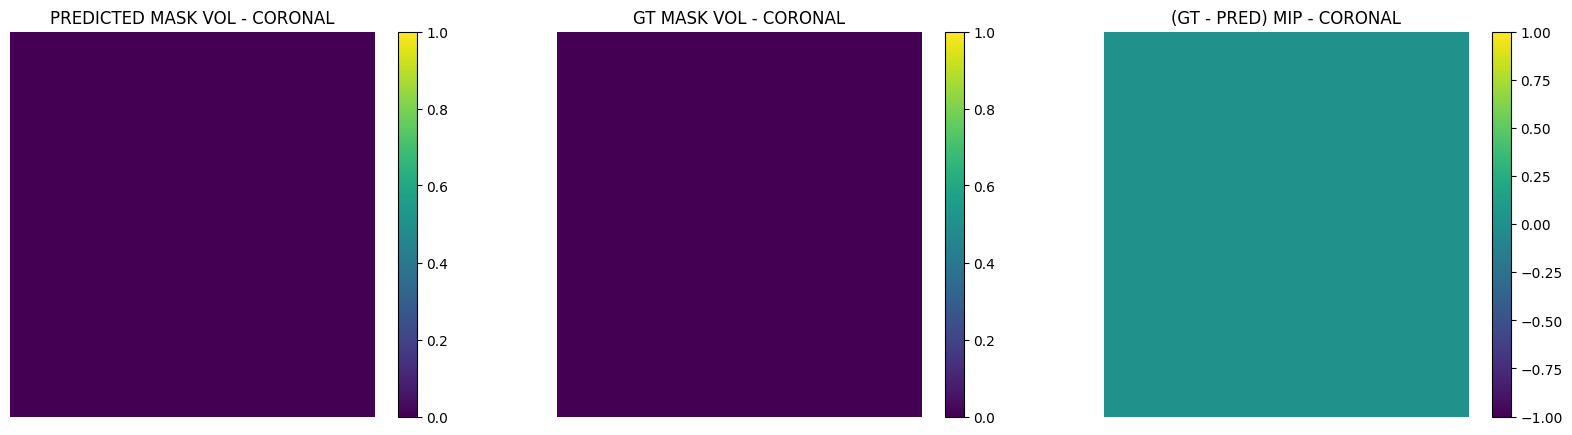

patient id: PSMA-01-013


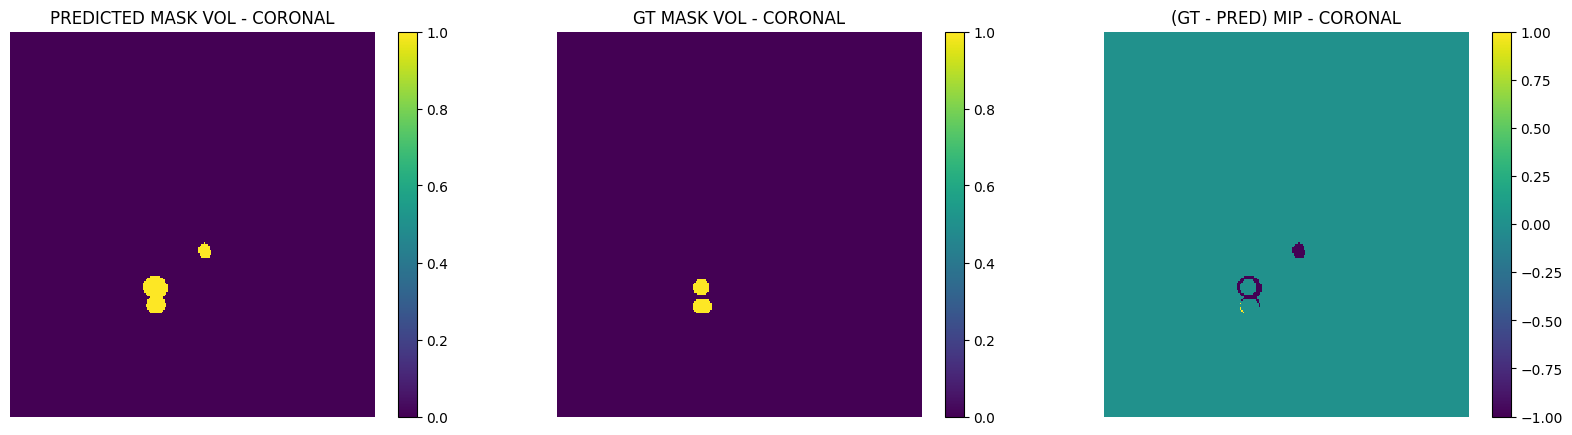

patient id: PSMA-01-032


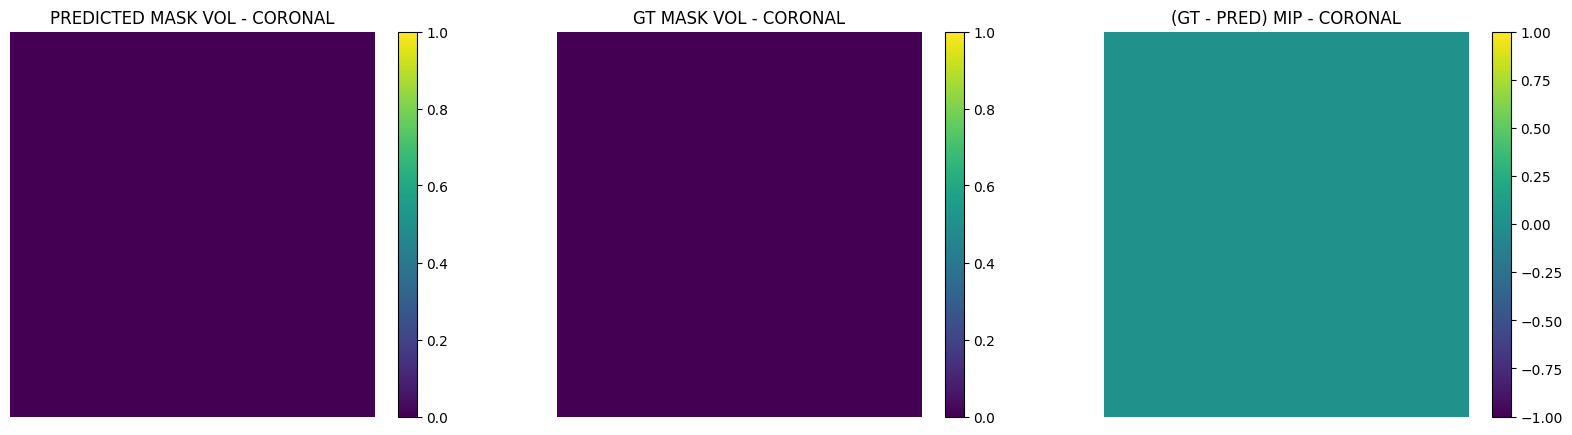

patient id: PSMA-01-032


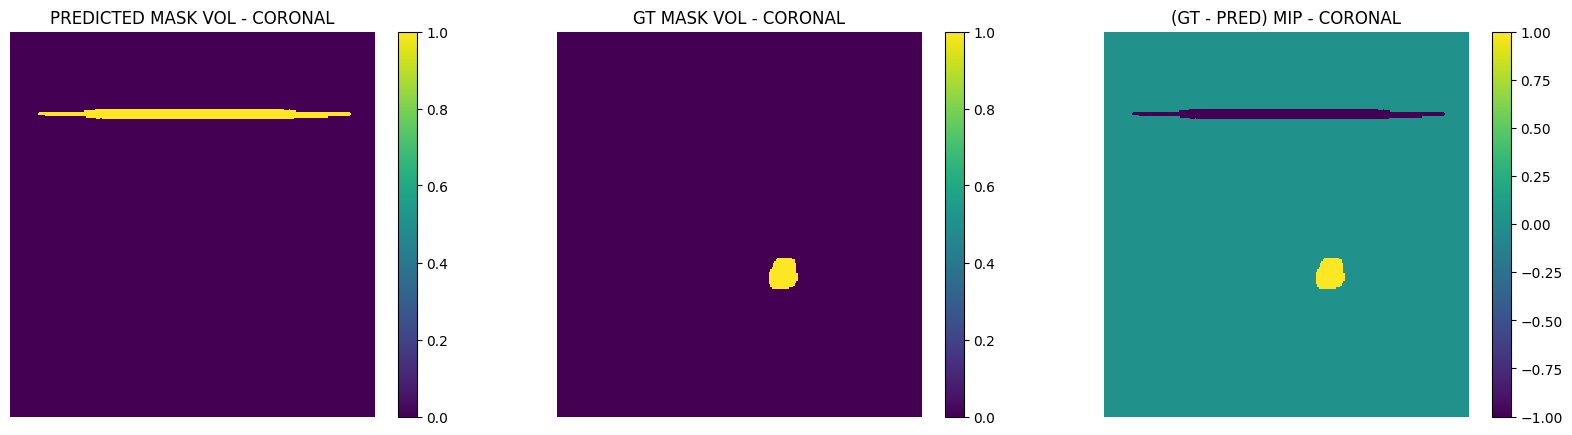

patient id: PSMA-01-035


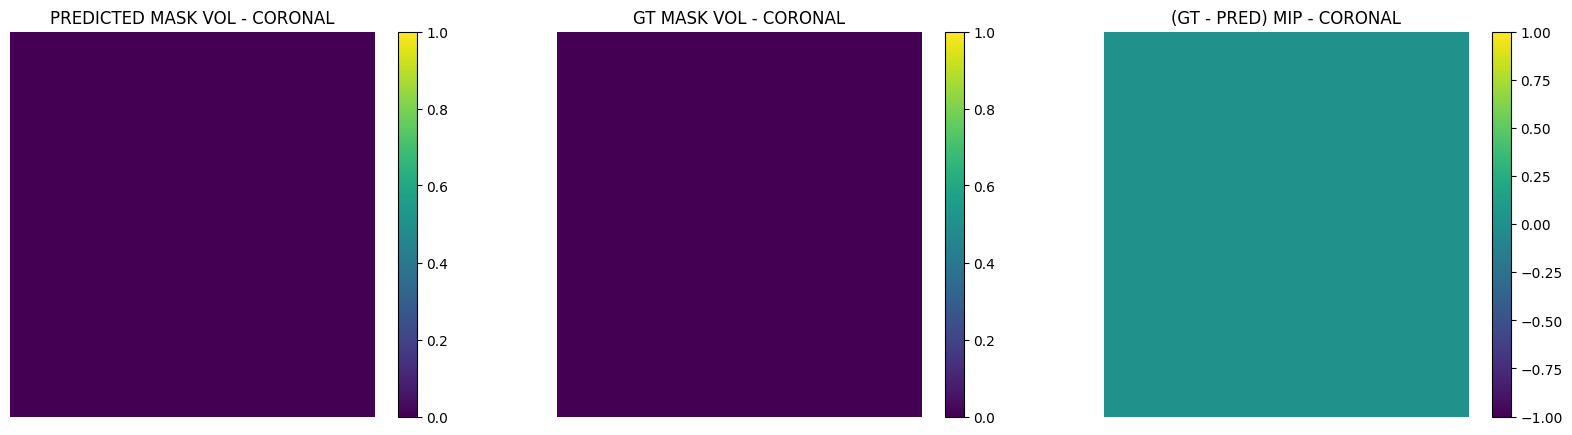

patient id: PSMA-01-035


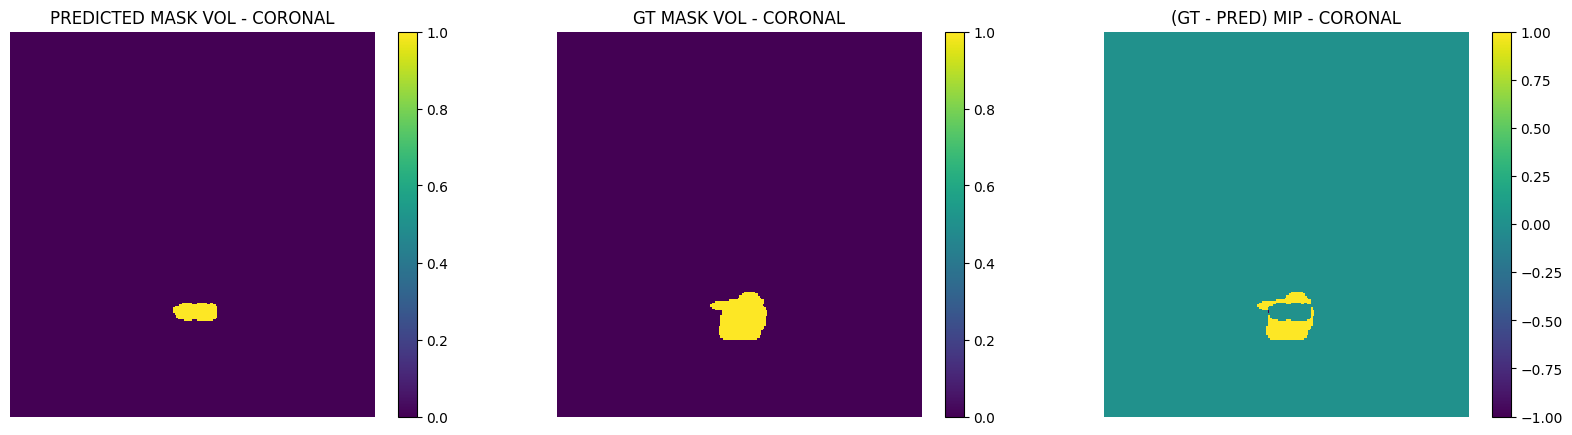

patient id: PSMA-01-042


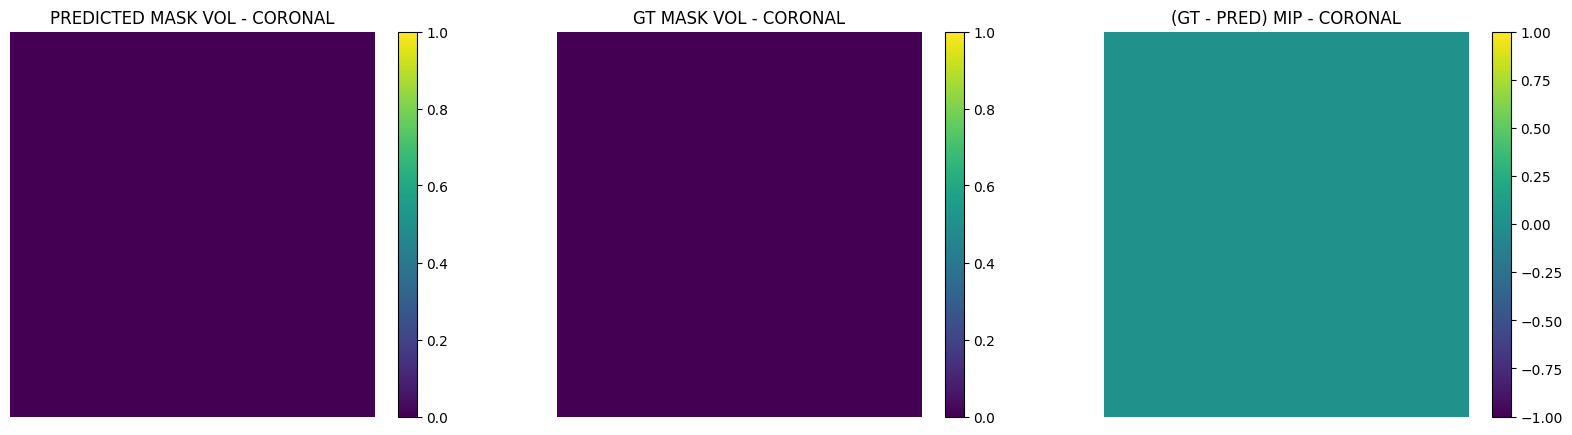

patient id: PSMA-01-042


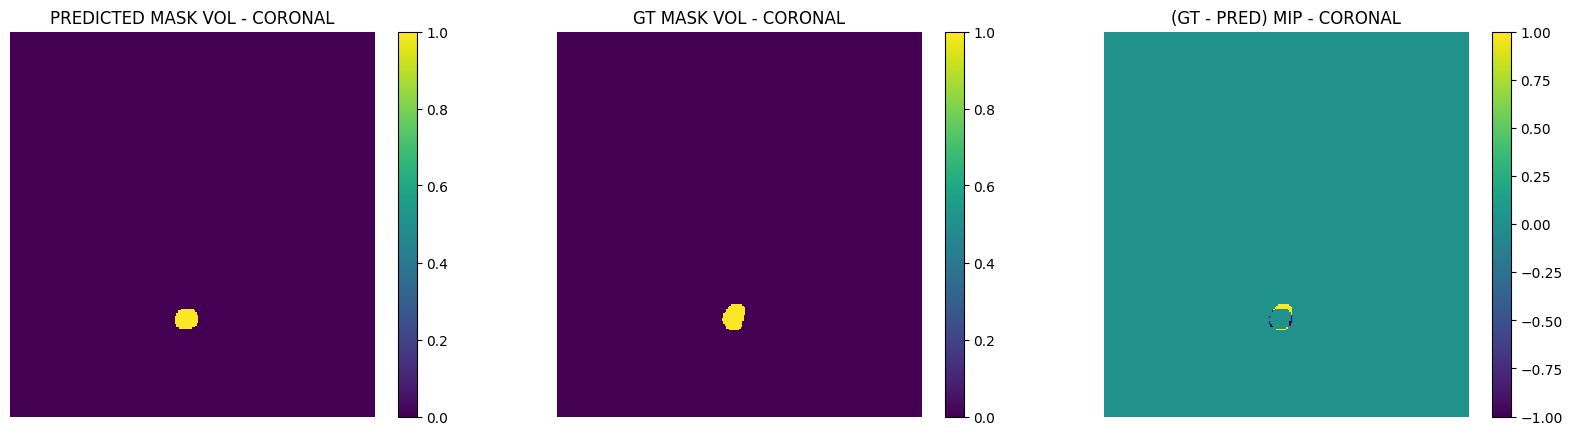

patient id: PSMA-01-097


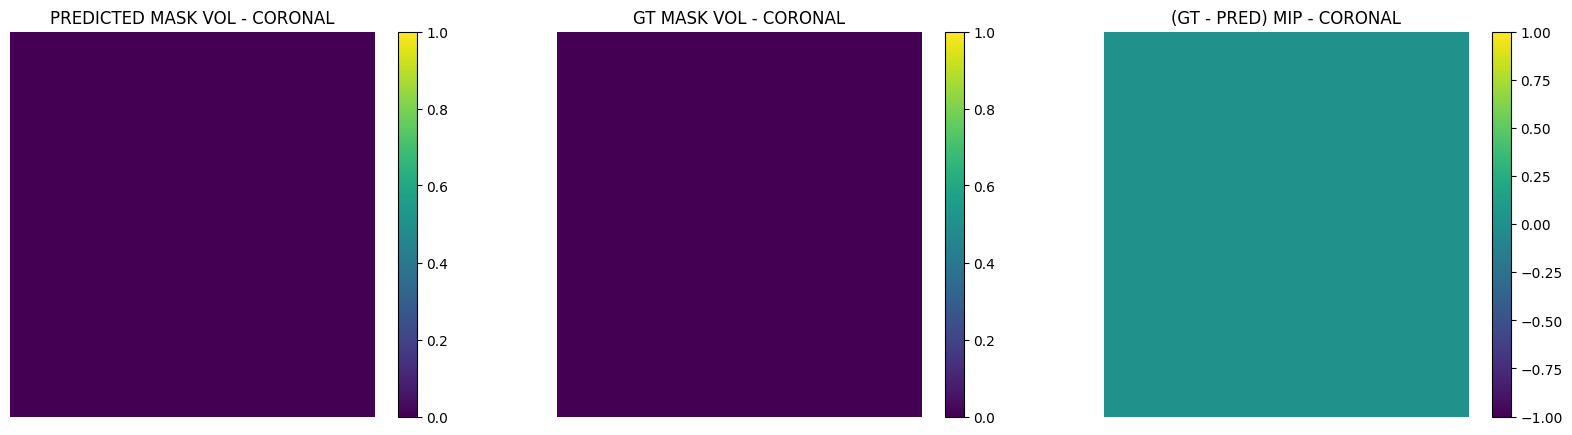

patient id: PSMA-01-097


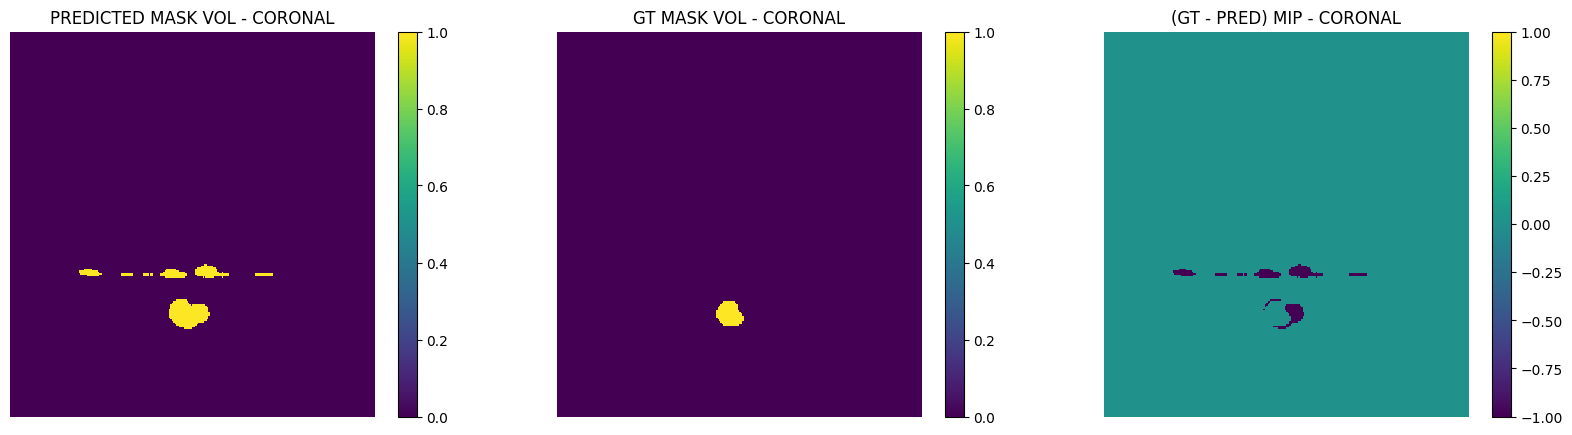

patient id: PSMA-01-111


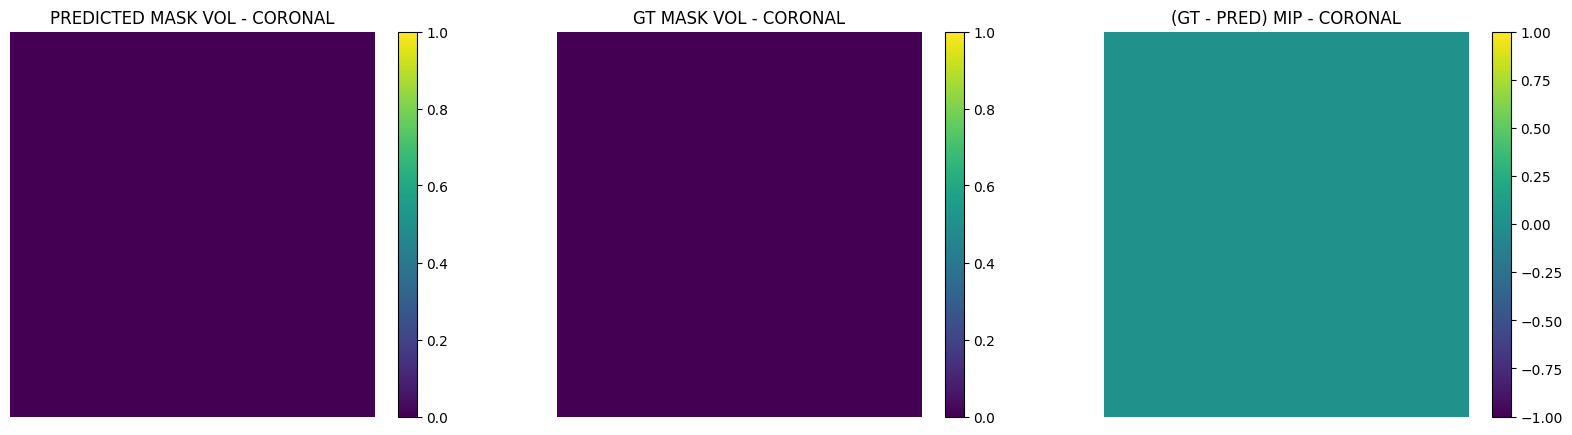

patient id: PSMA-01-111


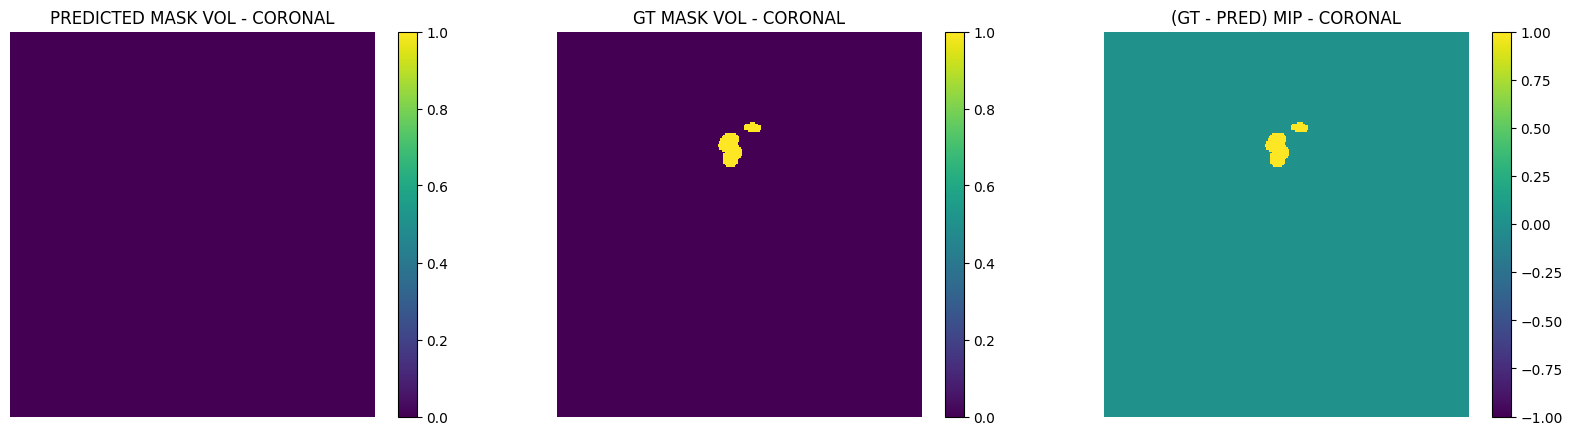

patient id: PSMA-01-119


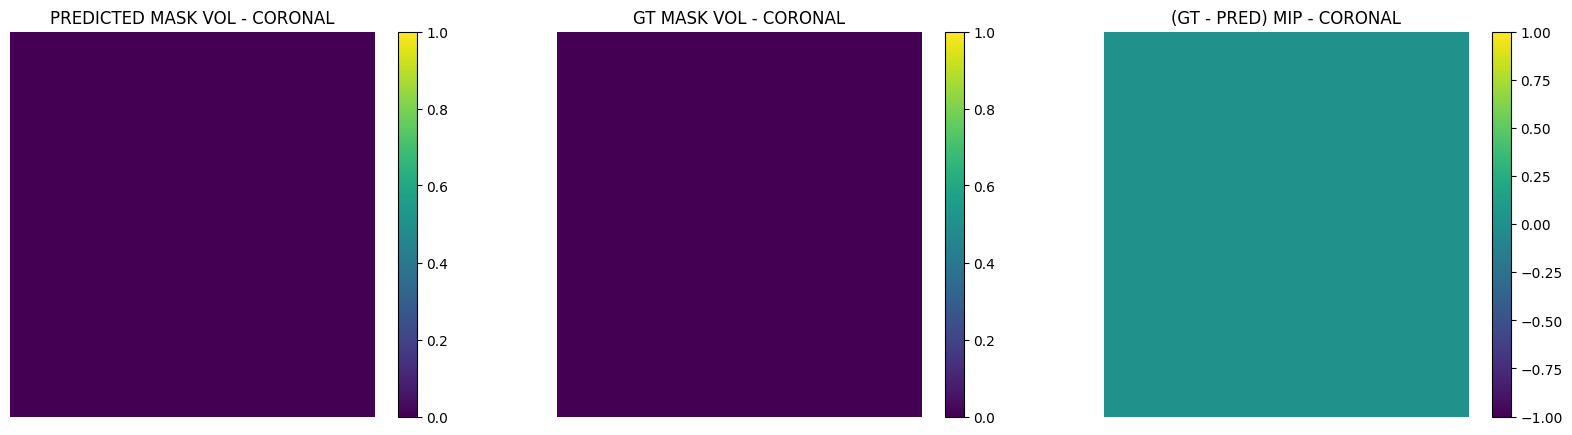

patient id: PSMA-01-119


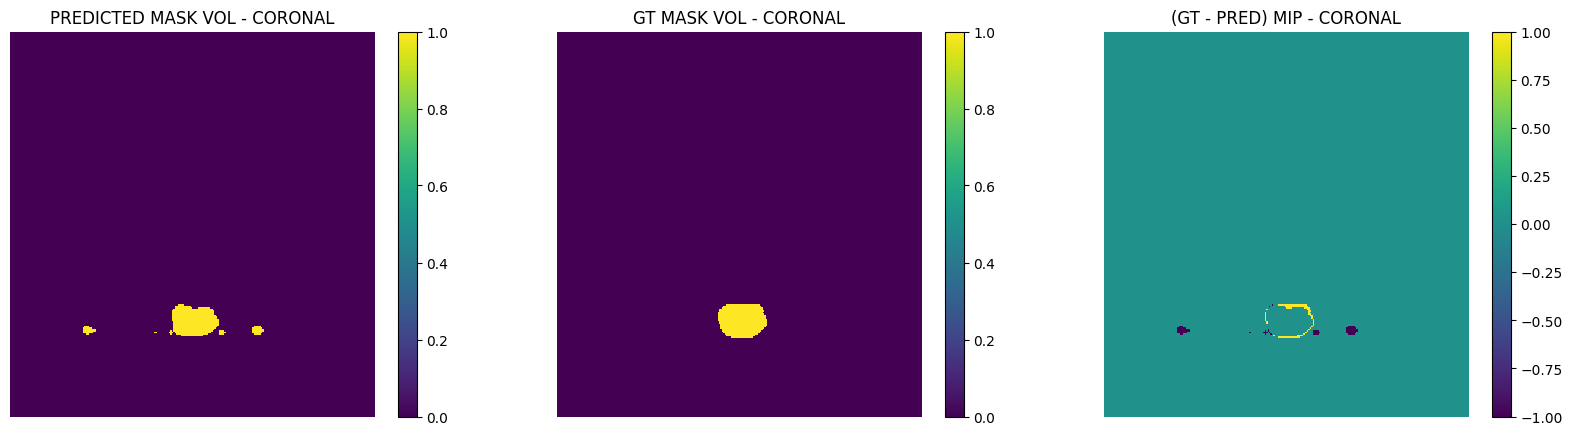

patient id: PSMA-01-120


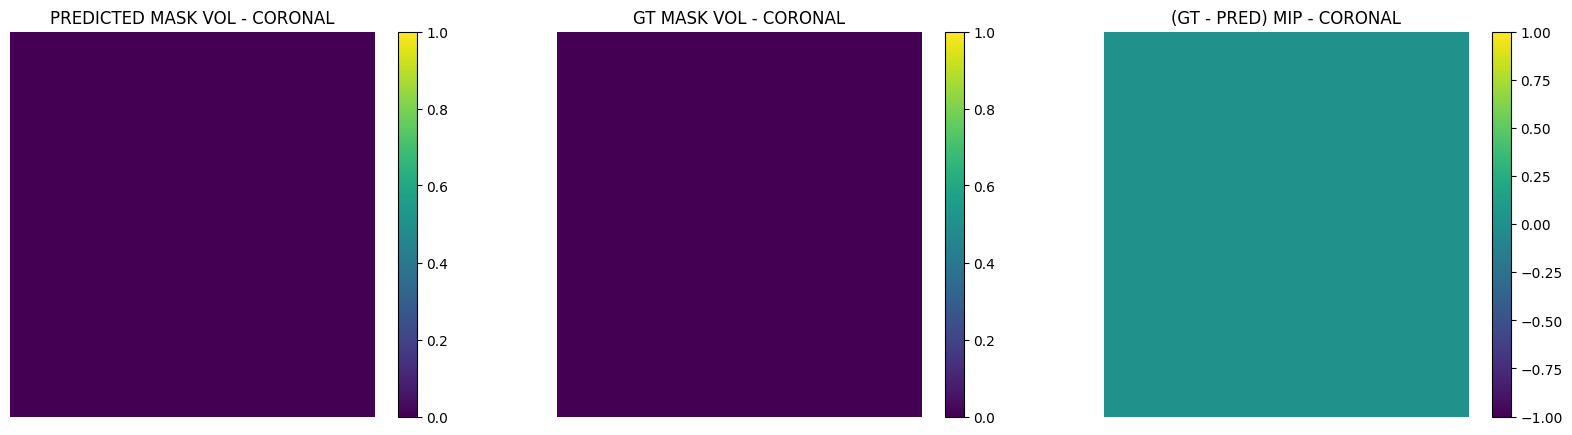

patient id: PSMA-01-120


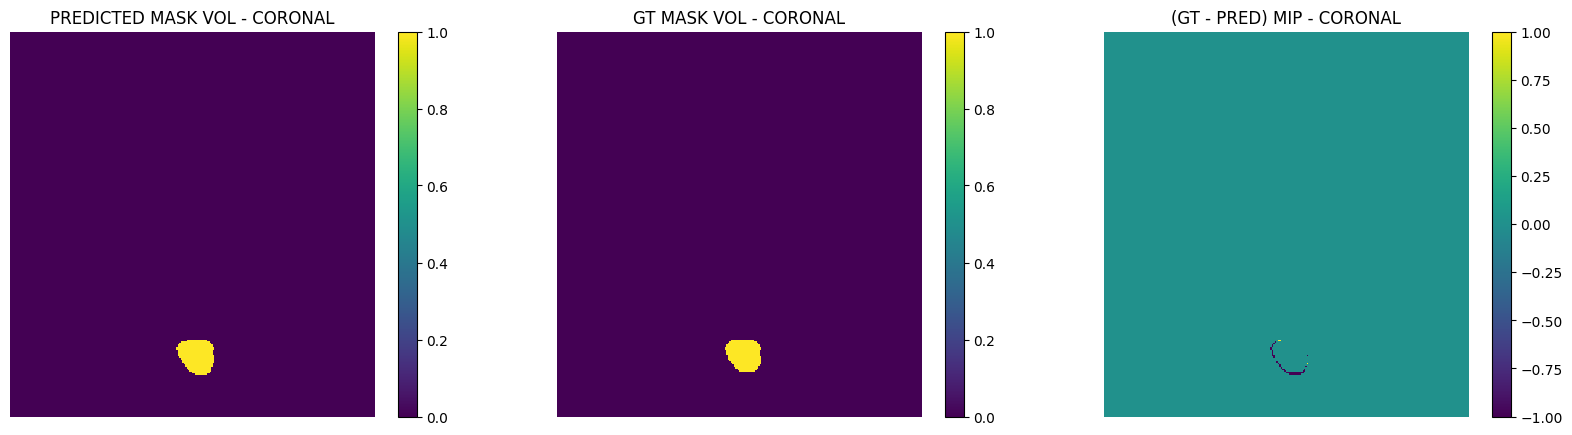

patient id: PSMA-01-123


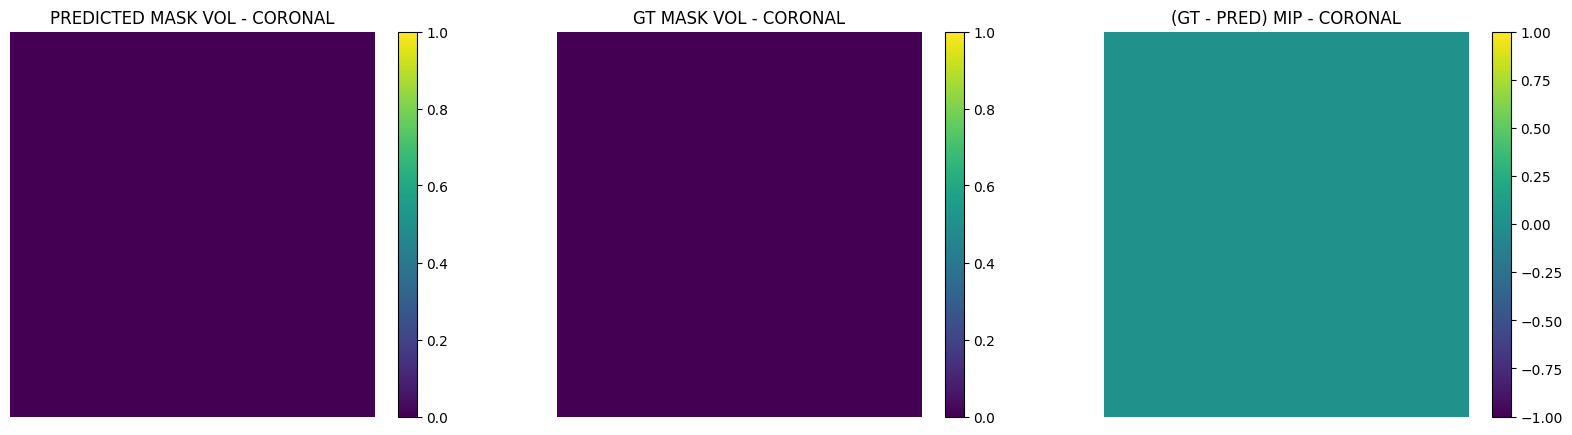

patient id: PSMA-01-123


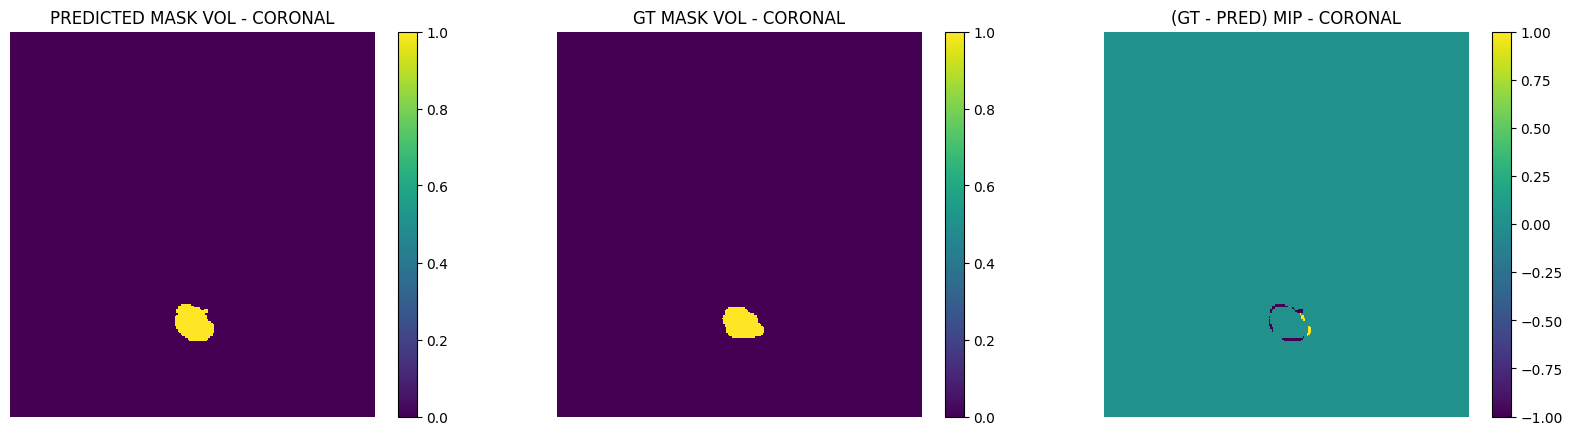

patient id: PSMA-01-128


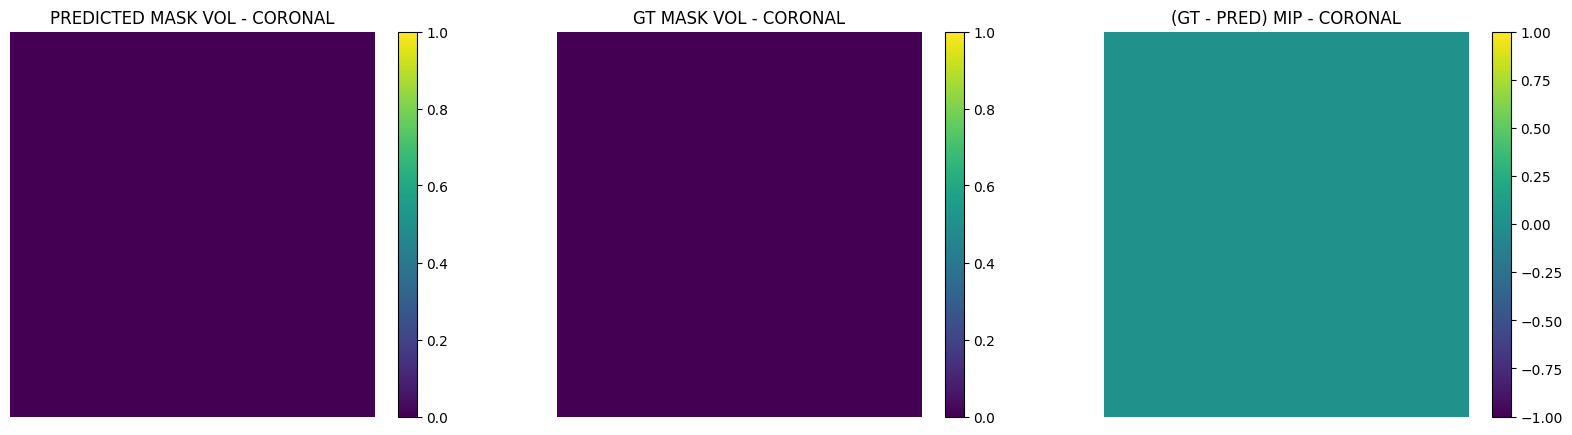

patient id: PSMA-01-128


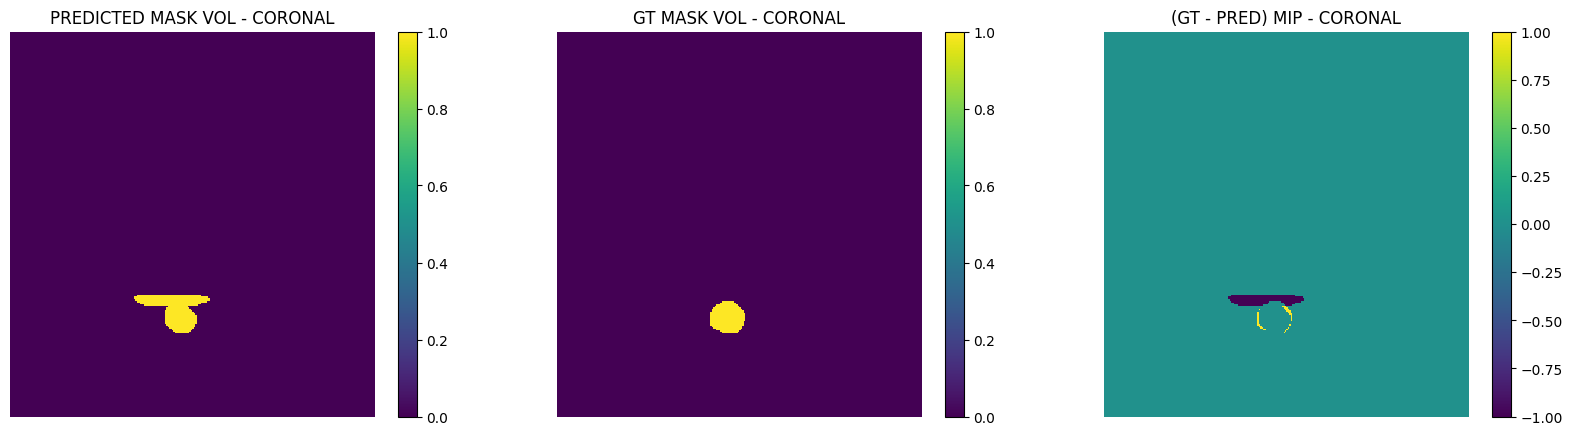

patient id: PSMA-01-145


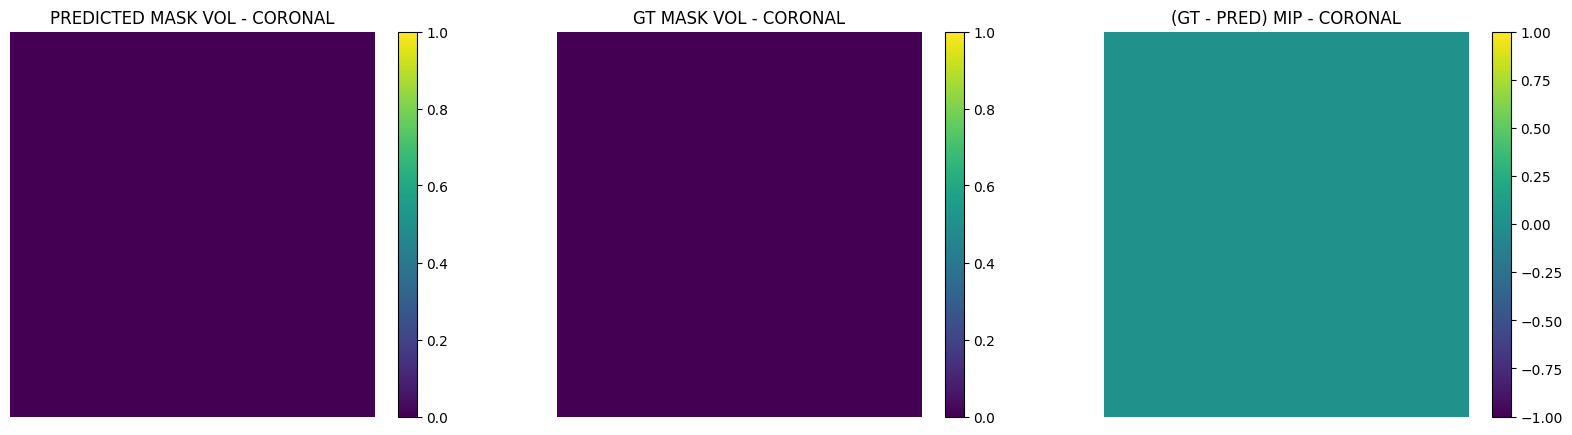

patient id: PSMA-01-145


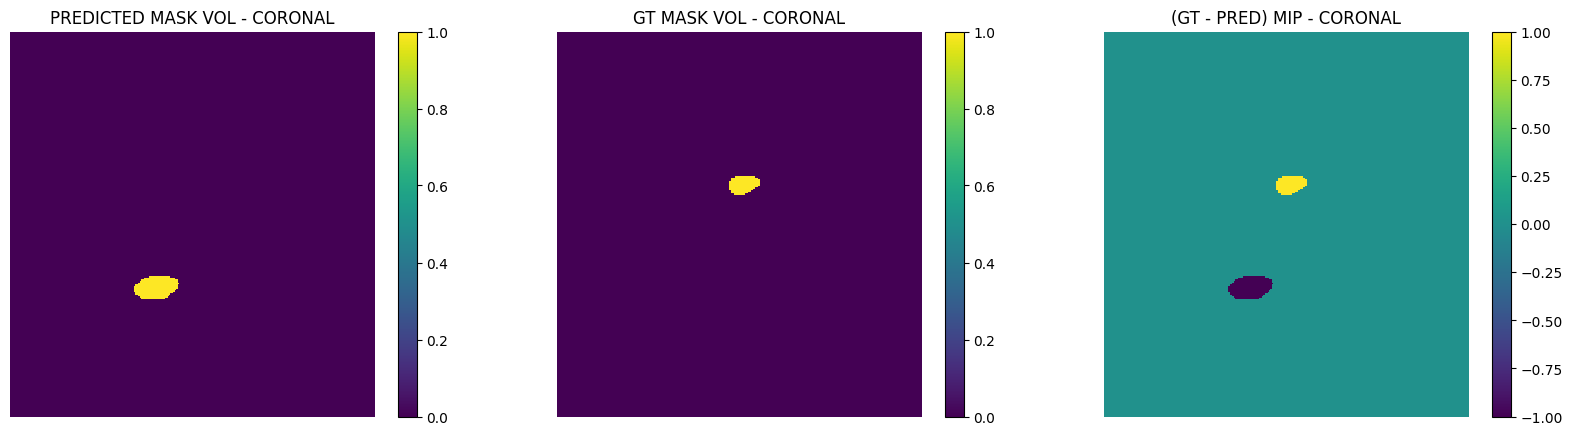

patient id: PSMA-01-155


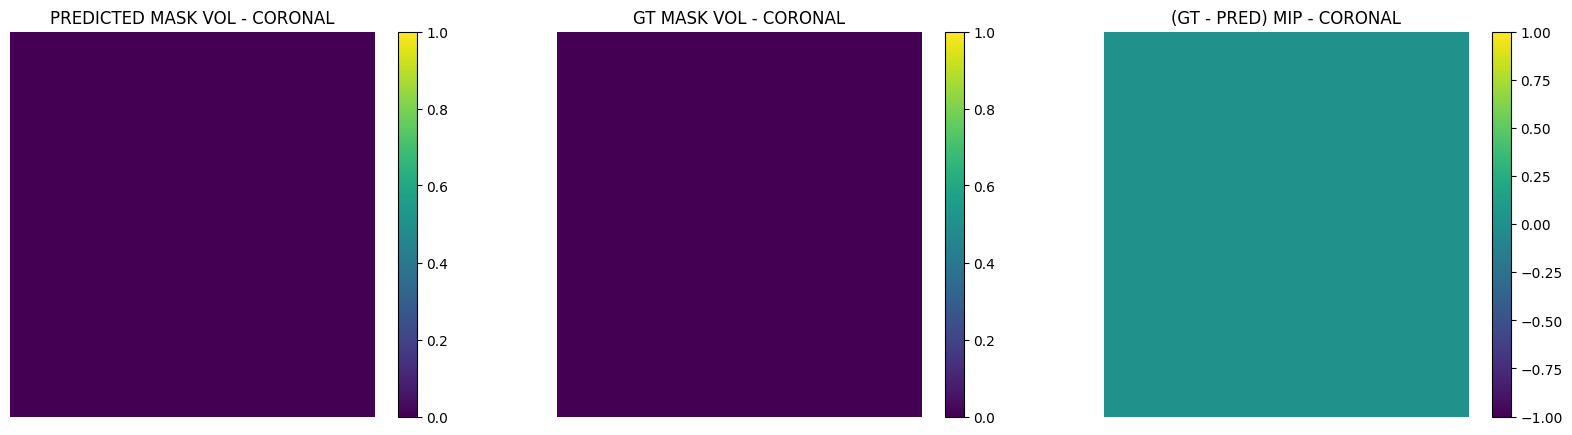

patient id: PSMA-01-155


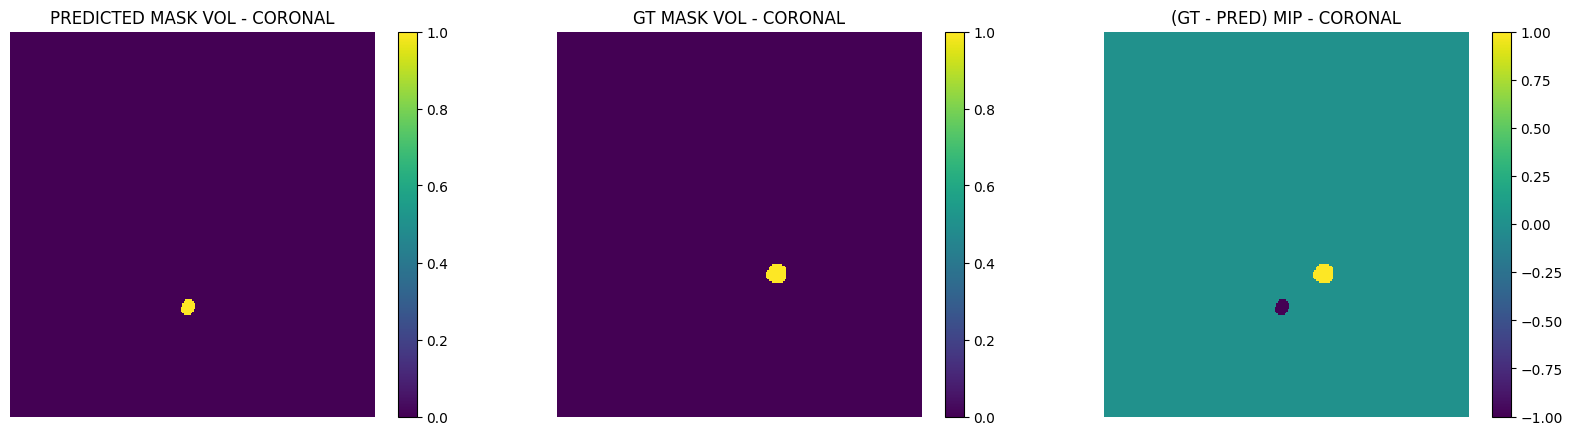

patient id: PSMA-01-161


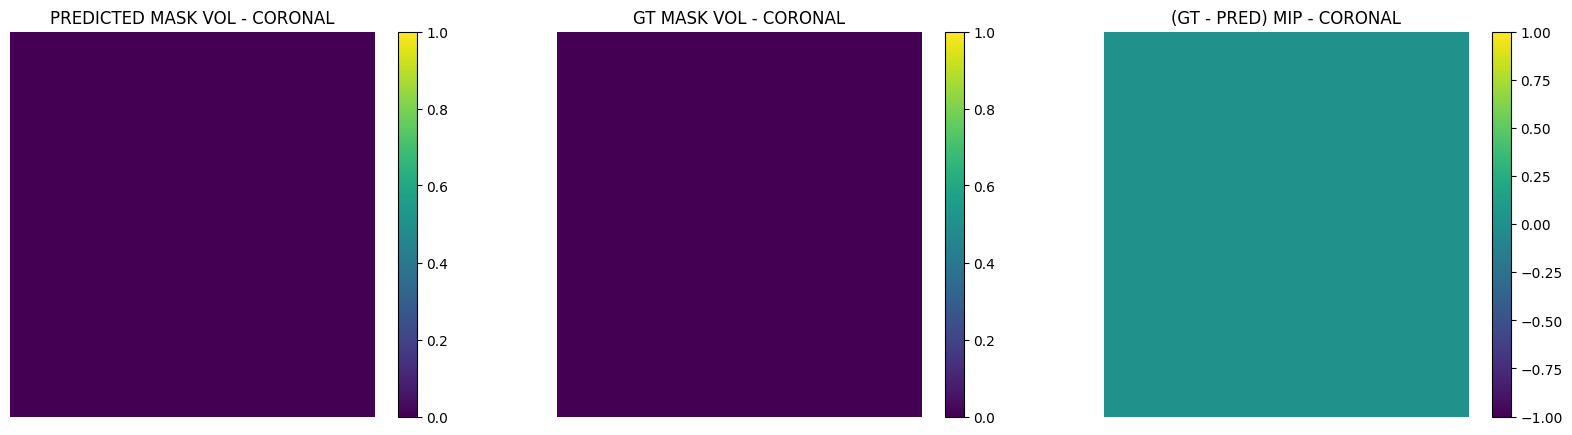

patient id: PSMA-01-161


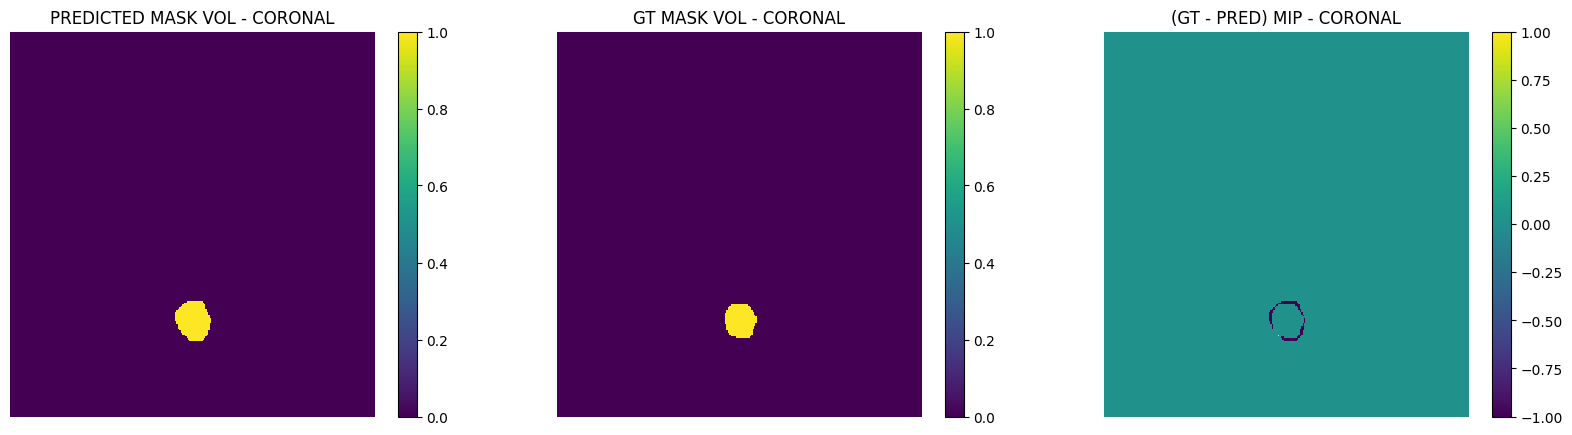

patient id: PSMA-01-170


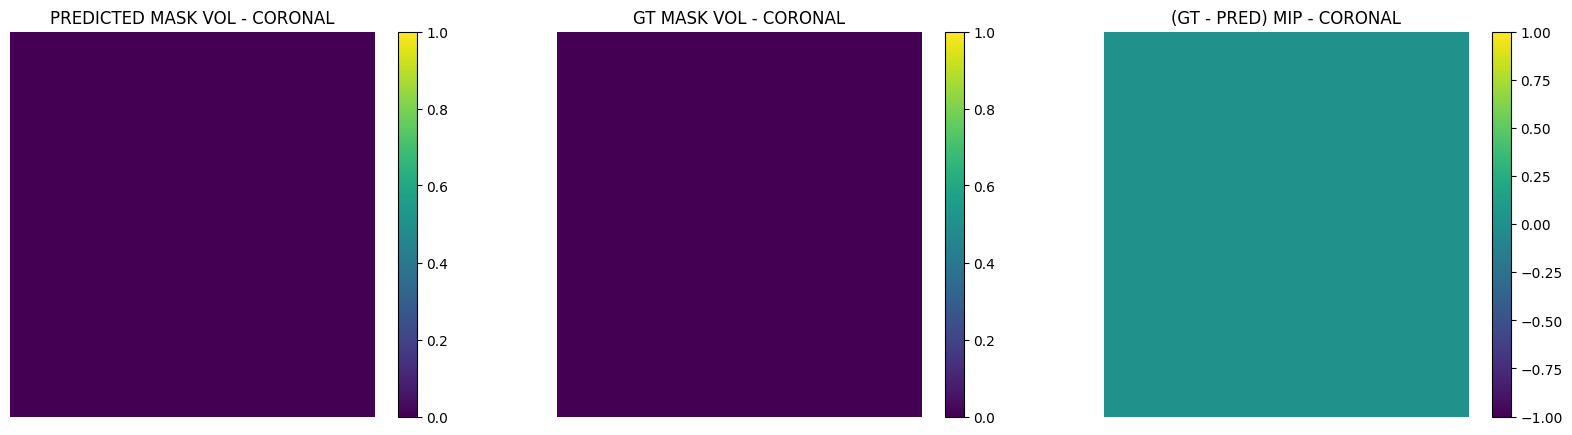

patient id: PSMA-01-170


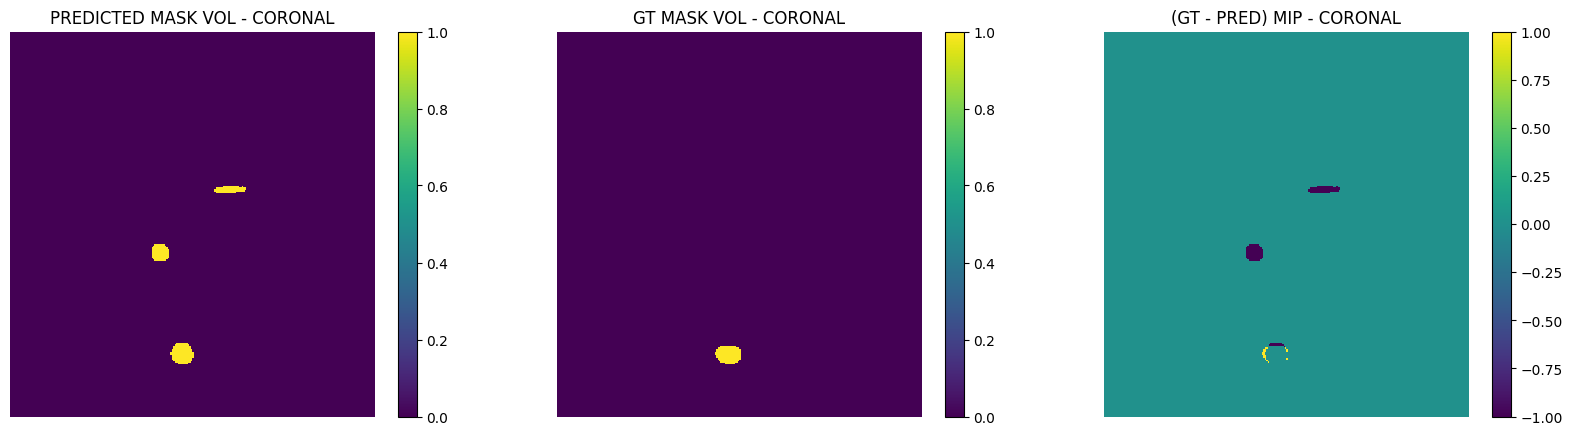

patient id: PSMA-01-186


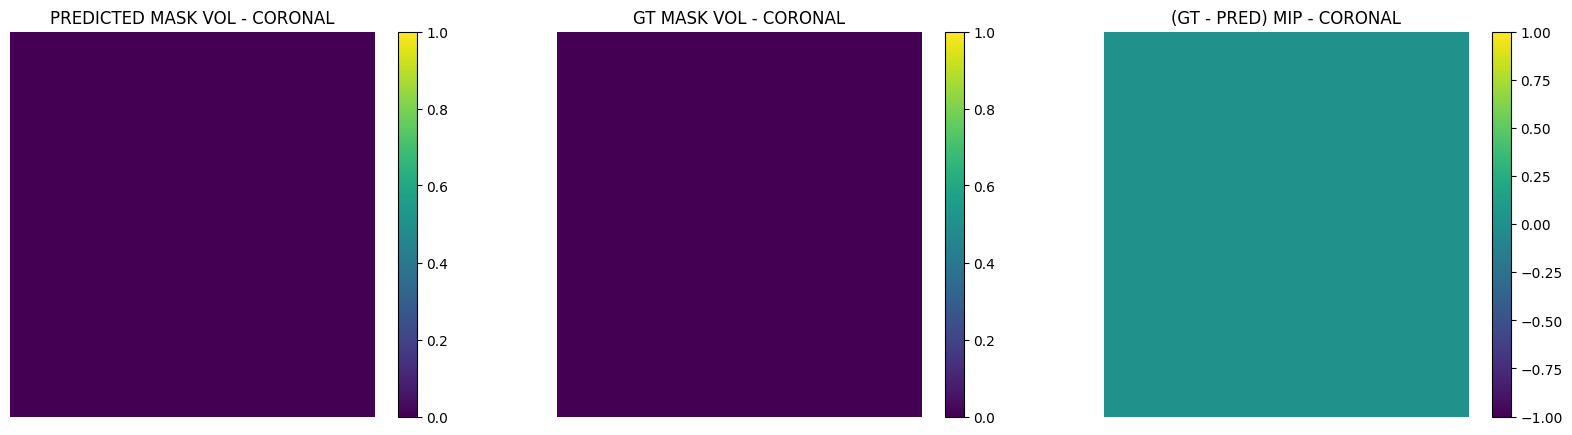

patient id: PSMA-01-186


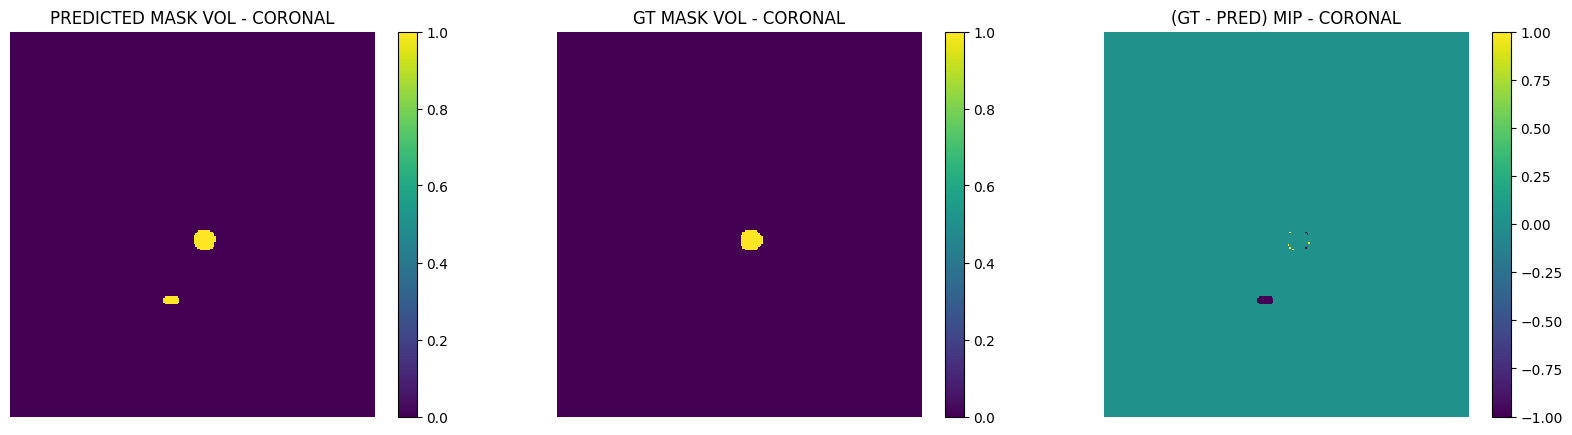

patient id: PSMA-01-188


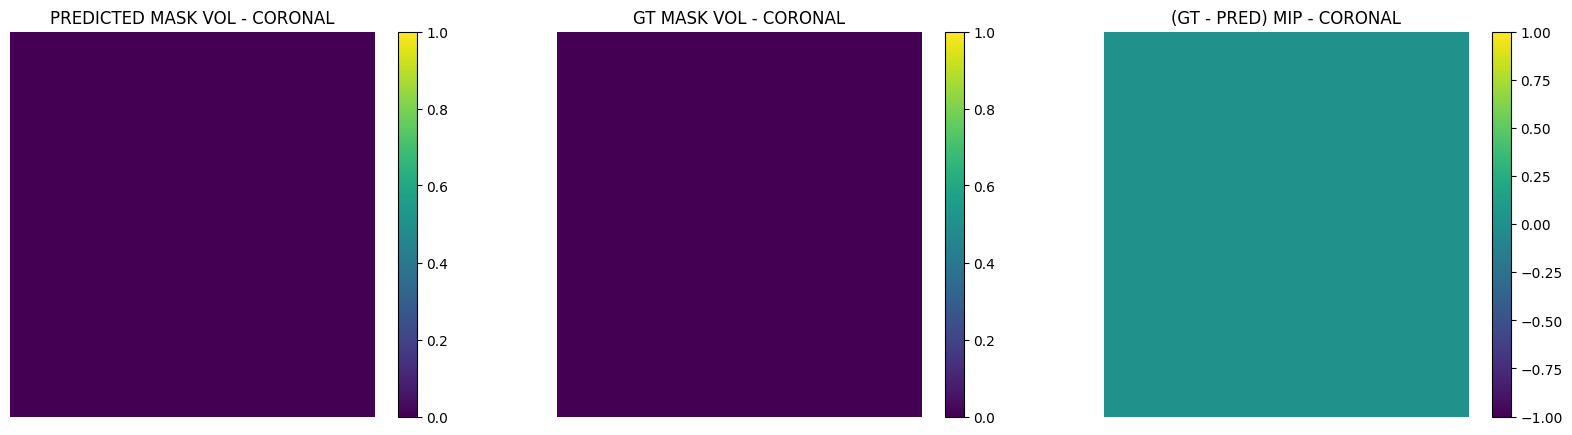

patient id: PSMA-01-188


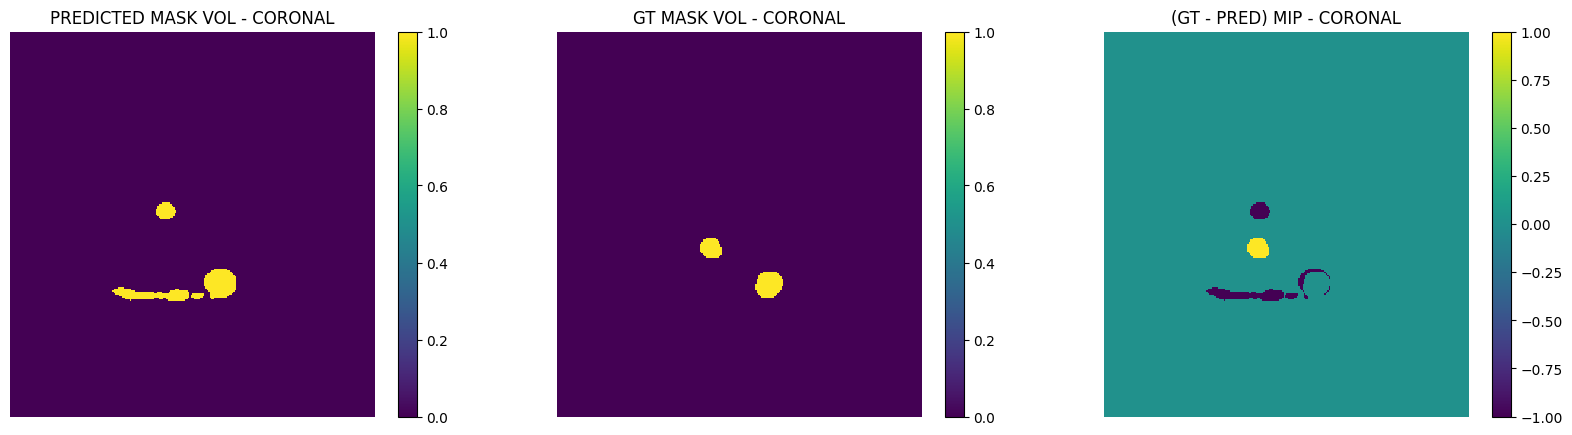

patient id: PSMA-01-193


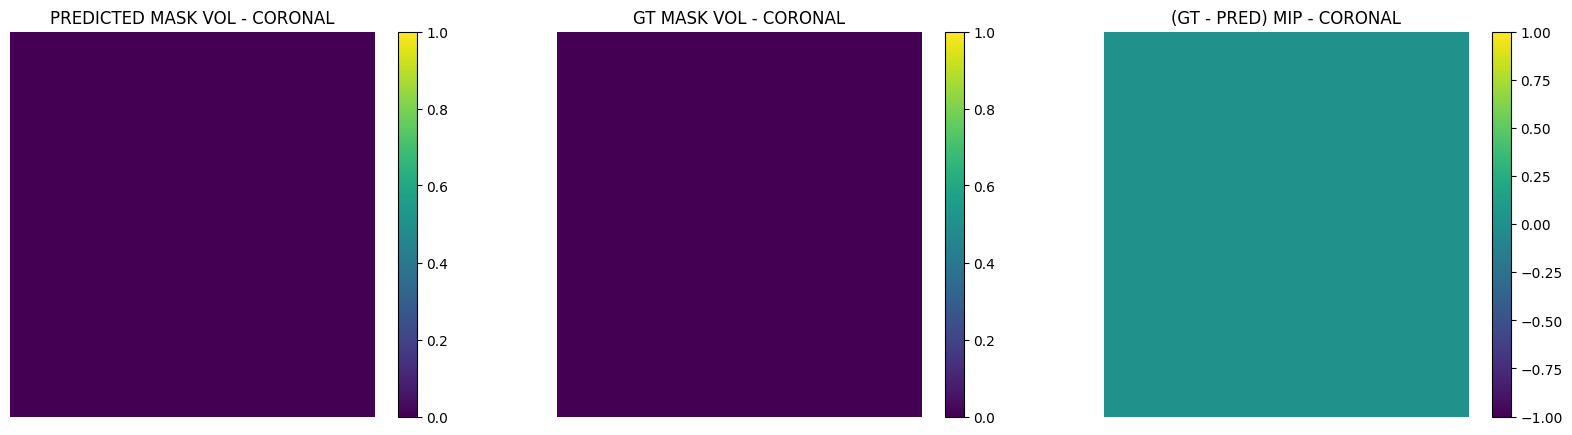

patient id: PSMA-01-193


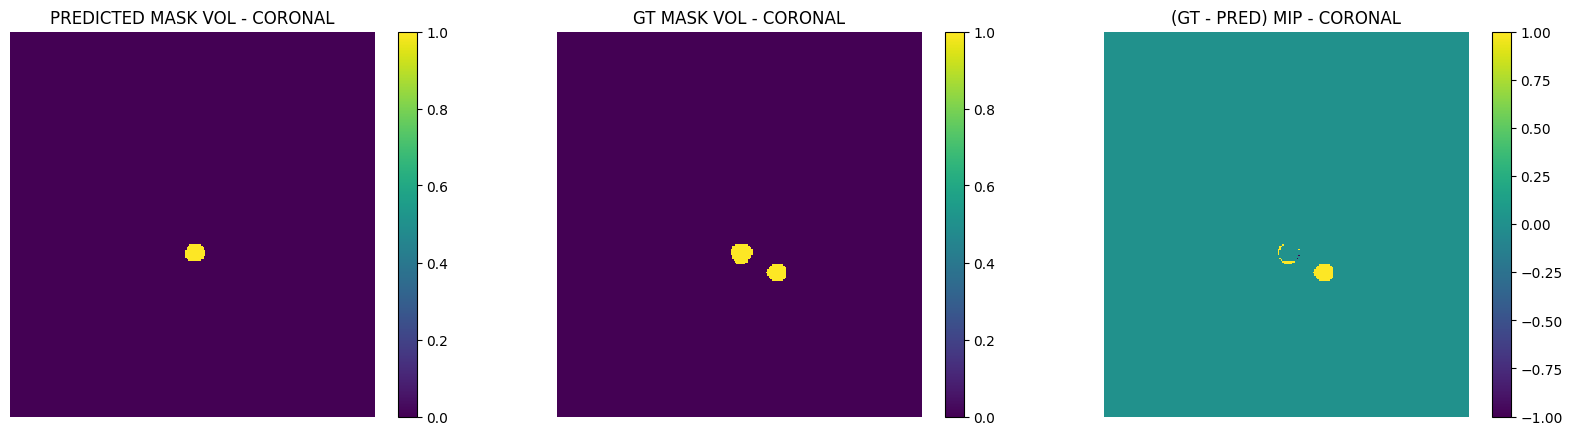

patient id: PSMA-01-225


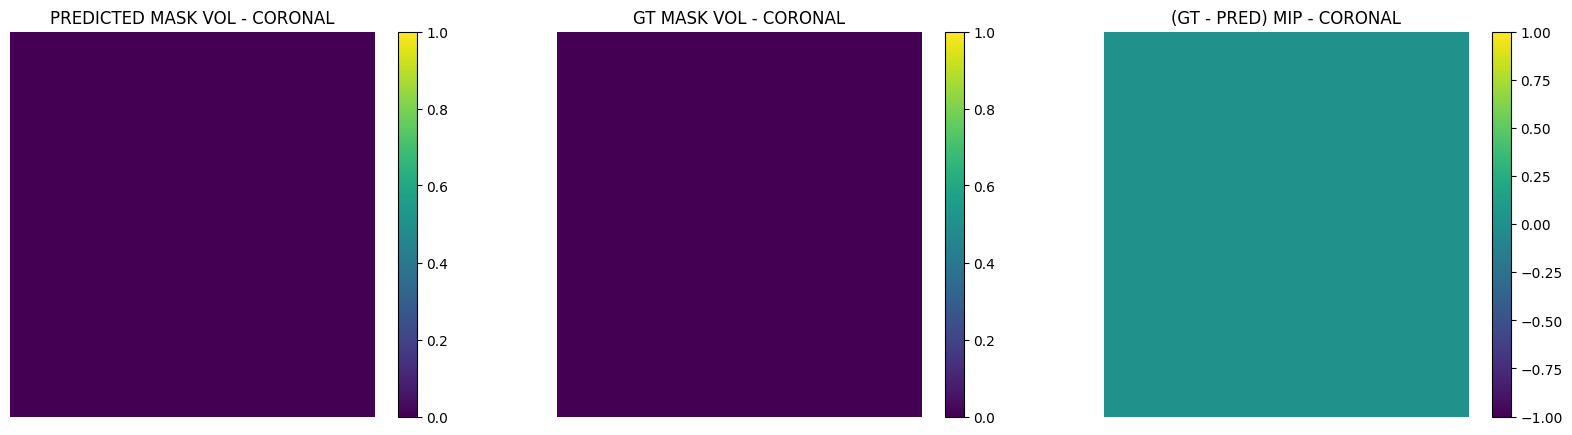

patient id: PSMA-01-225


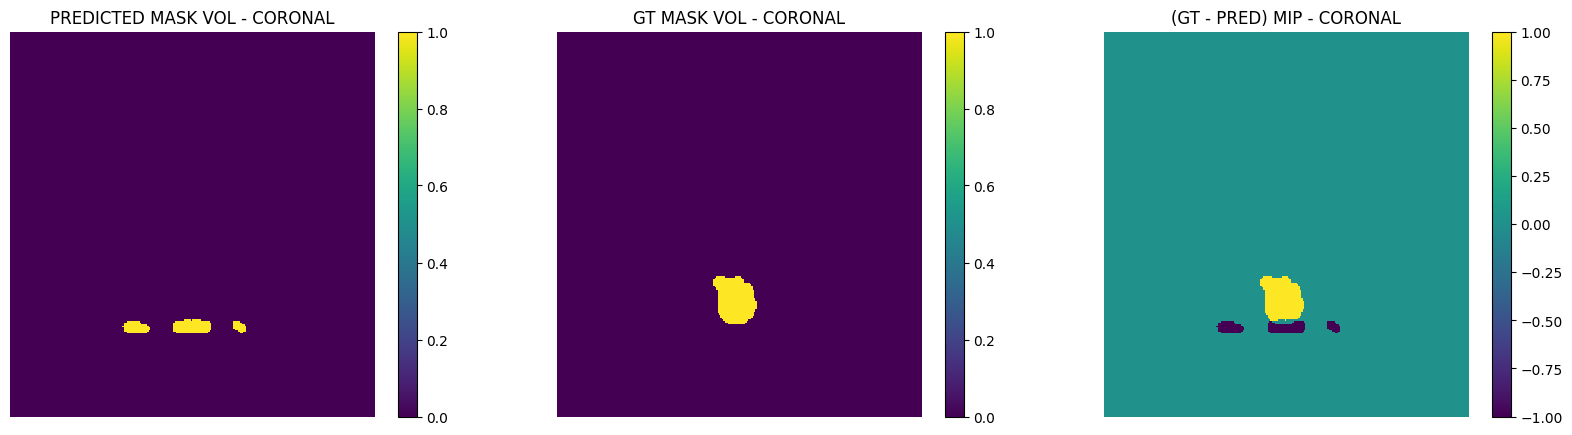

patient id: PSMA-01-234


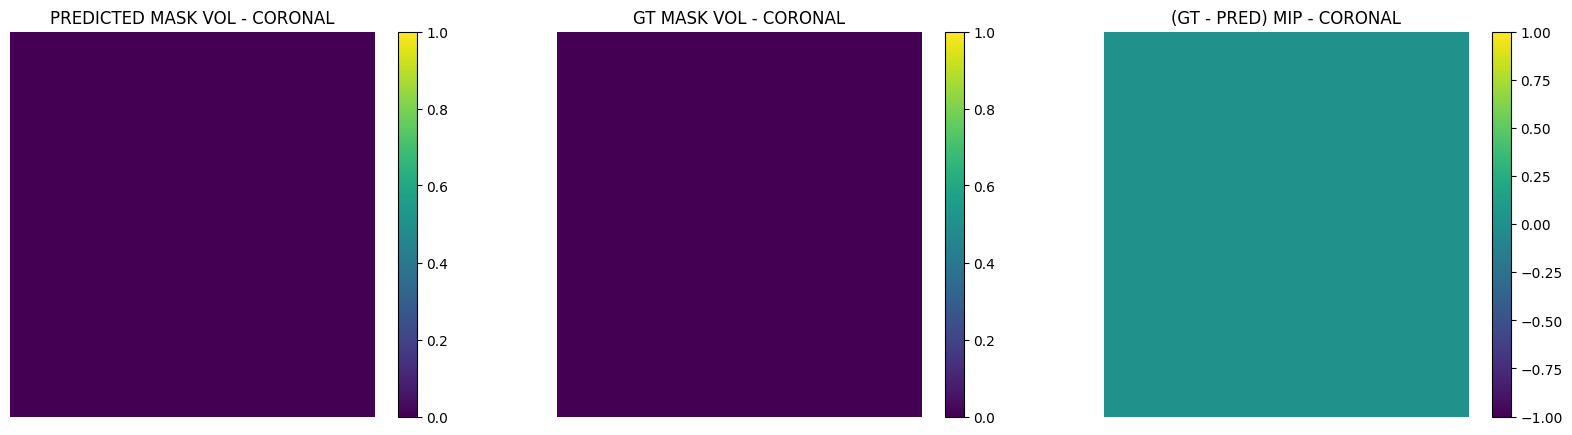

patient id: PSMA-01-234


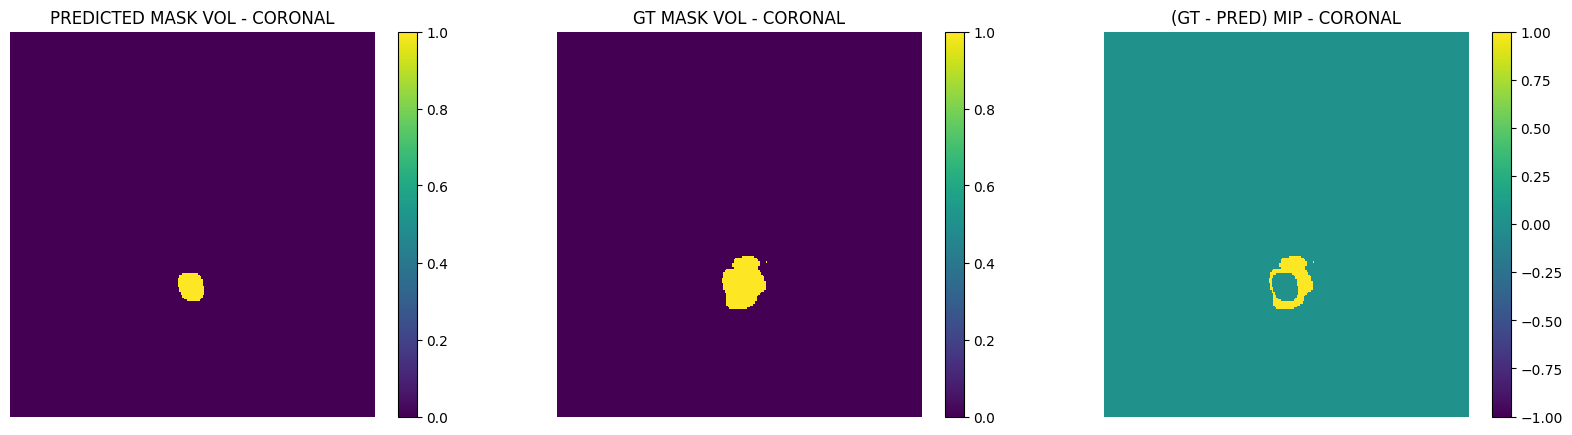

patient id: PSMA-01-240


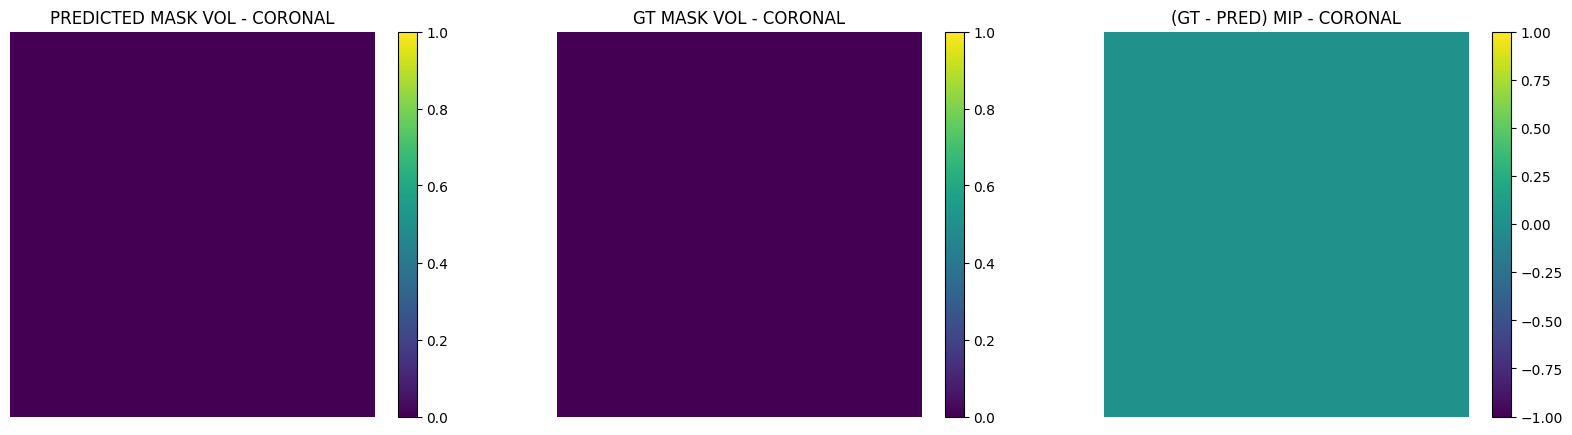

patient id: PSMA-01-240


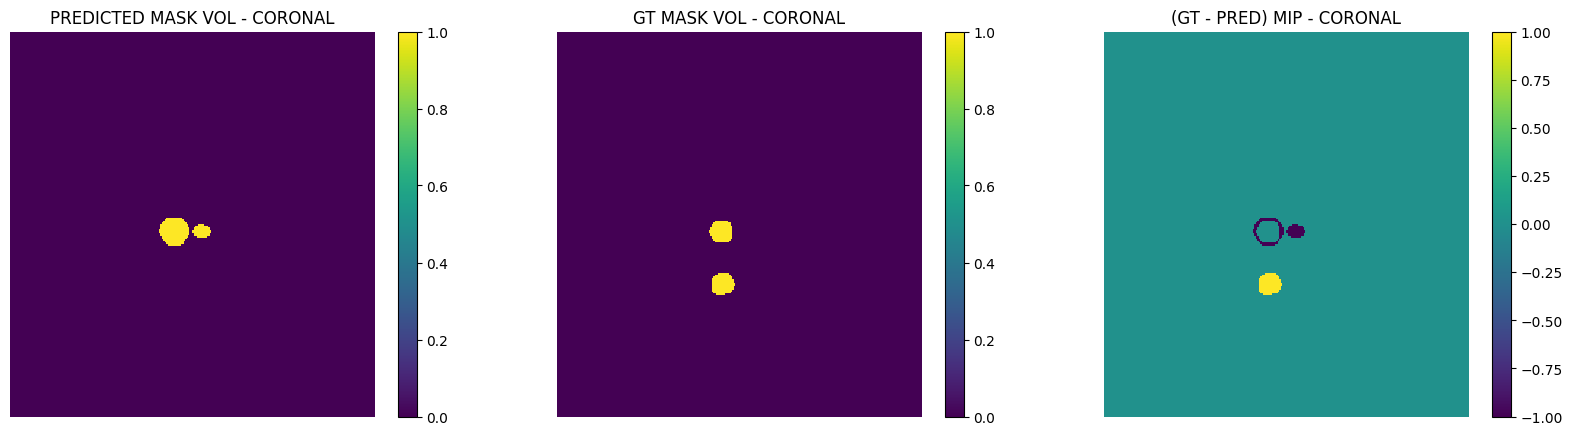

patient id: PSMA-01-276


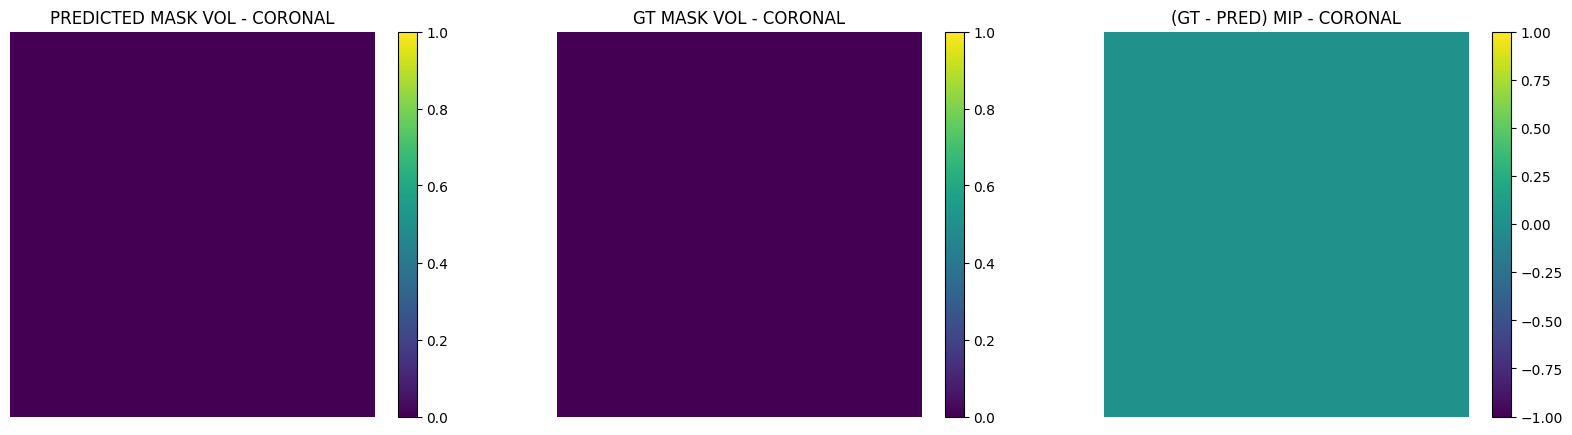

patient id: PSMA-01-276


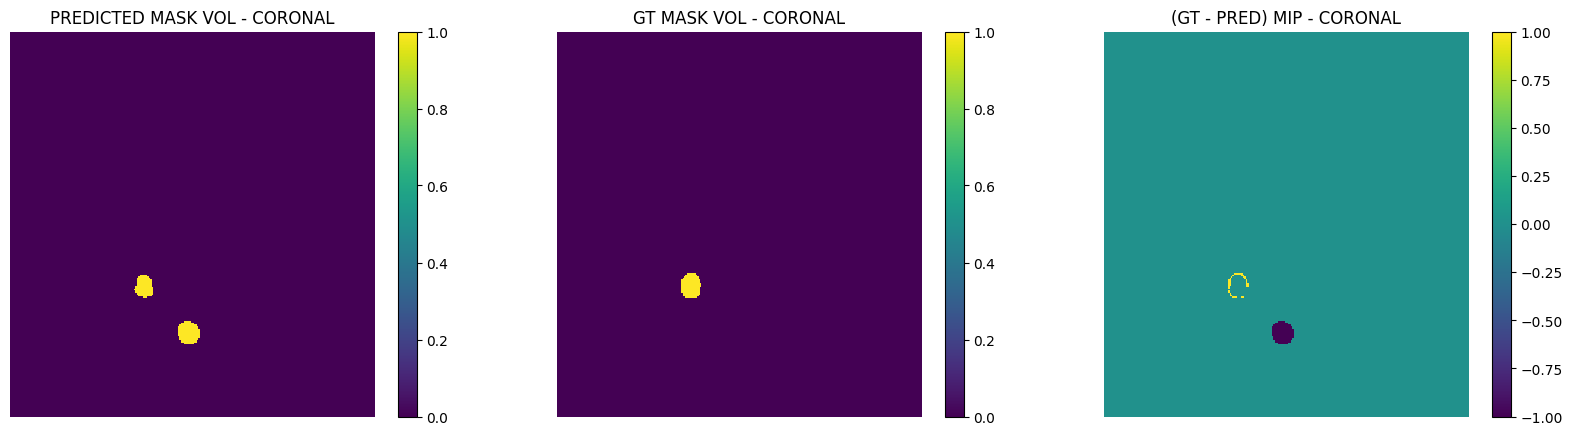

patient id: PSMA-01-281


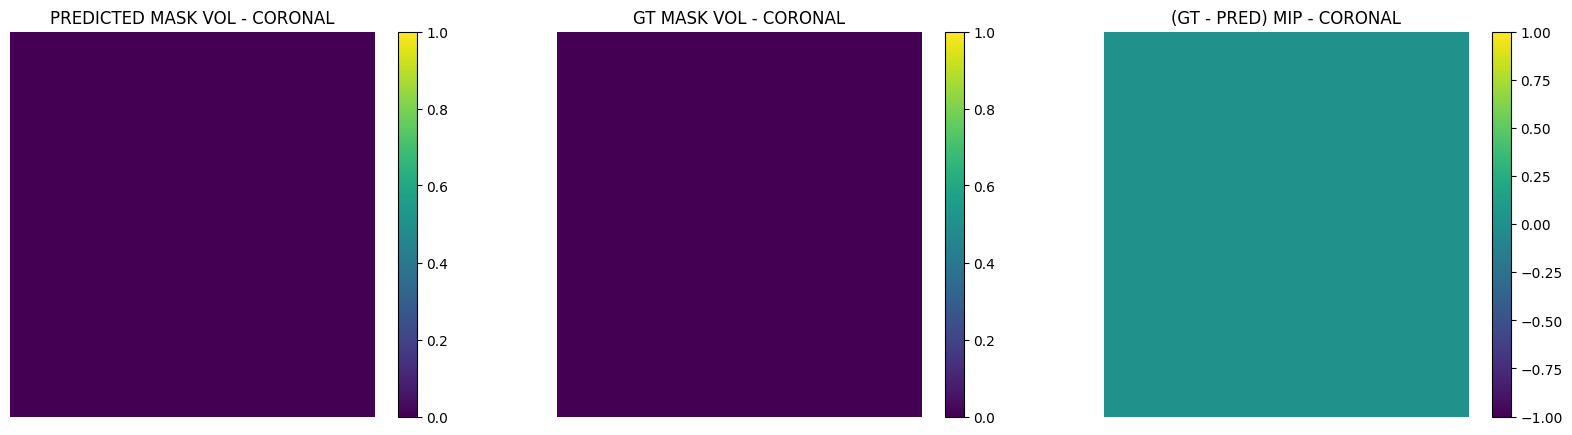

patient id: PSMA-01-281


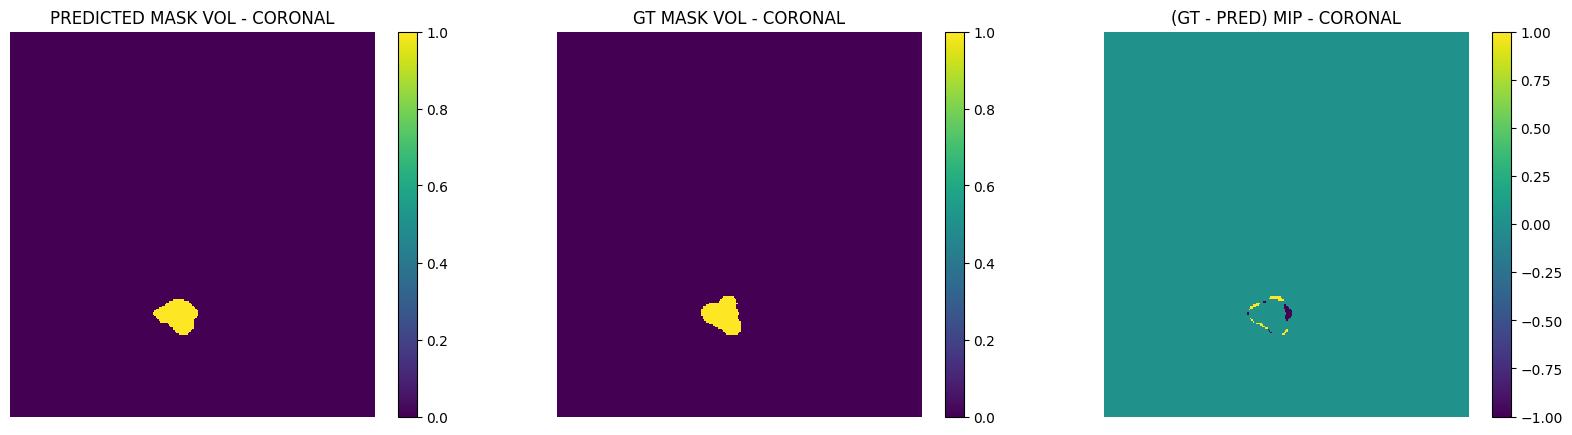

patient id: PSMA-01-282


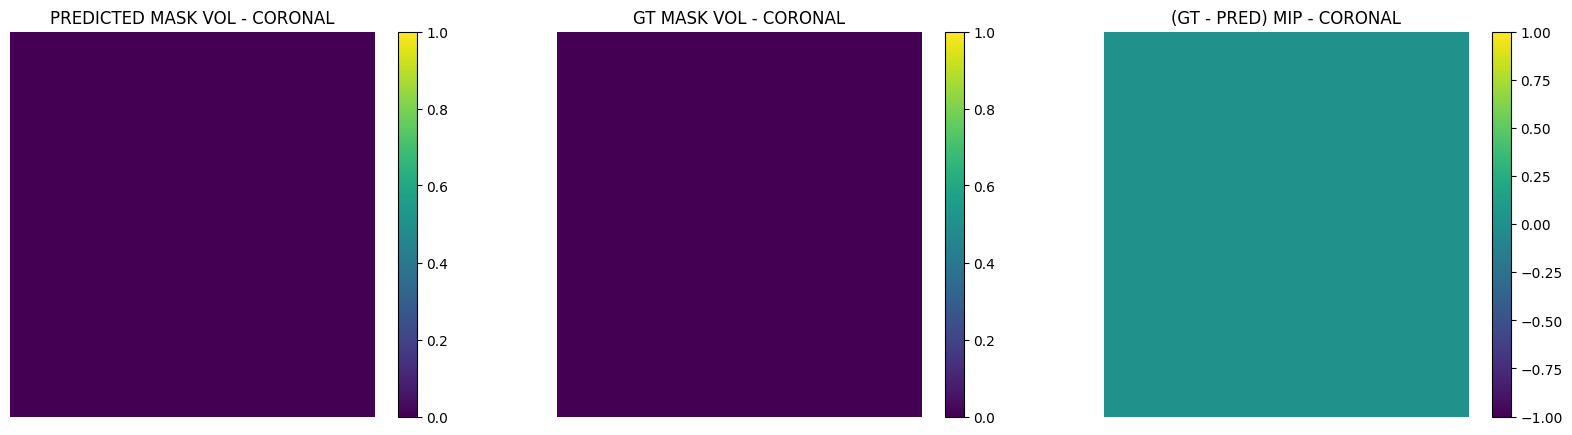

patient id: PSMA-01-282


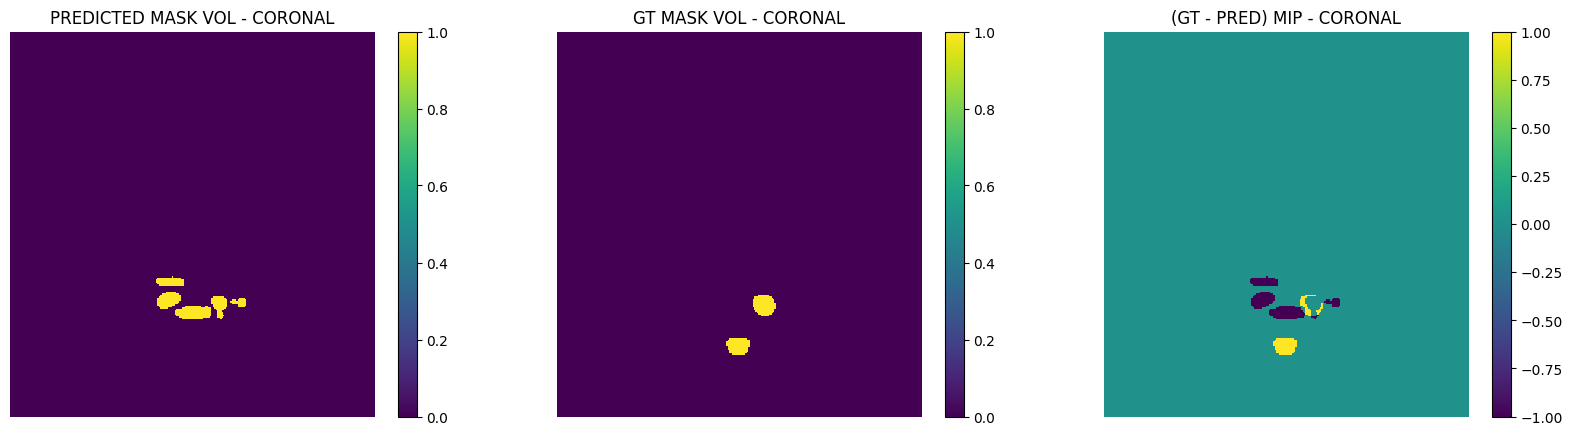

patient id: PSMA-01-286


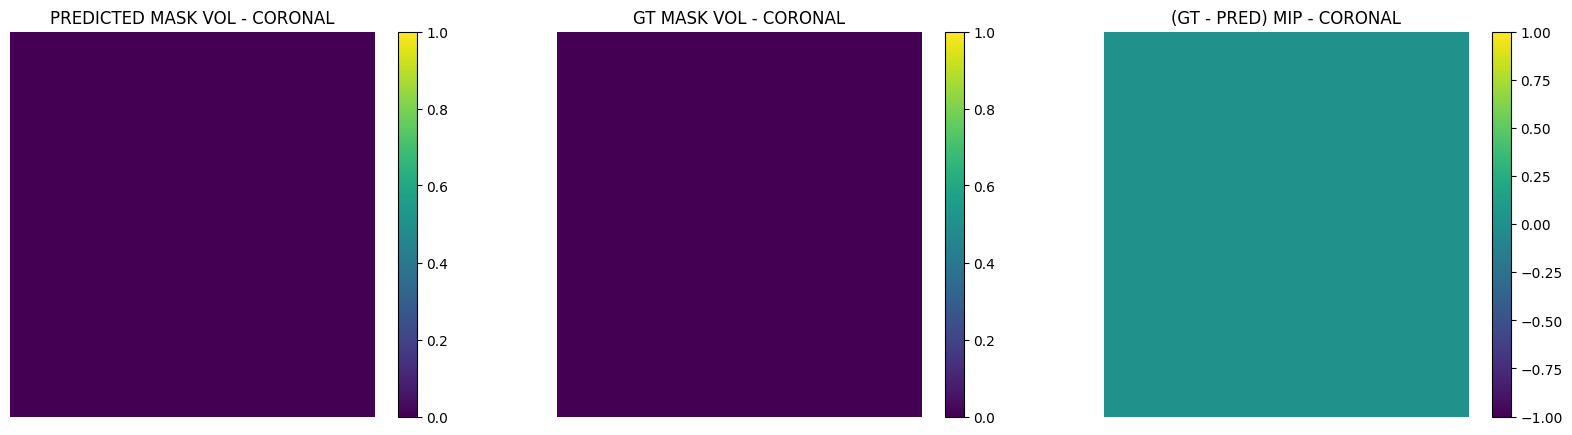

patient id: PSMA-01-286


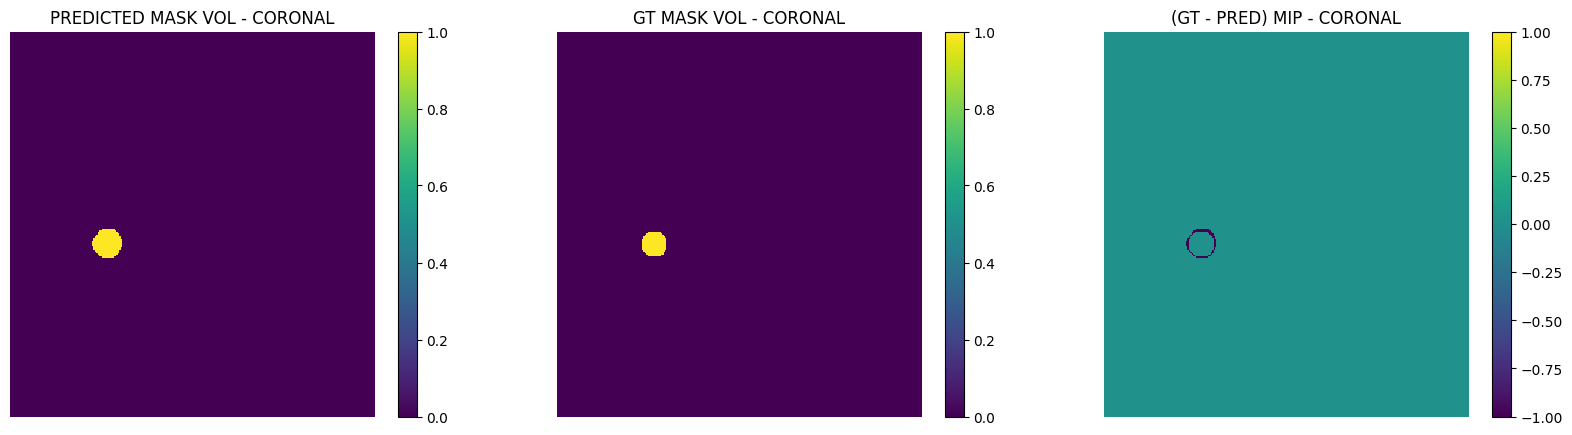

patient id: PSMA-01-296


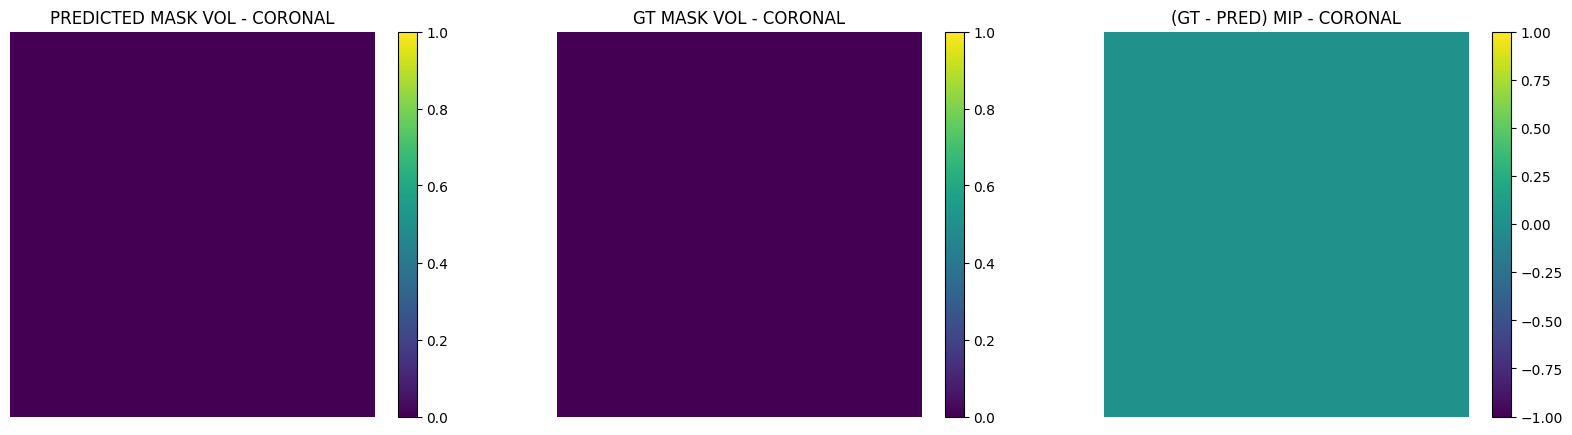

patient id: PSMA-01-296


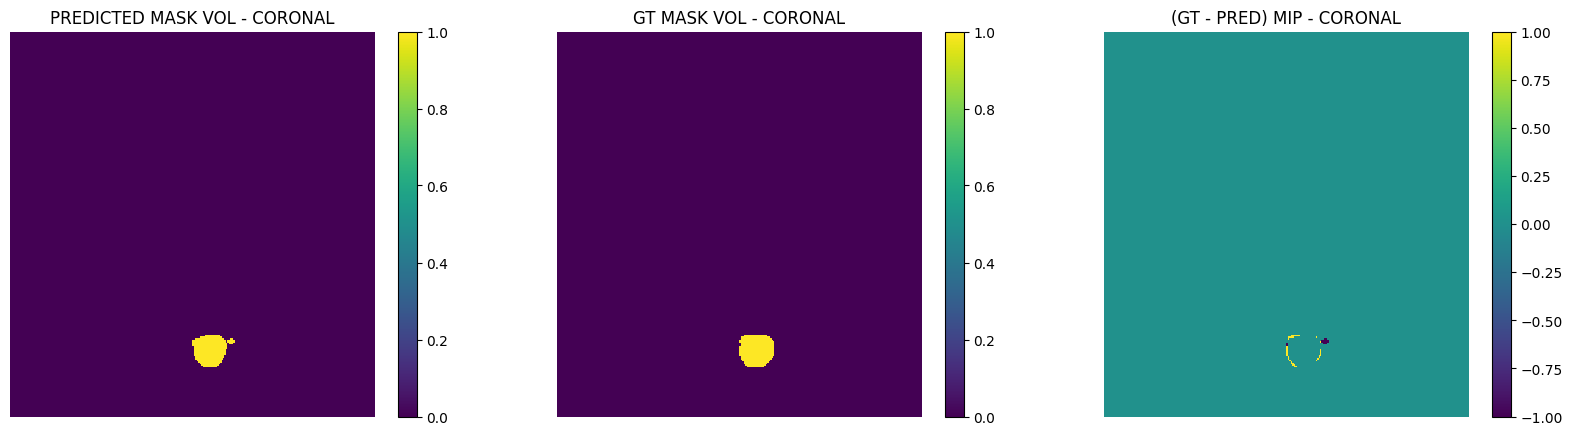

patient id: PSMA-01-318


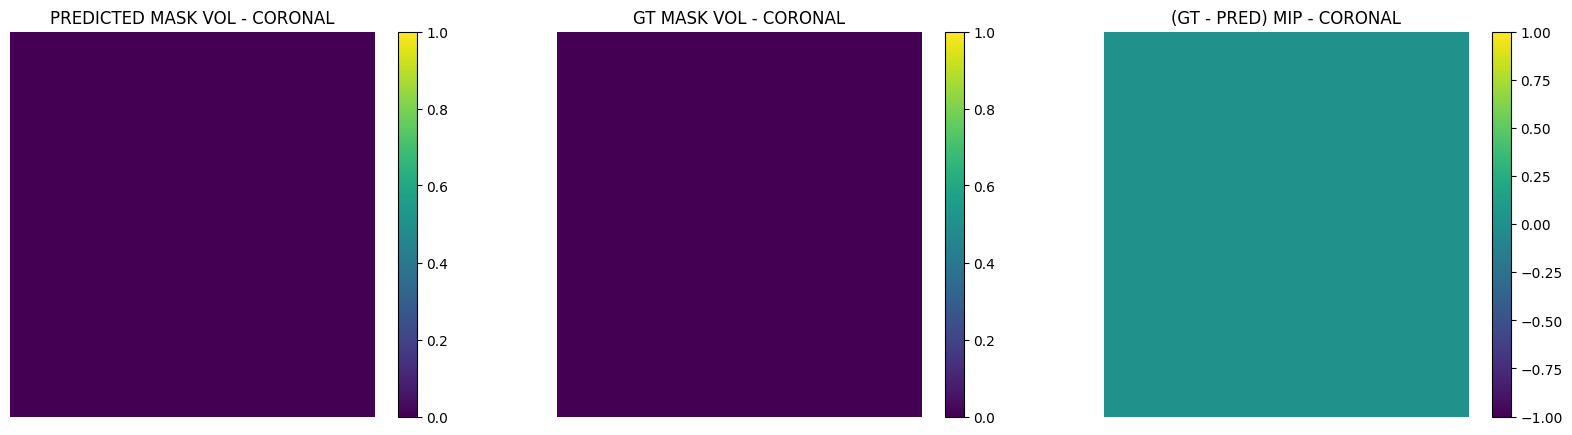

patient id: PSMA-01-318


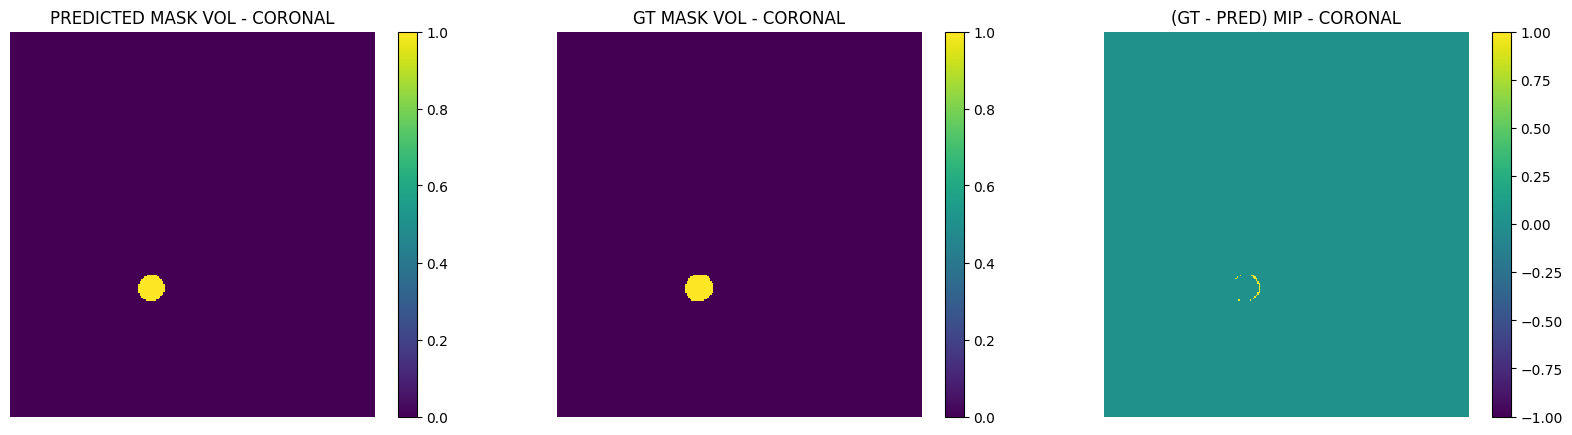

patient id: PSMA-01-364


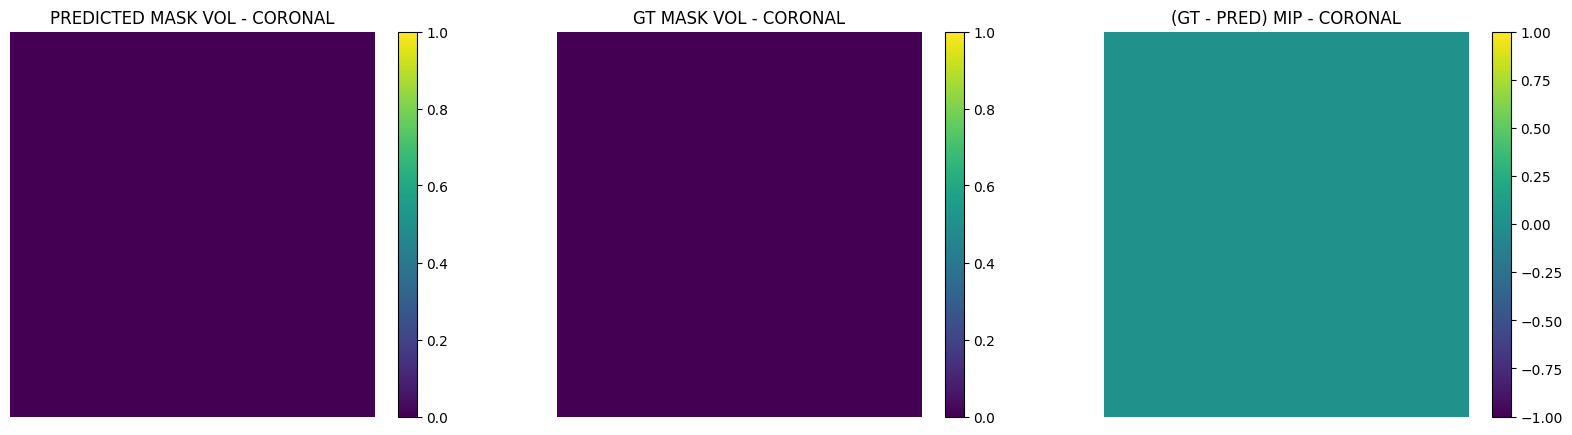

patient id: PSMA-01-364


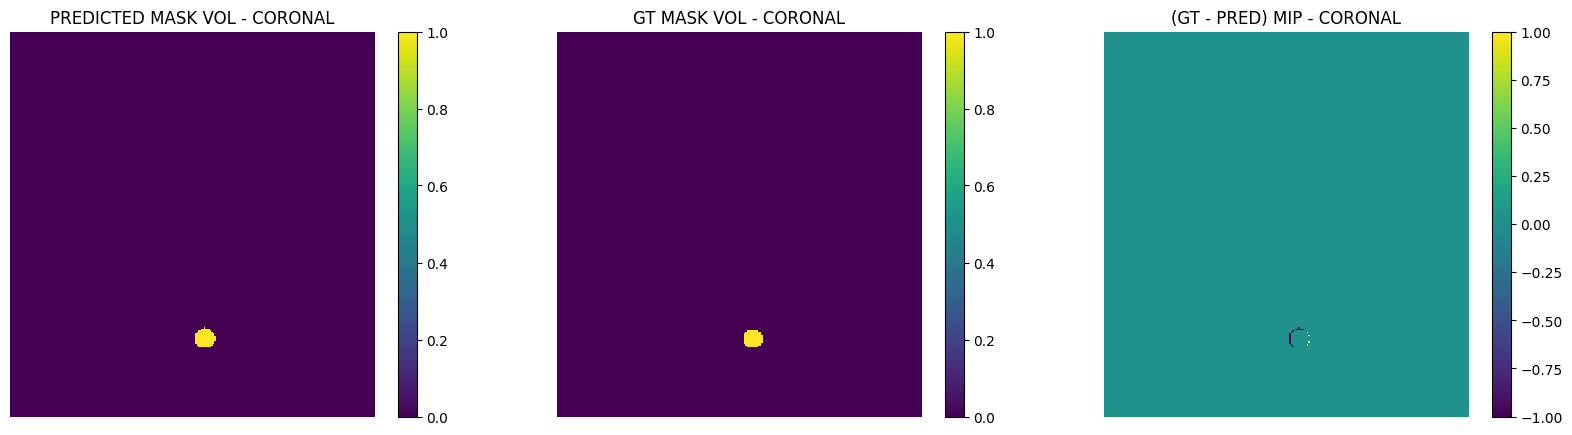

patient id: PSMA-01-367


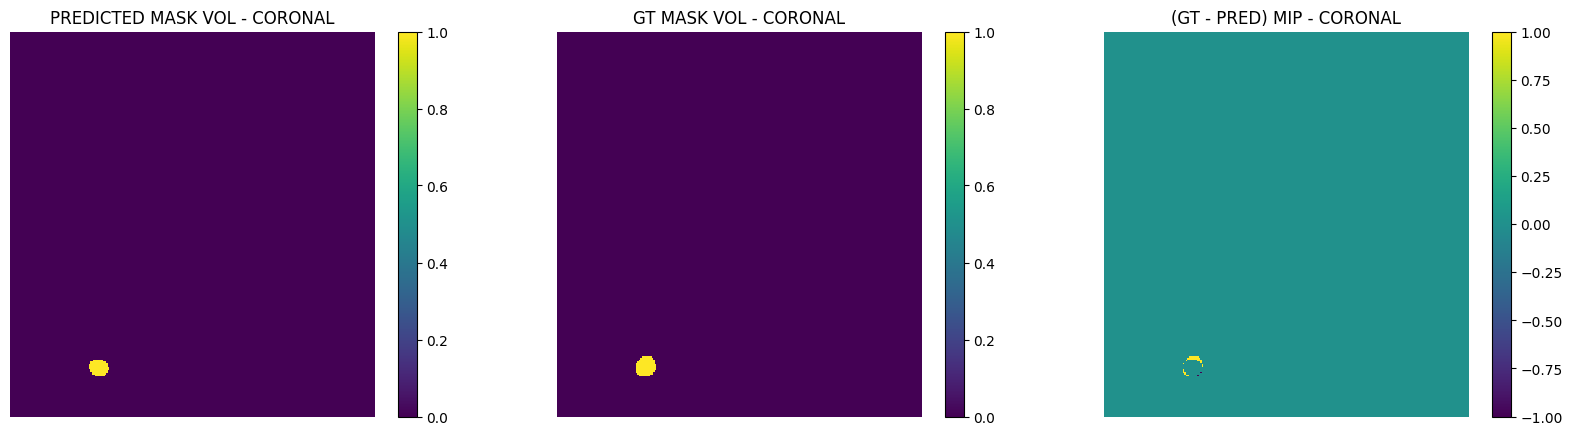

patient id: PSMA-01-367


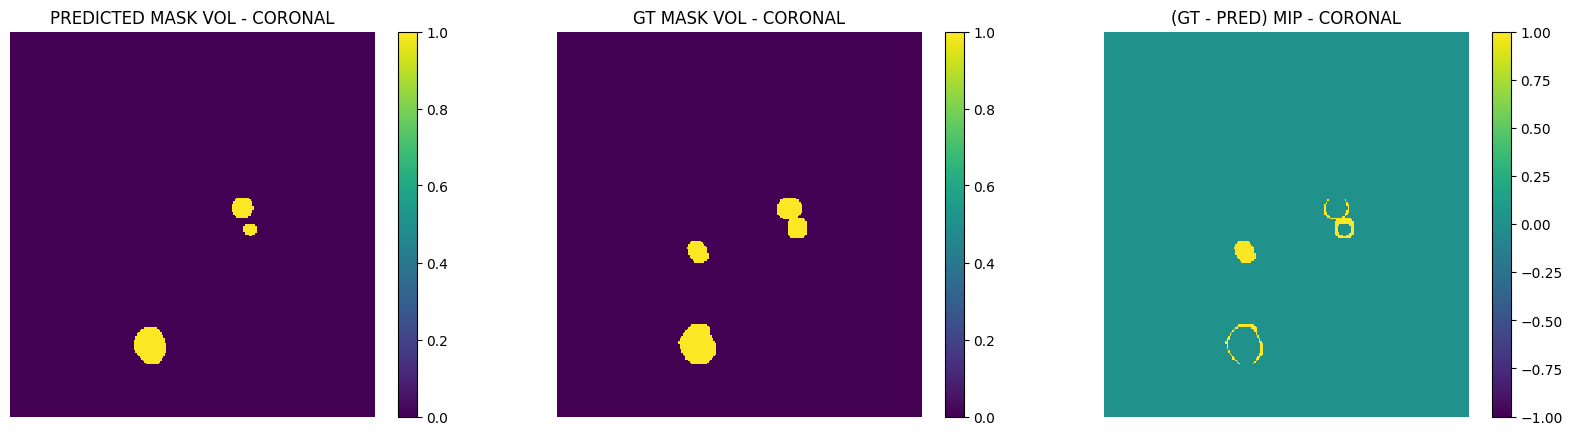

patient id: PSMA-01-371


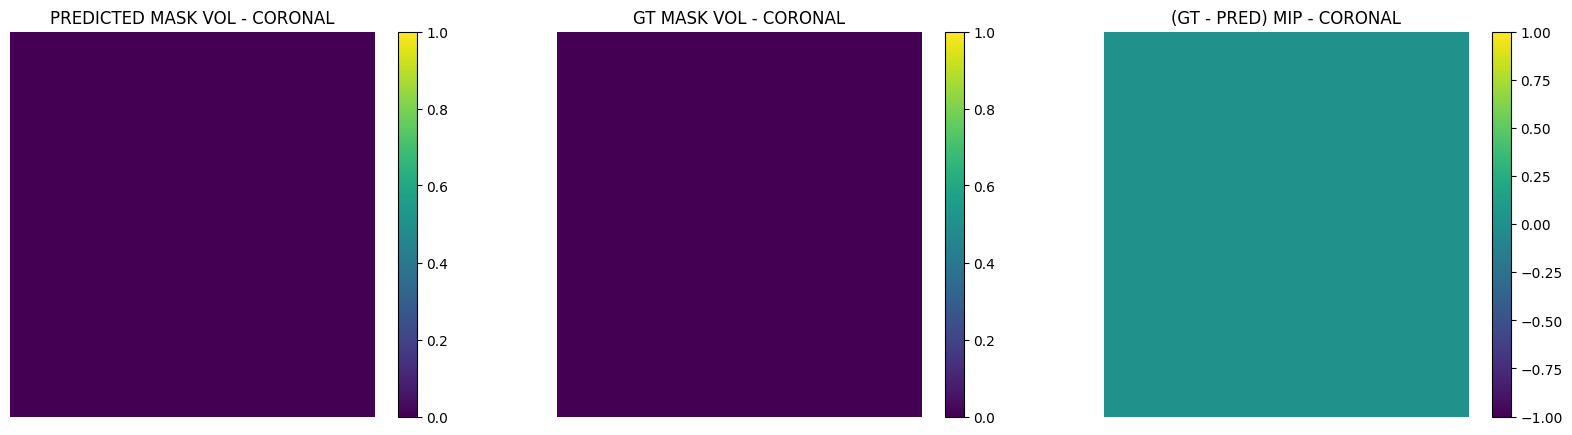

patient id: PSMA-01-371


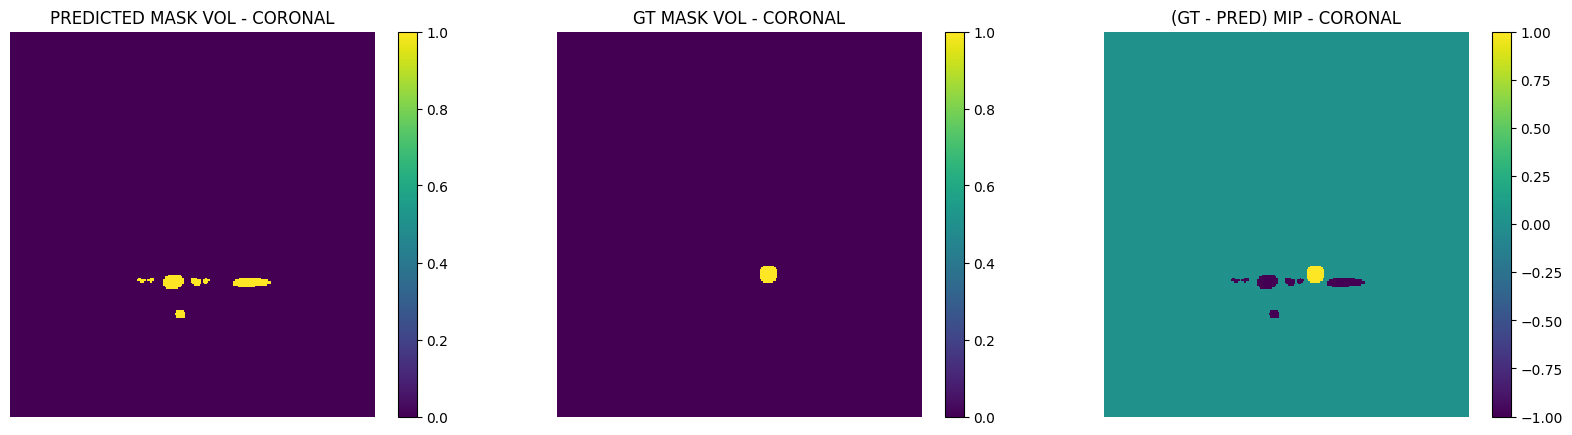

patient id: PSMA-01-377


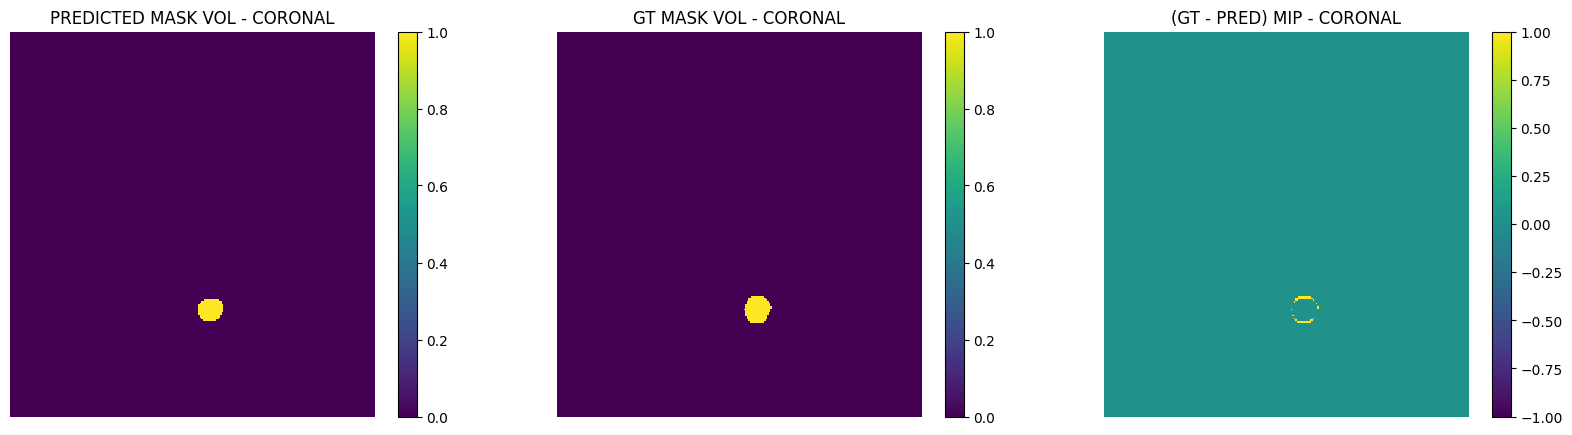

patient id: PSMA-01-377


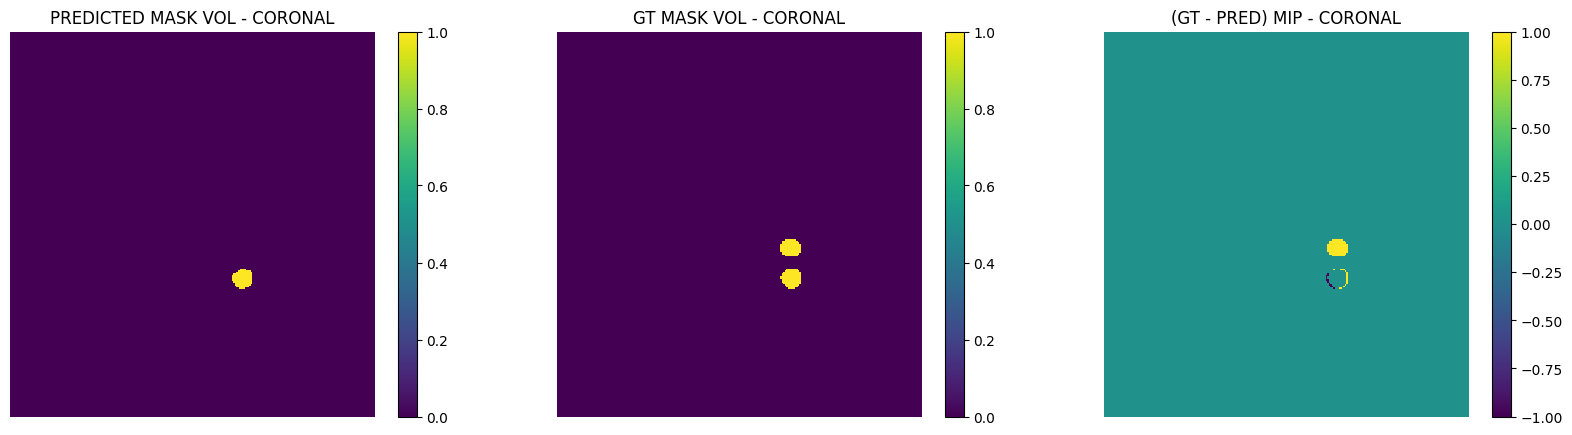

patient id: PSMA-01-382


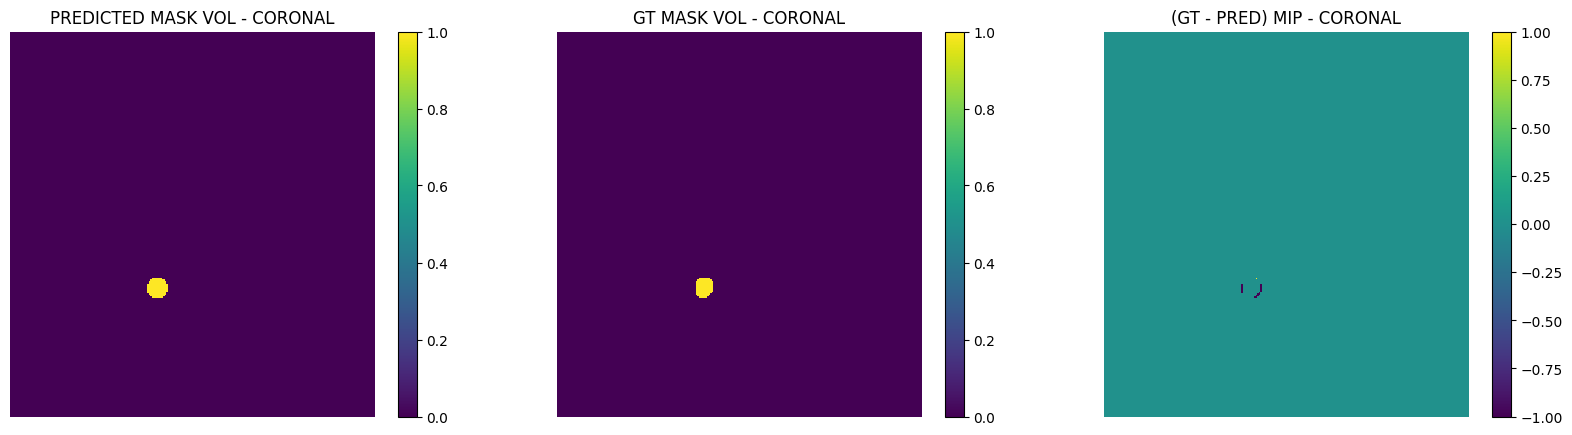

patient id: PSMA-01-382


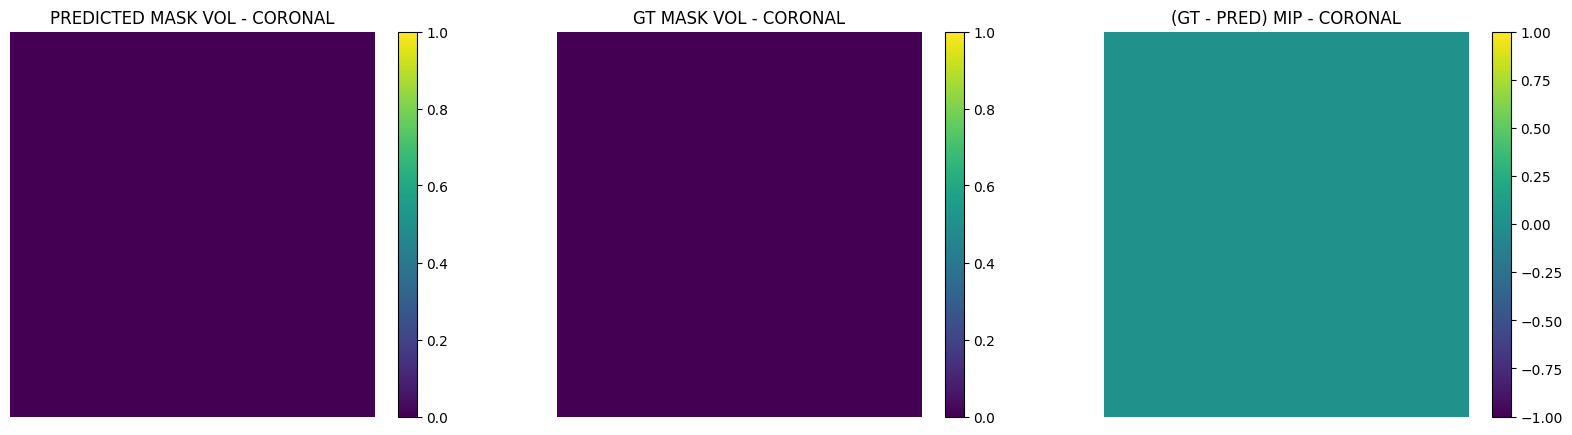

patient id: PSMA-01-420


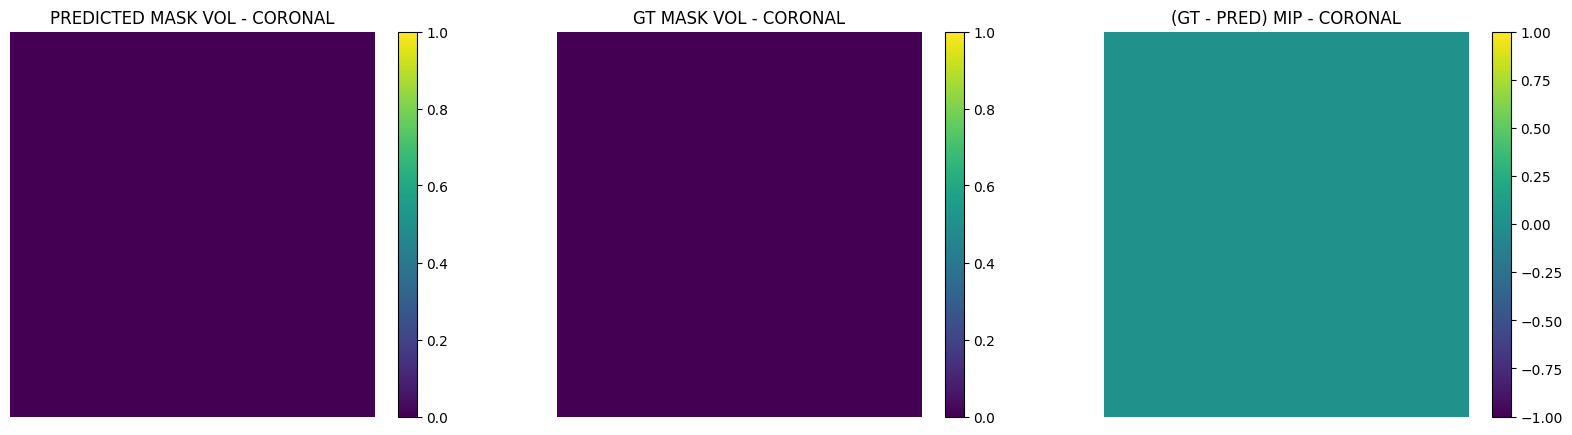

patient id: PSMA-01-420


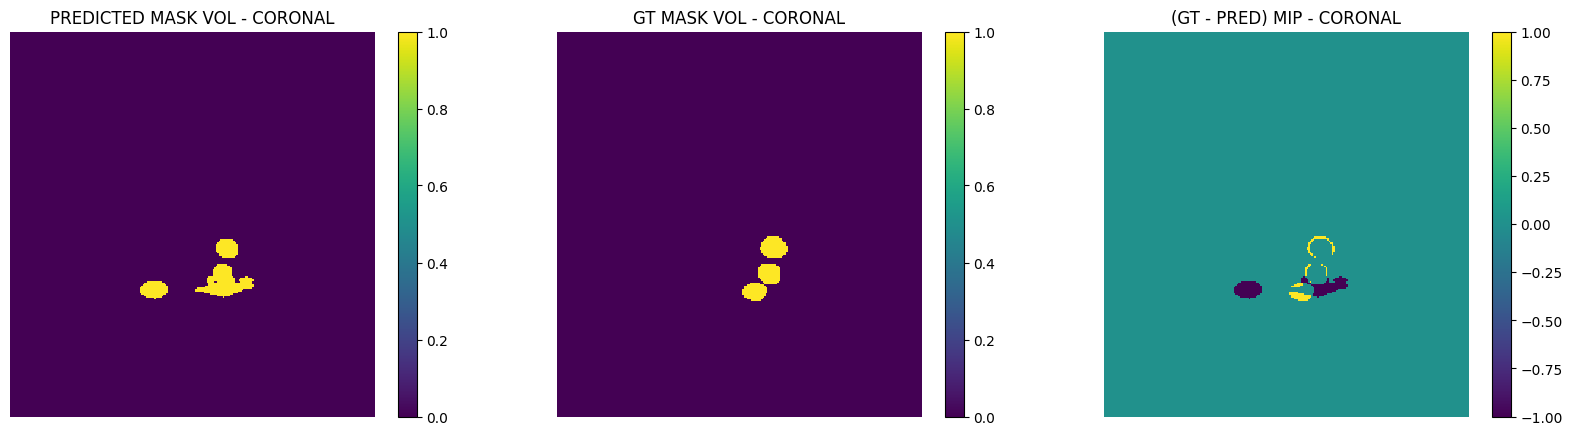

patient id: PSMA-01-429


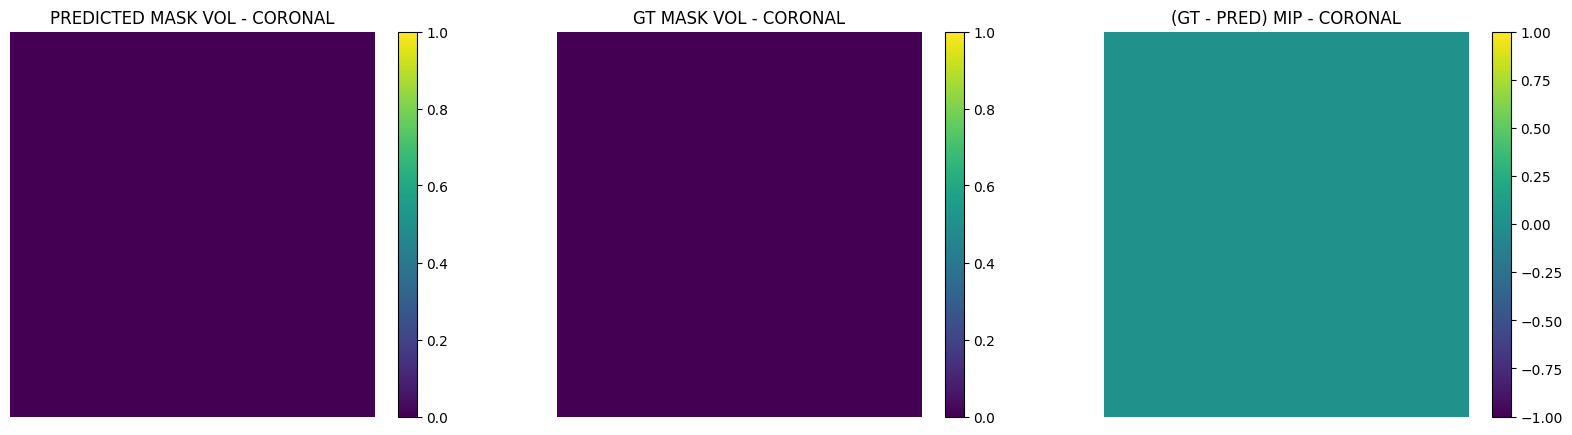

patient id: PSMA-01-429


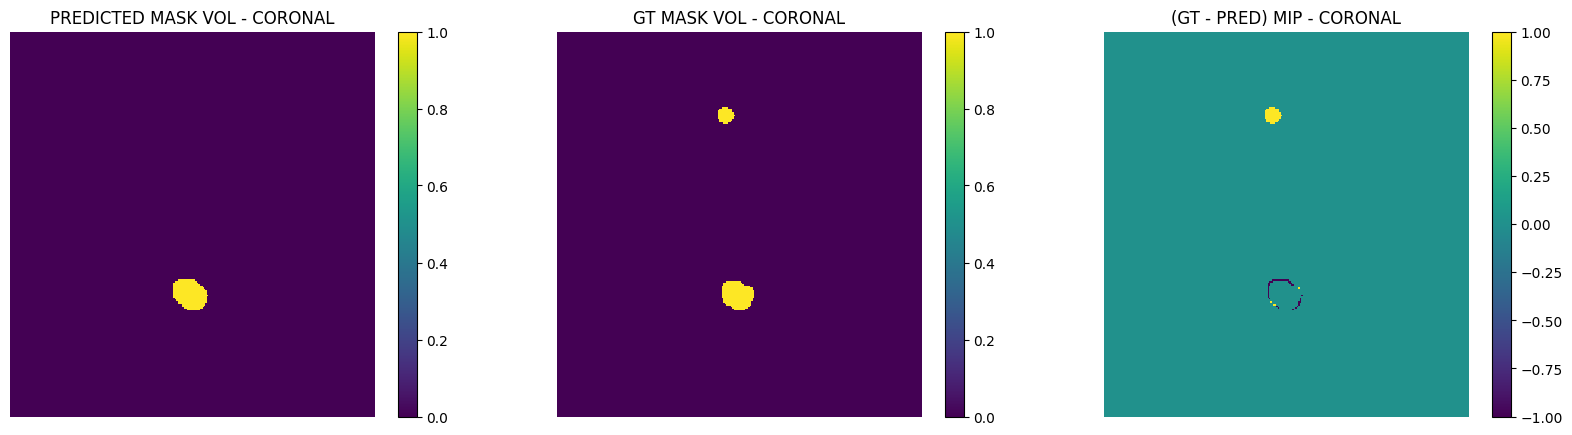

patient id: PSMA-01-453


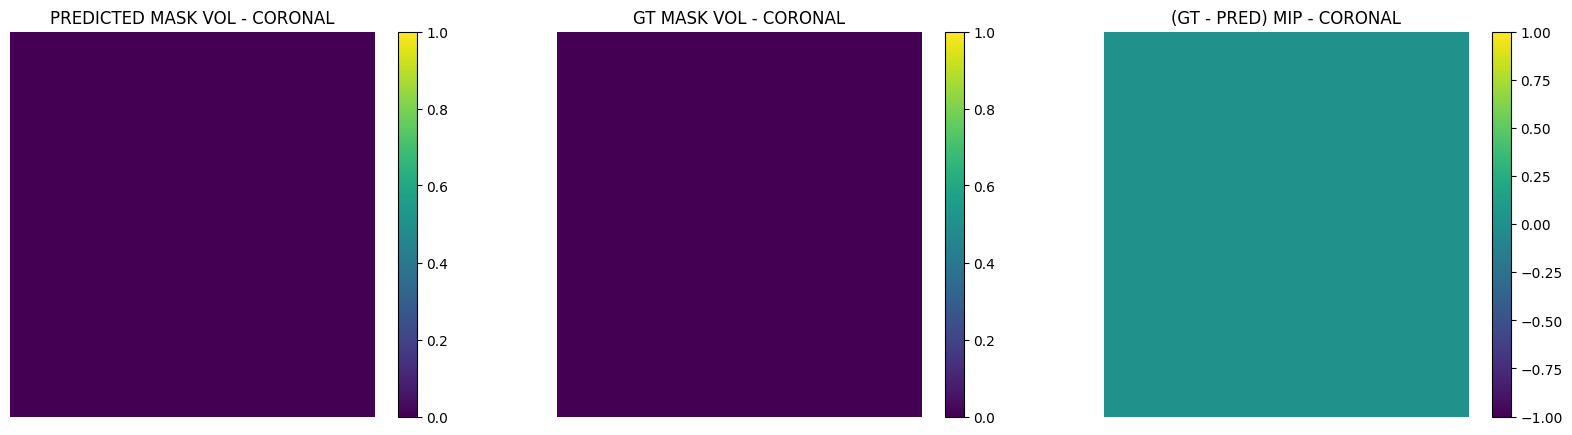

patient id: PSMA-01-453


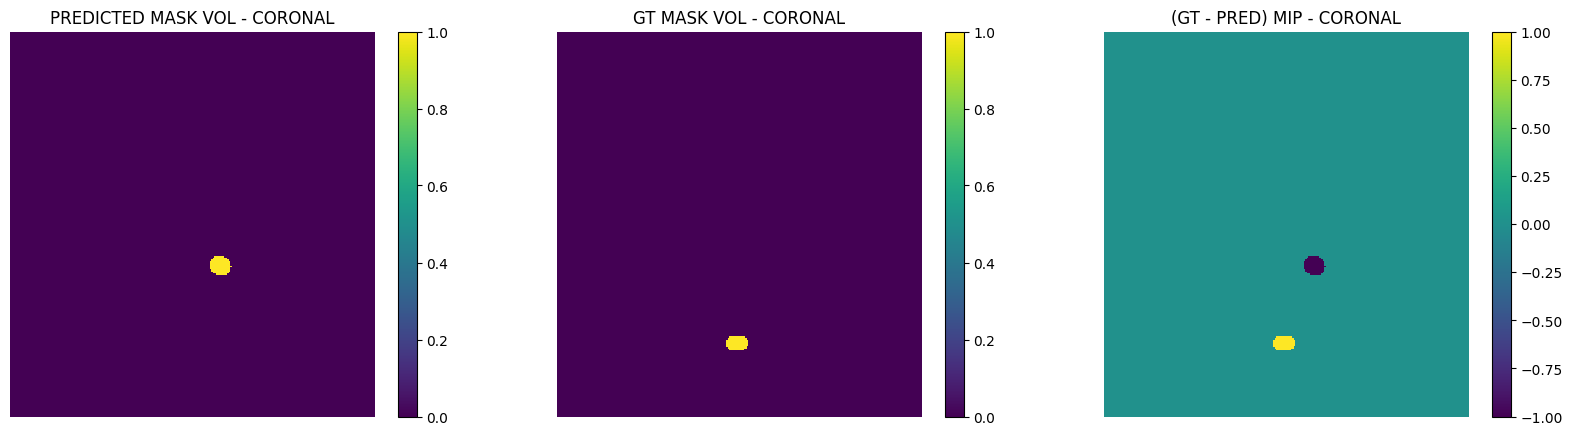

patient id: PSMA-01-457


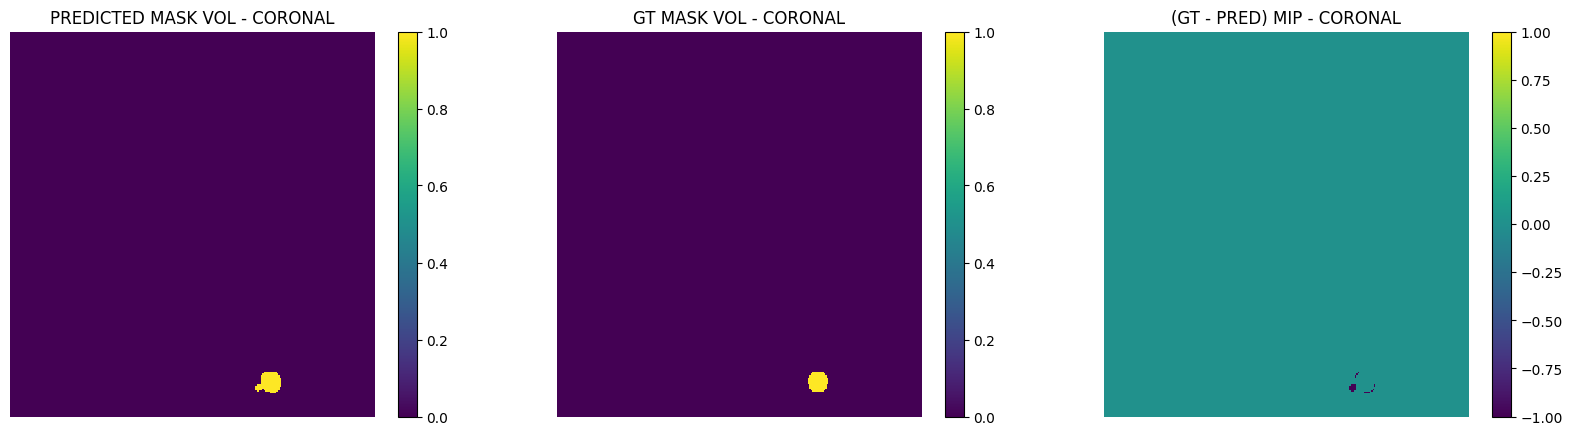

patient id: PSMA-01-457


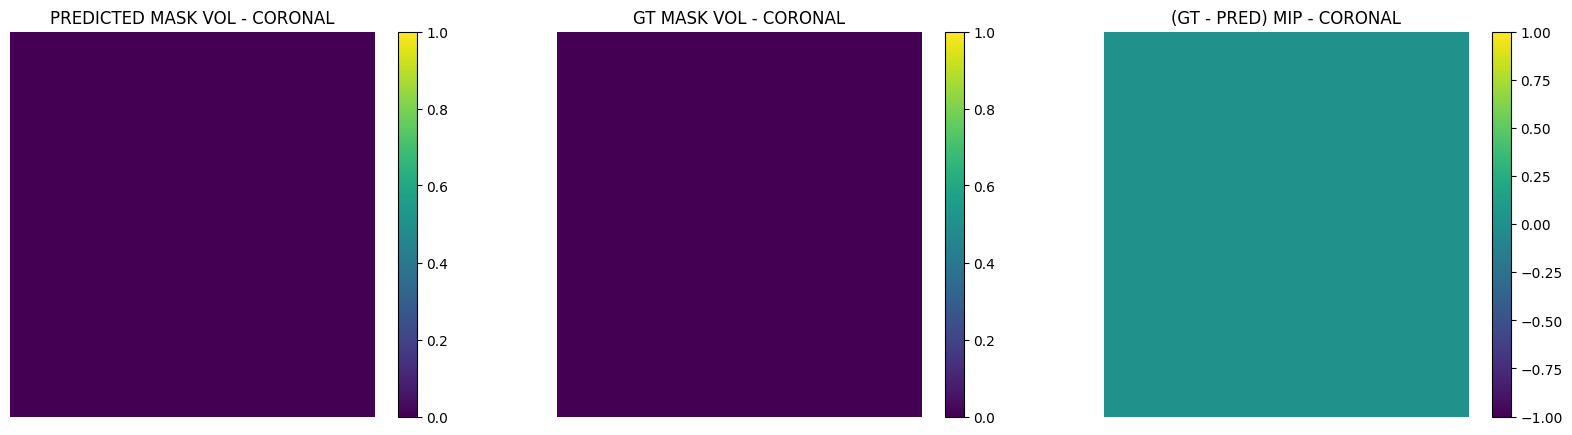

patient id: PSMA-01-478


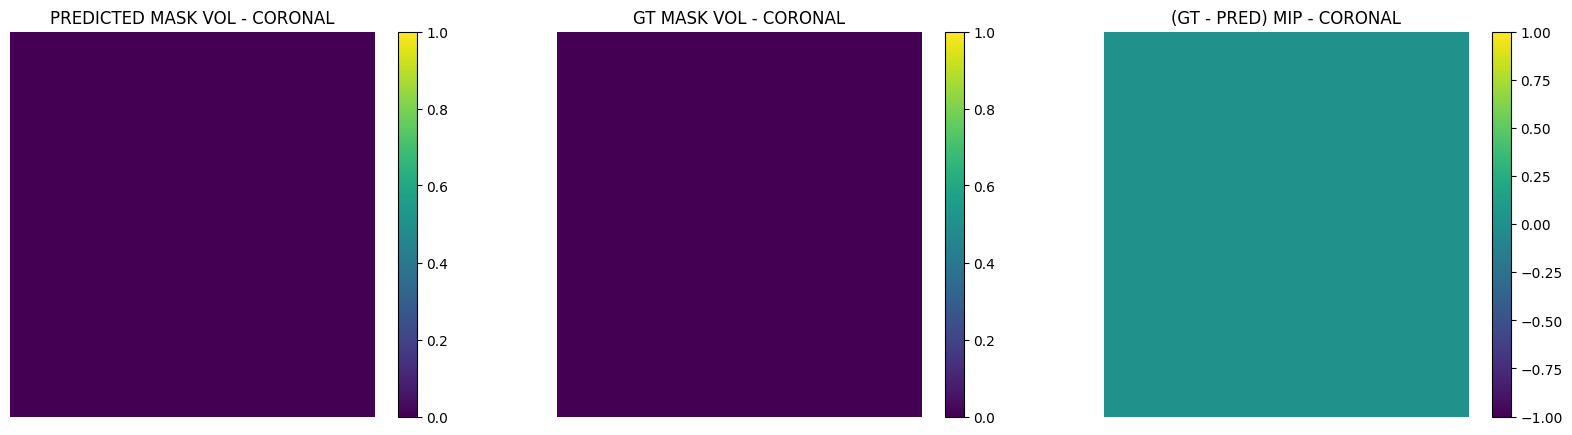

patient id: PSMA-01-478


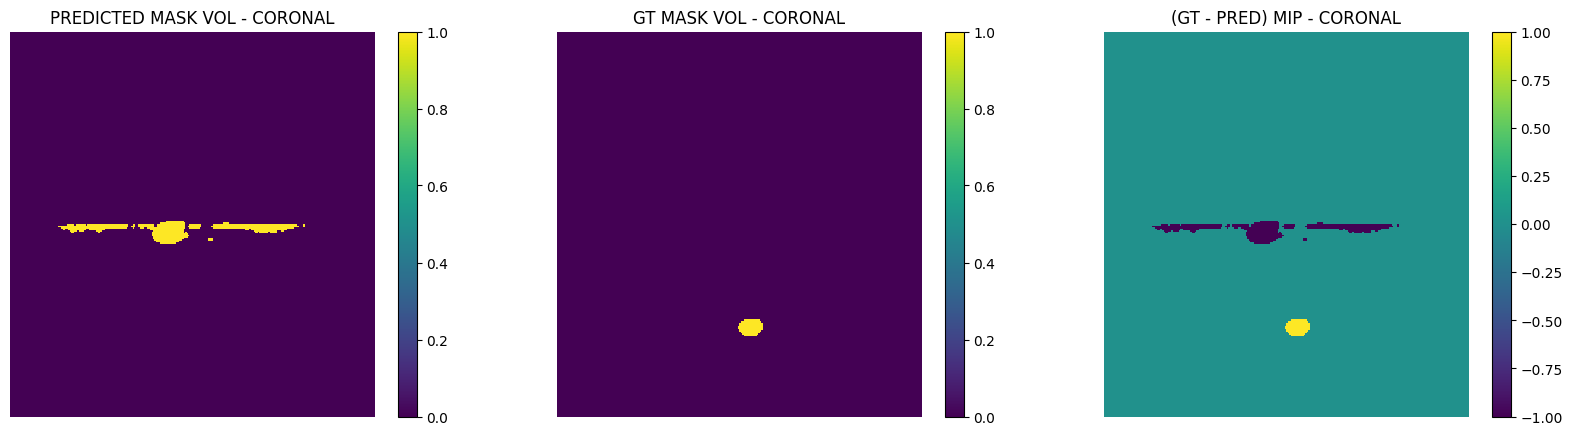

patient id: PSMA-01-492


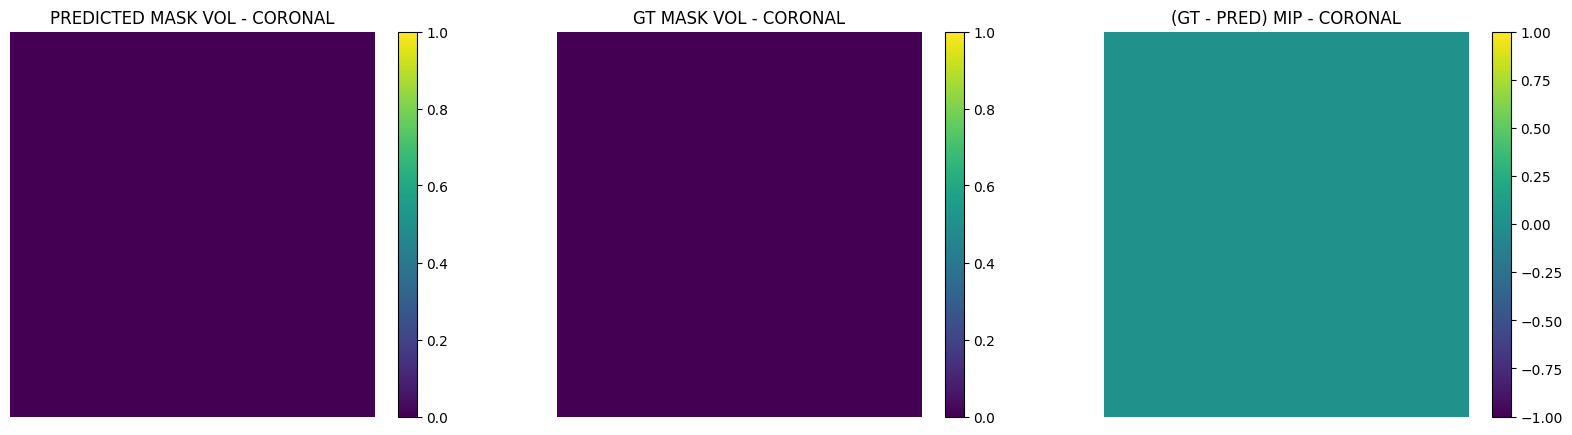

patient id: PSMA-01-492


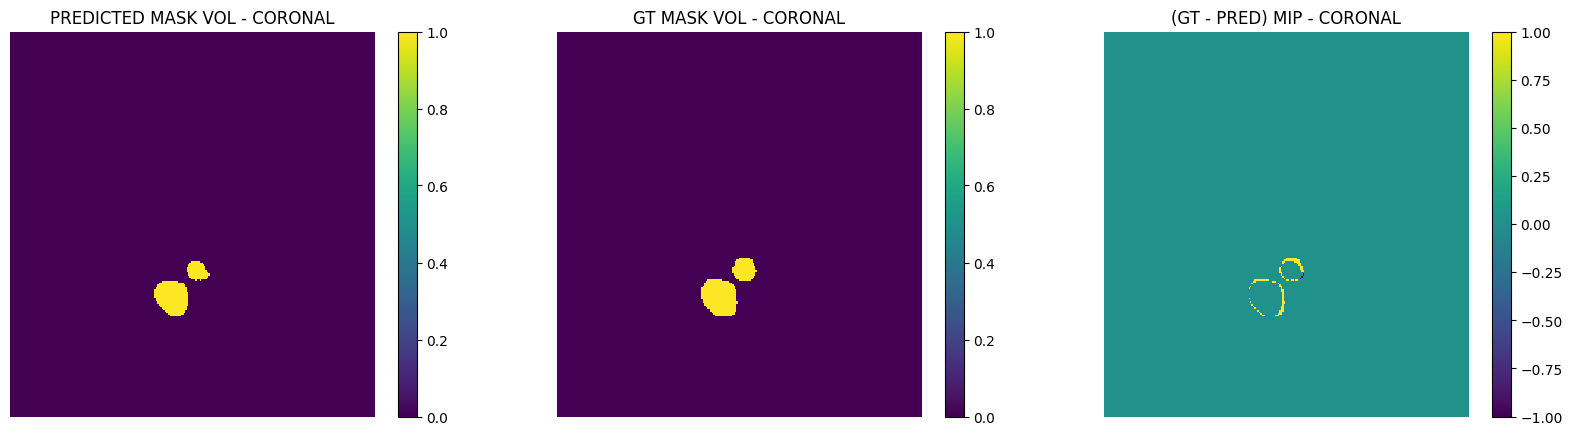

patient id: PSMA-01-502


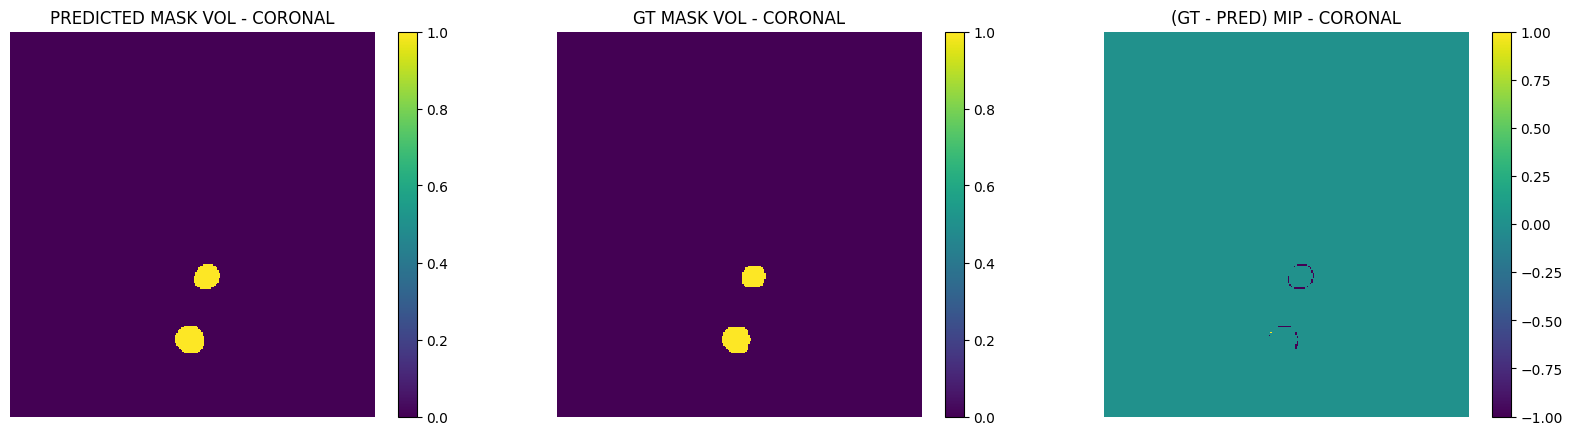

patient id: PSMA-01-502


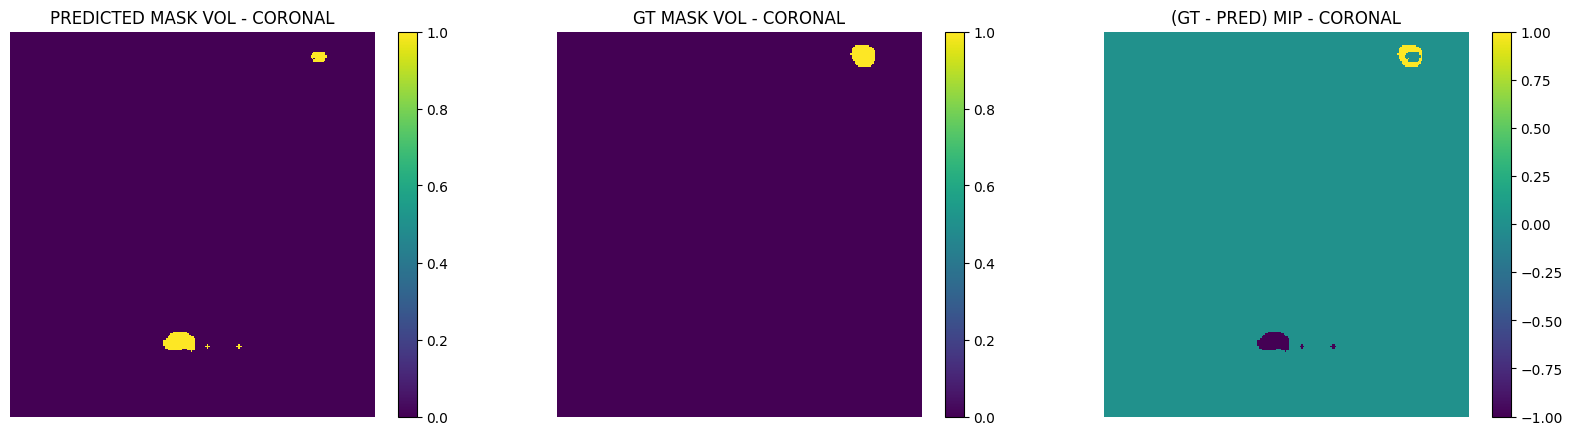

patient id: PSMA-01-512


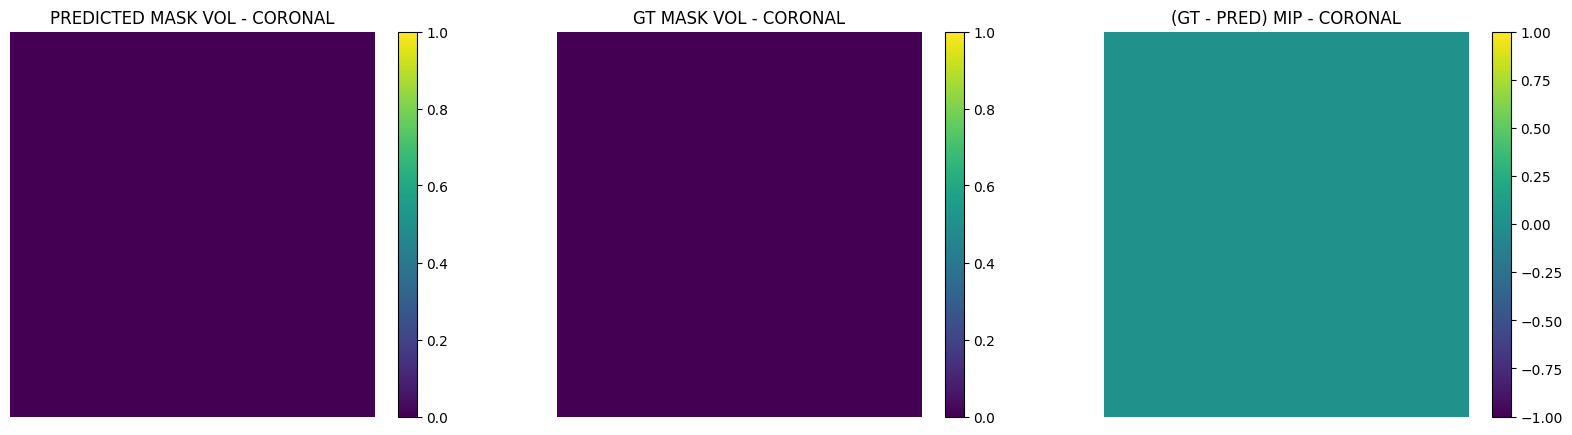

patient id: PSMA-01-512


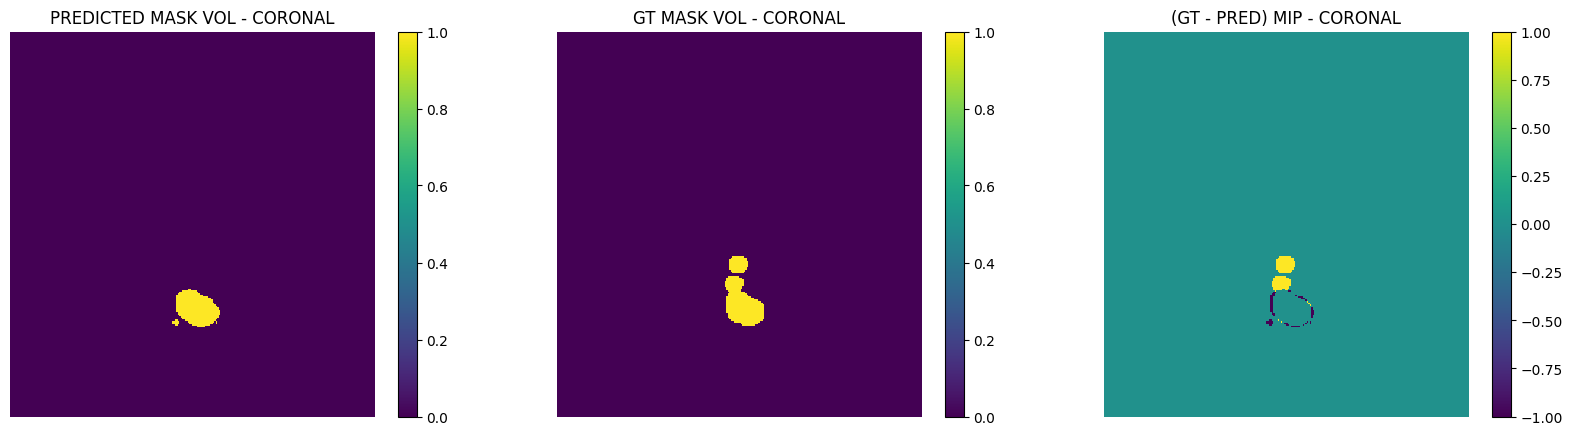

patient id: PSMA-01-520


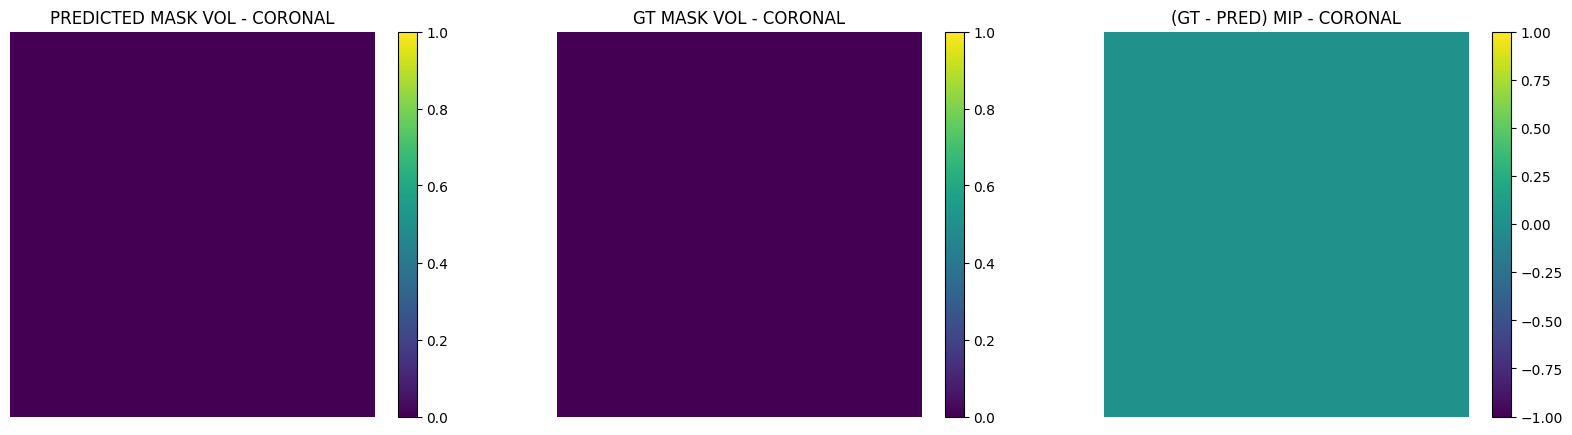

patient id: PSMA-01-520


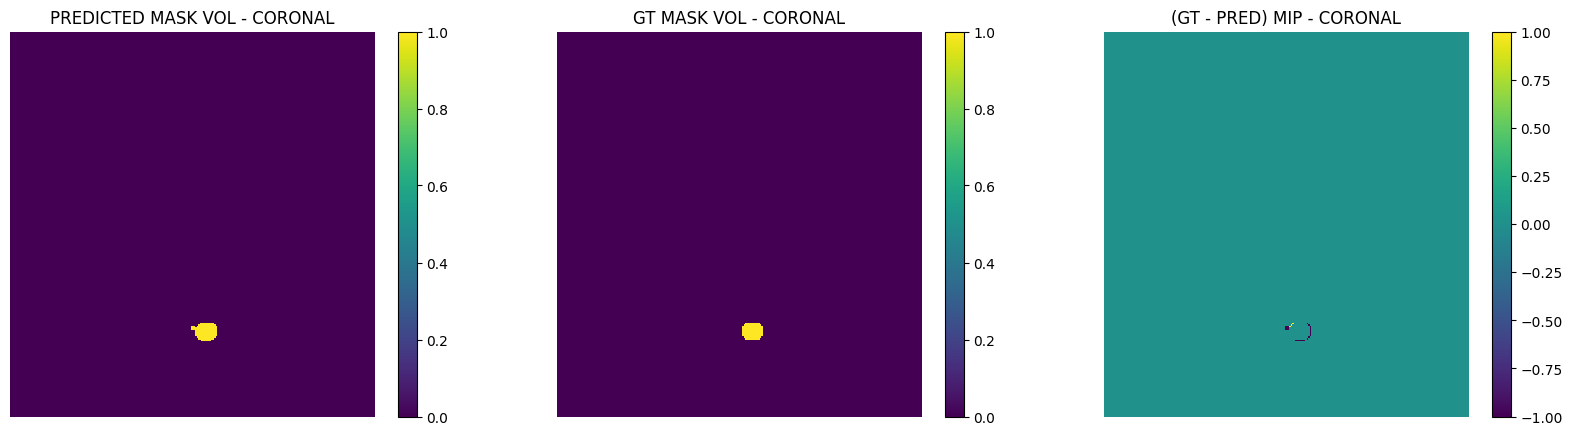

patient id: PSMA-01-534


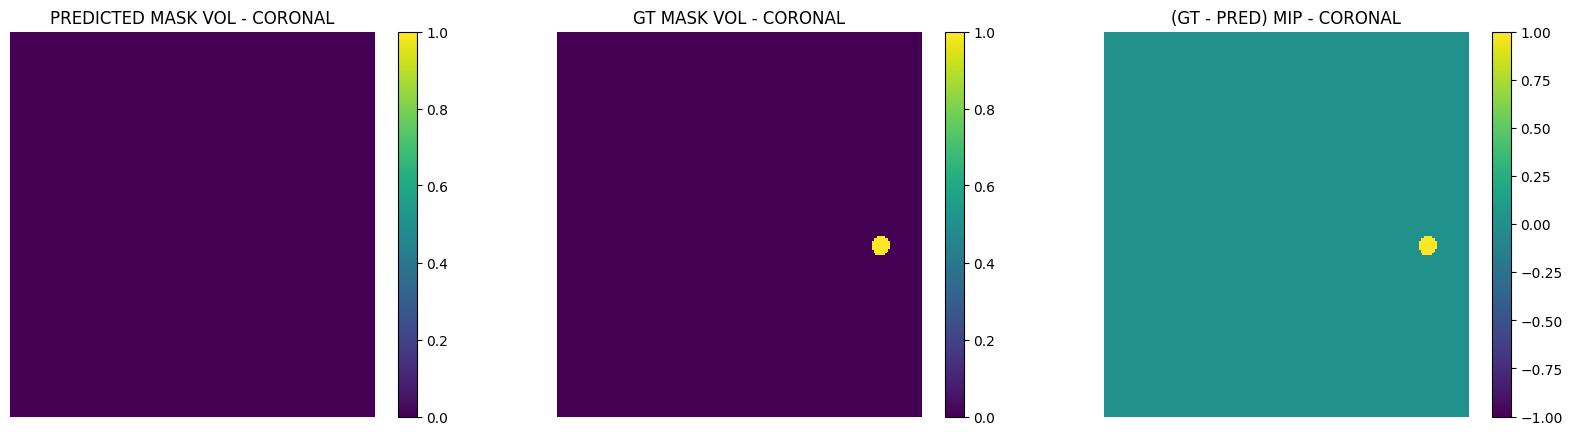

patient id: PSMA-01-534


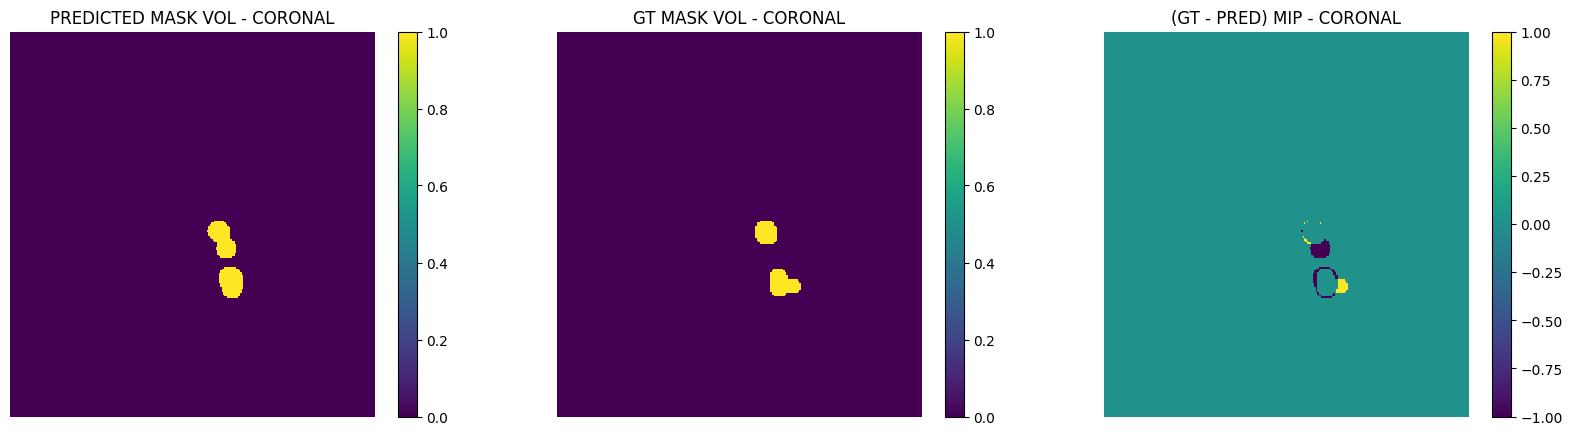

patient id: PSMA-01-545


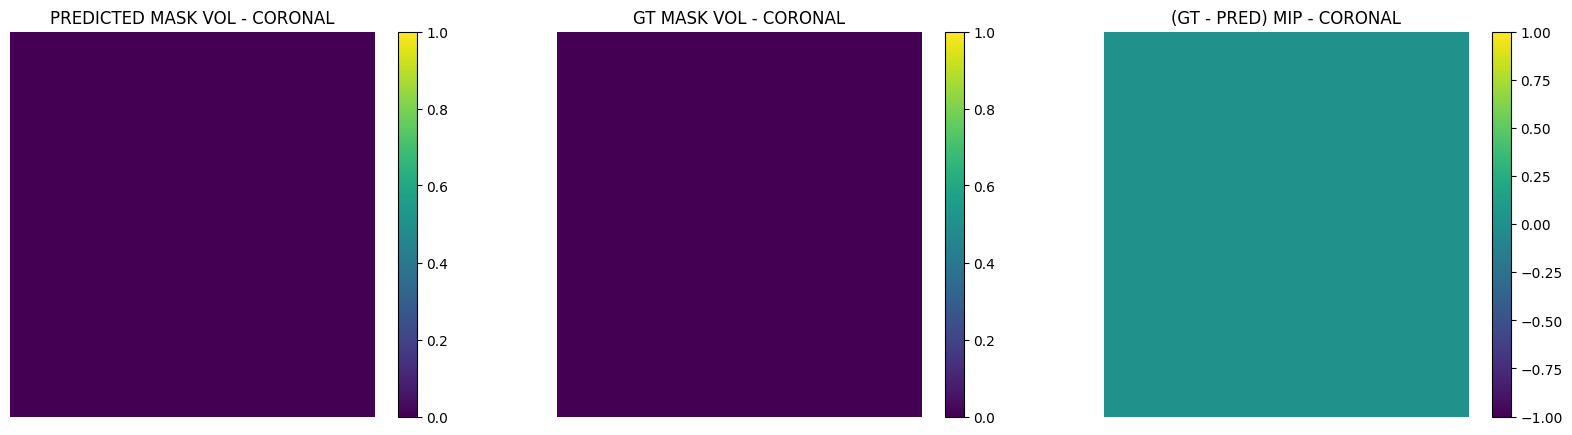

patient id: PSMA-01-545


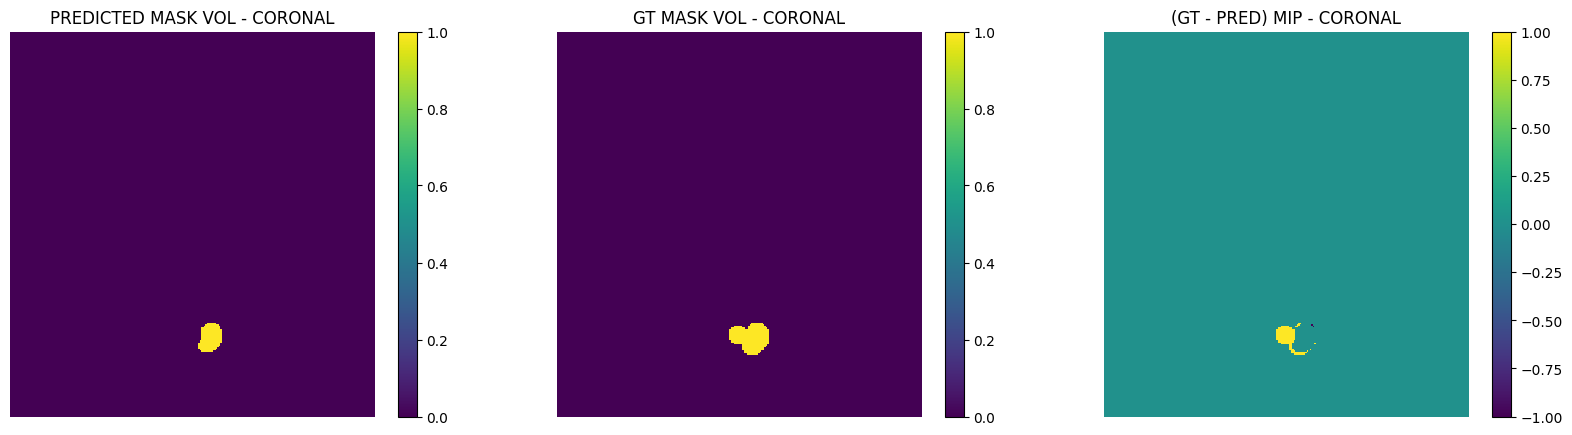

patient id: PSMA-01-560


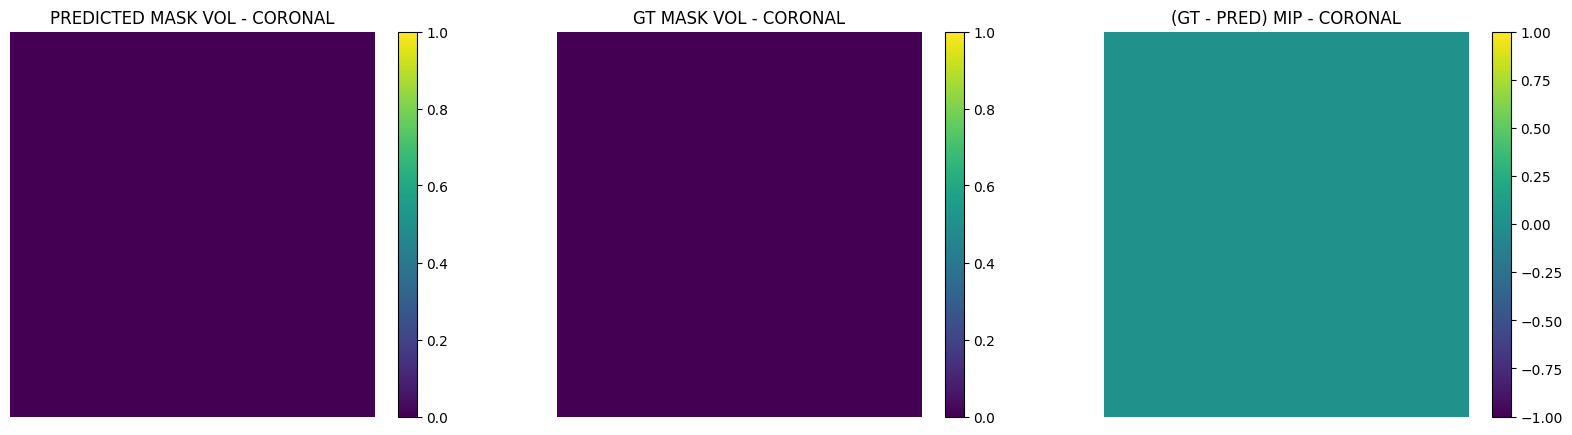

patient id: PSMA-01-560


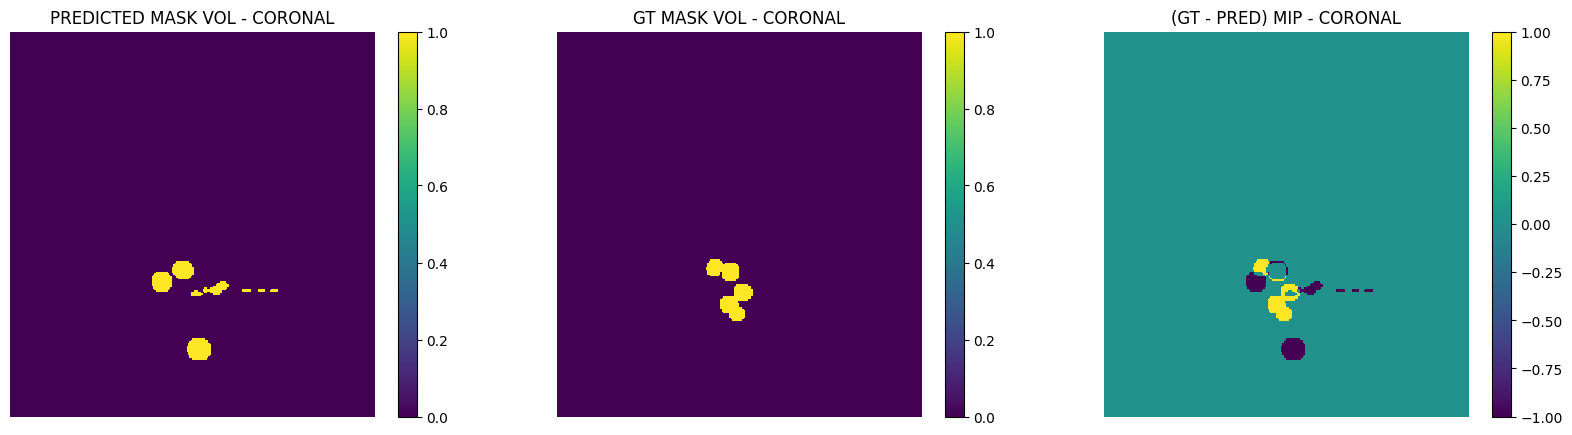

patient id: PSMA-01-605


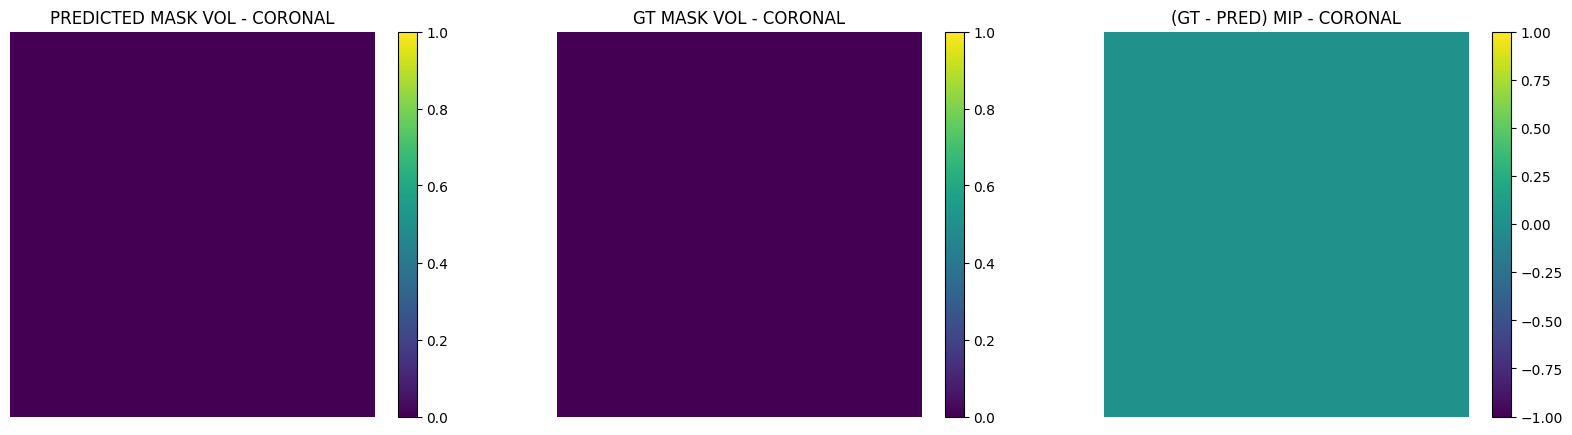

patient id: PSMA-01-605


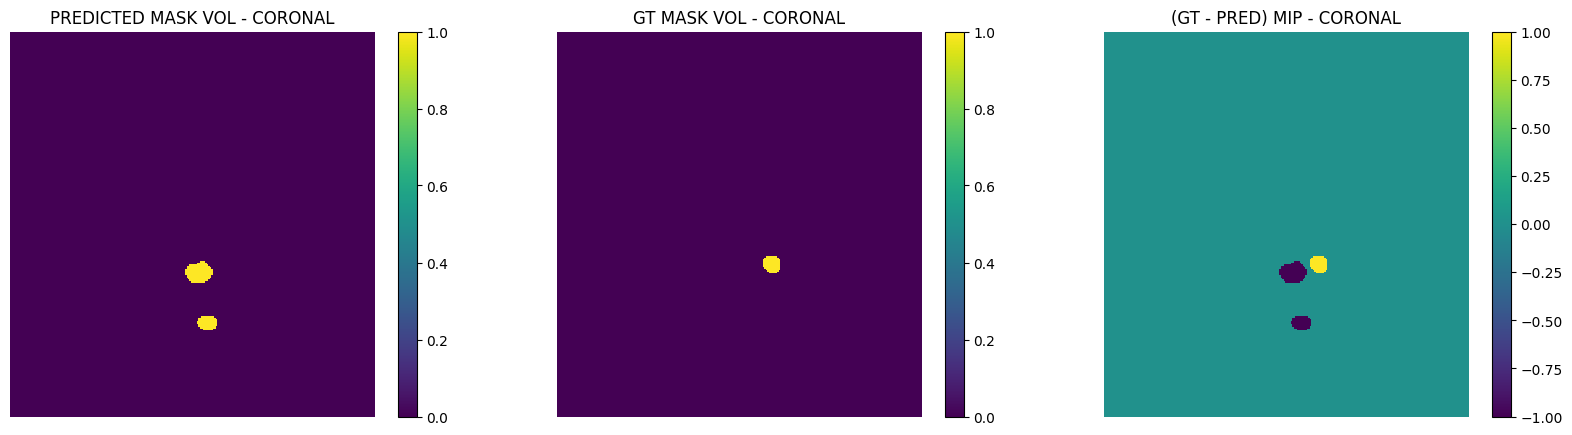

patient id: PSMA-01-644


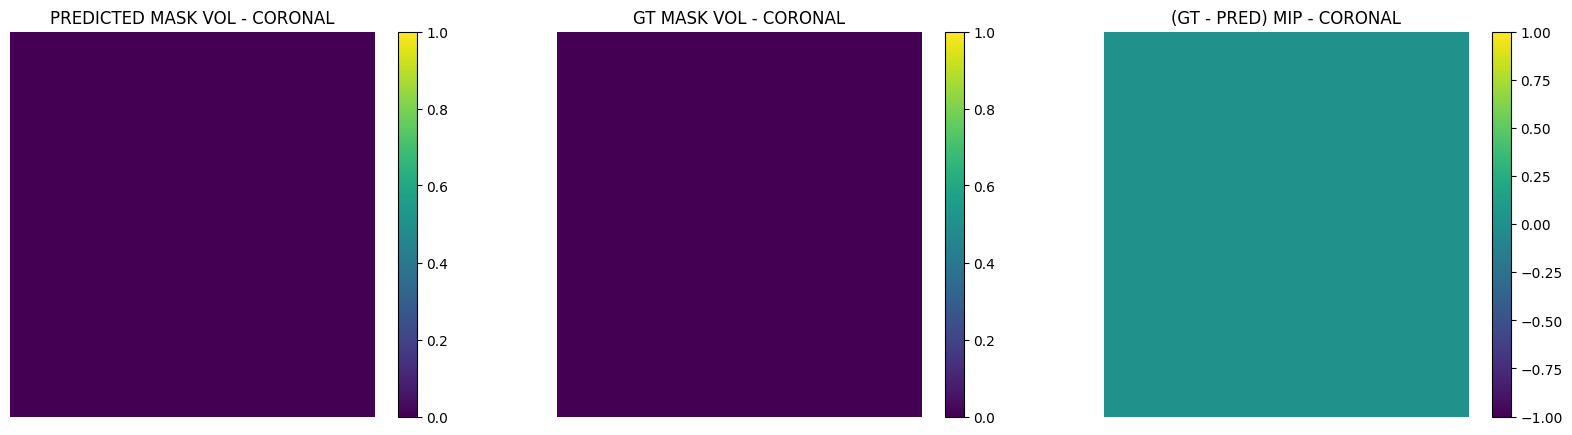

patient id: PSMA-01-644


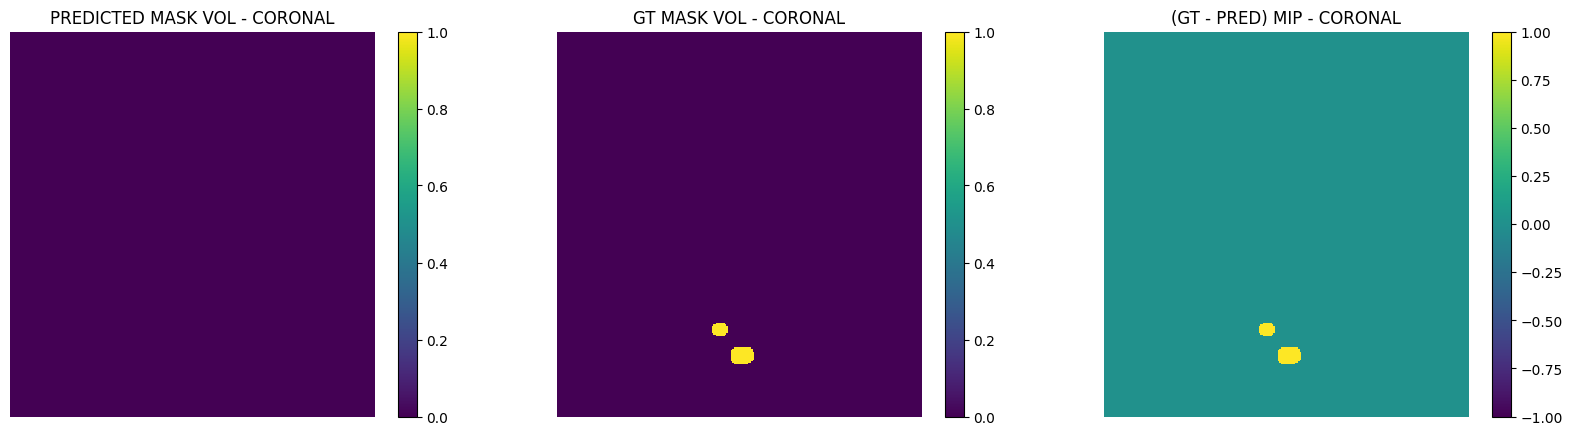

patient id: PSMA-01-707


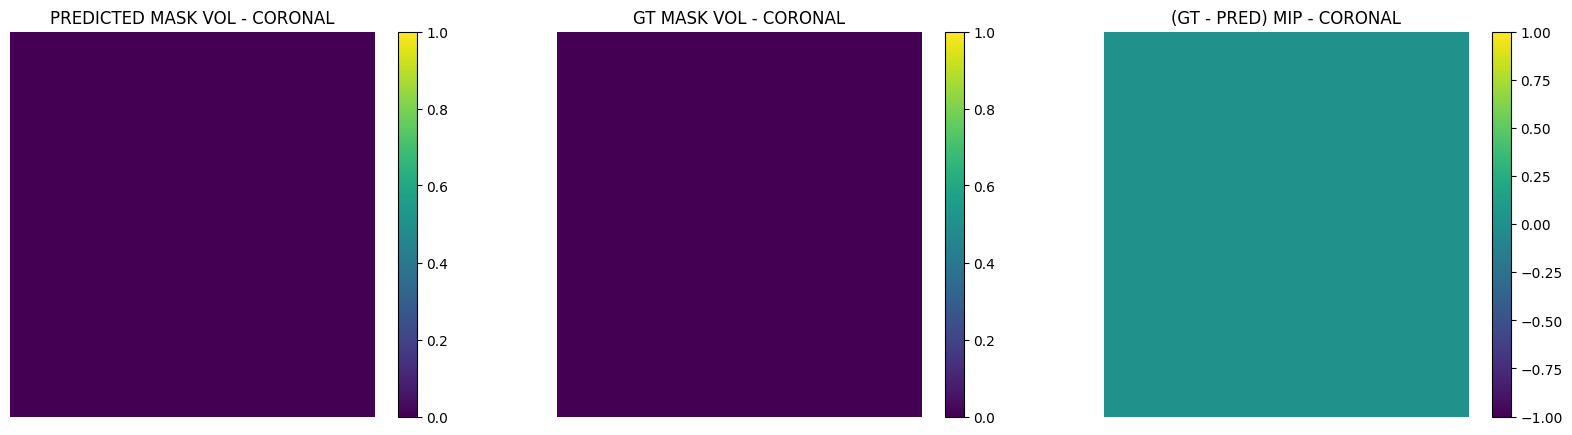

patient id: PSMA-01-707


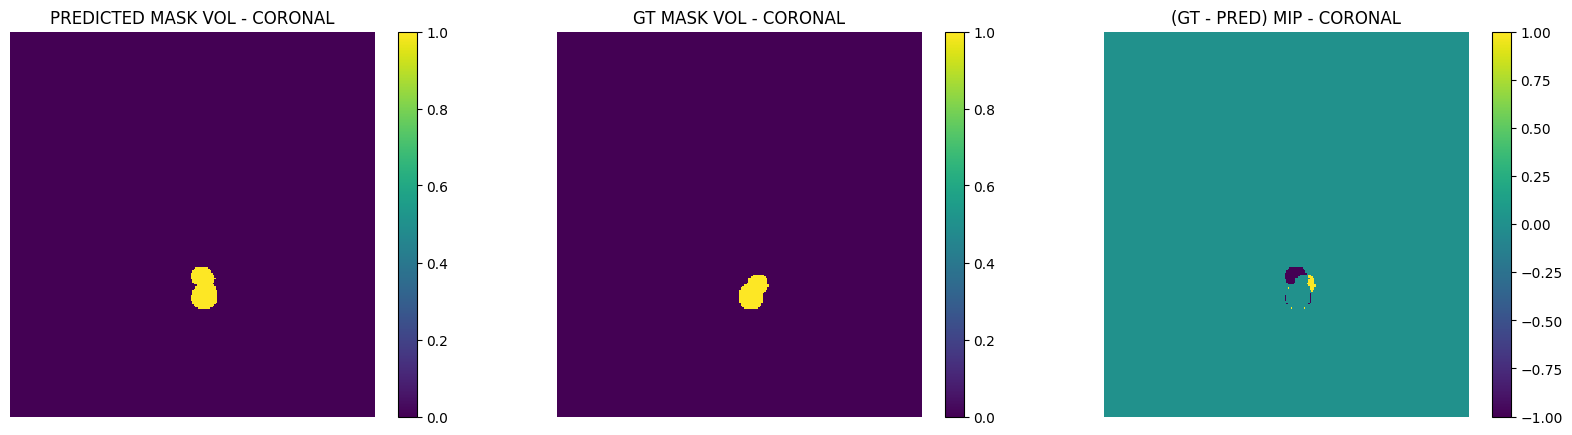

patient id: PSMA-01-767


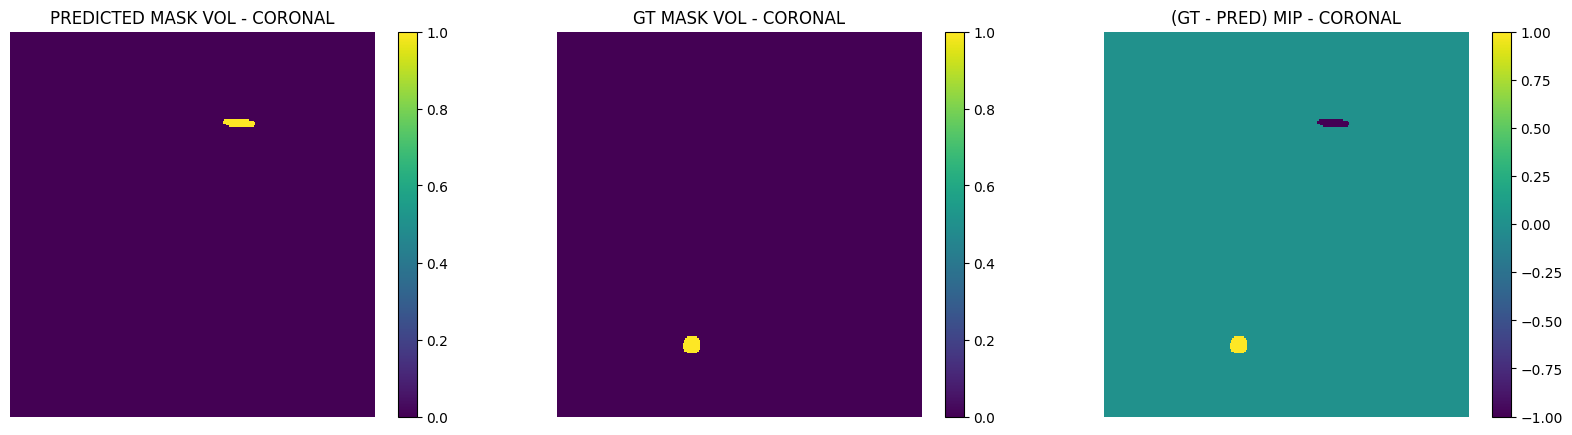

patient id: PSMA-01-767


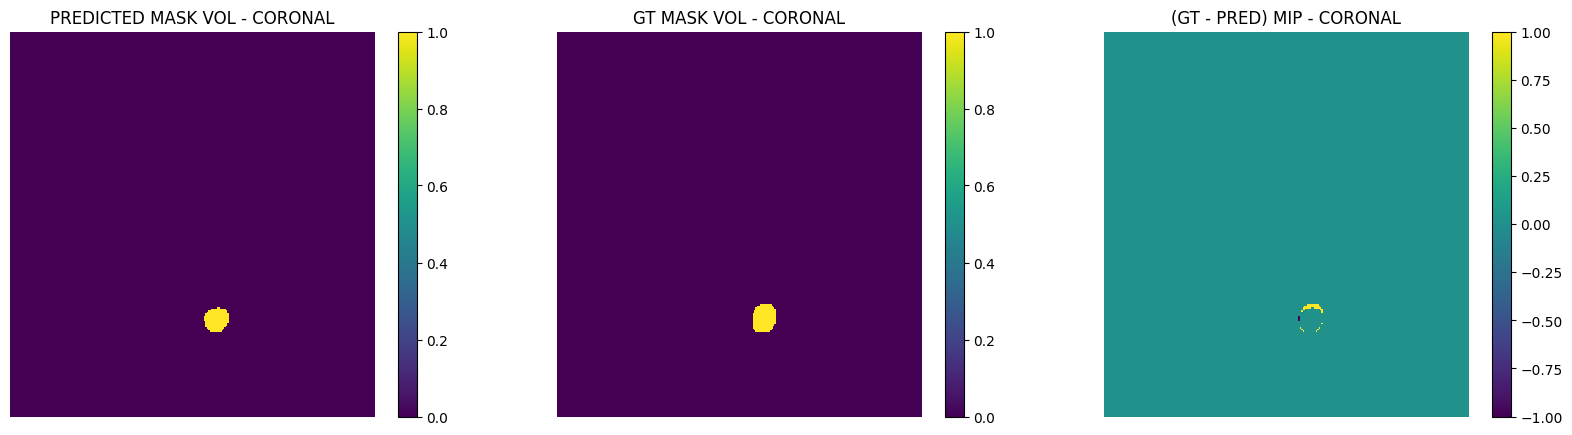

patient id: PSMA-01-775


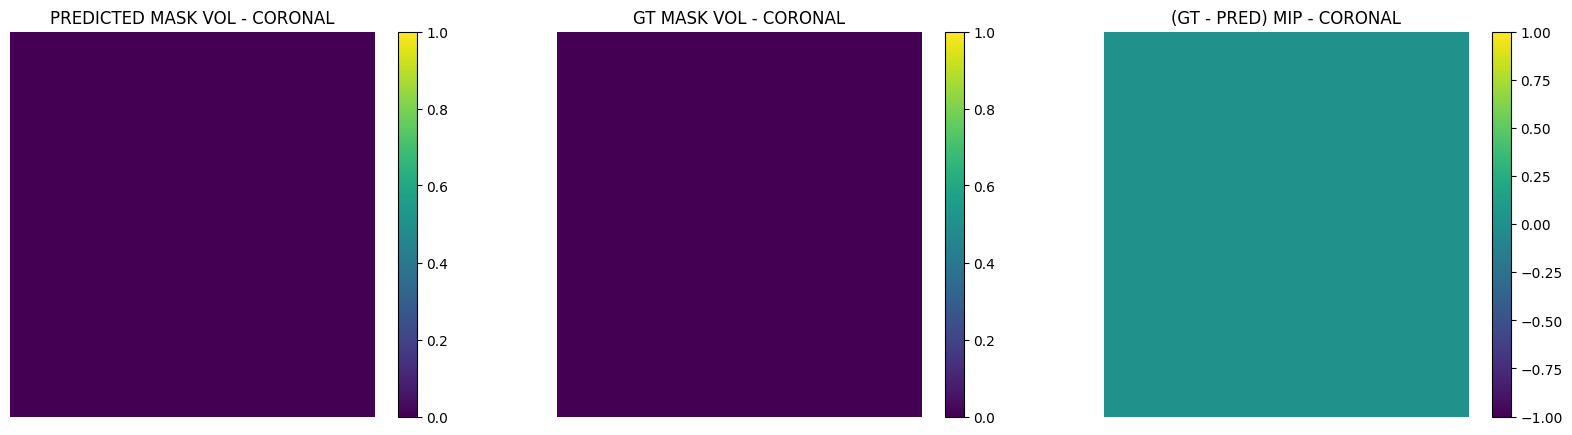

patient id: PSMA-01-775


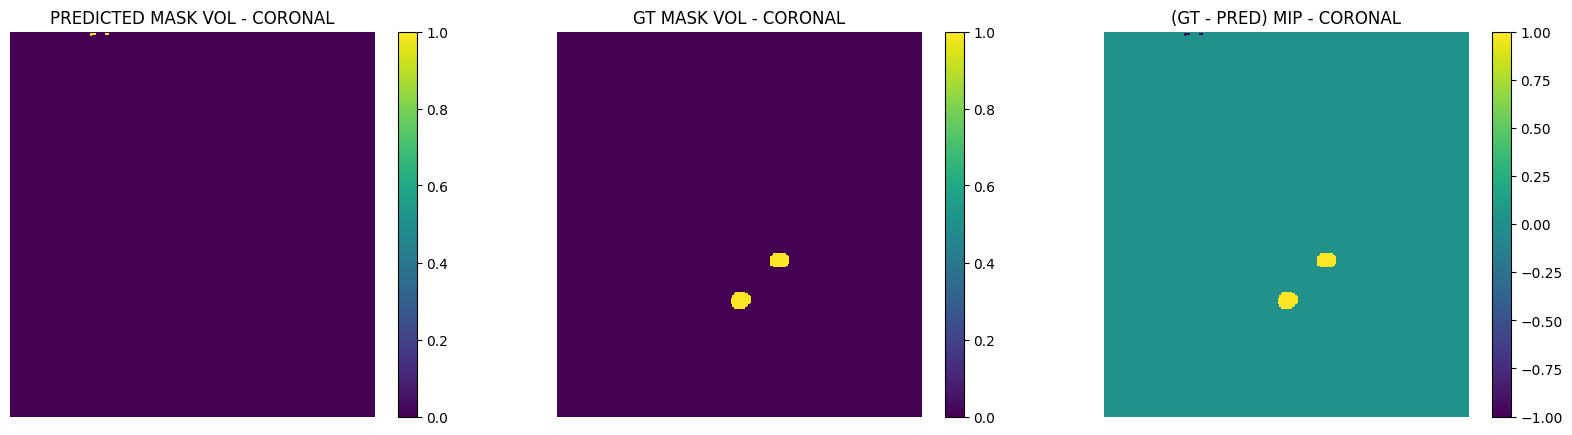

patient id: PSMA-01-787


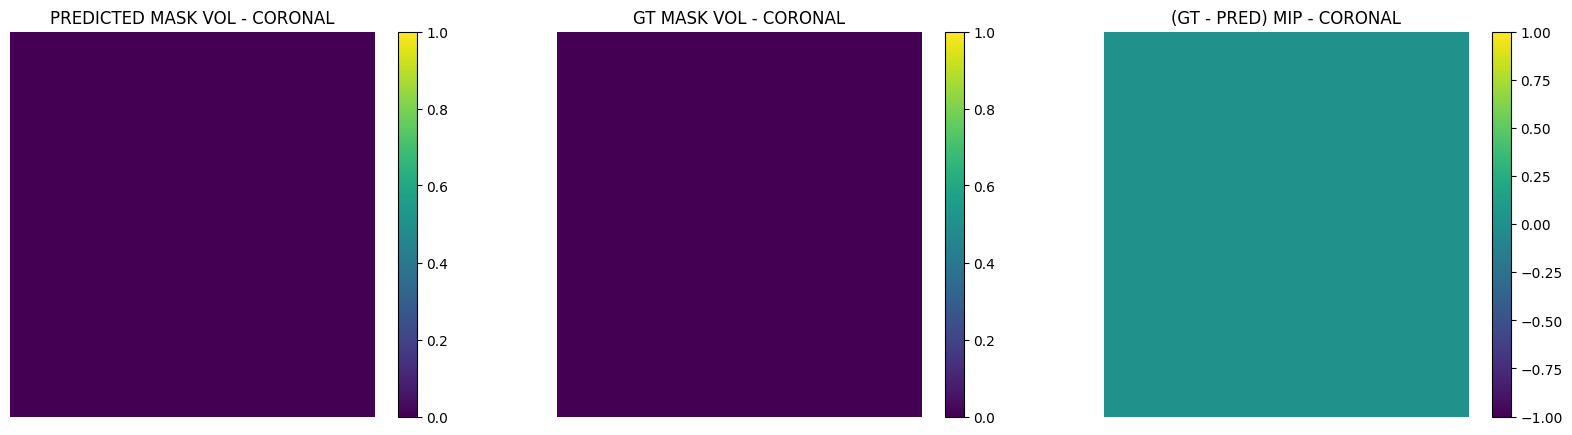

patient id: PSMA-01-787


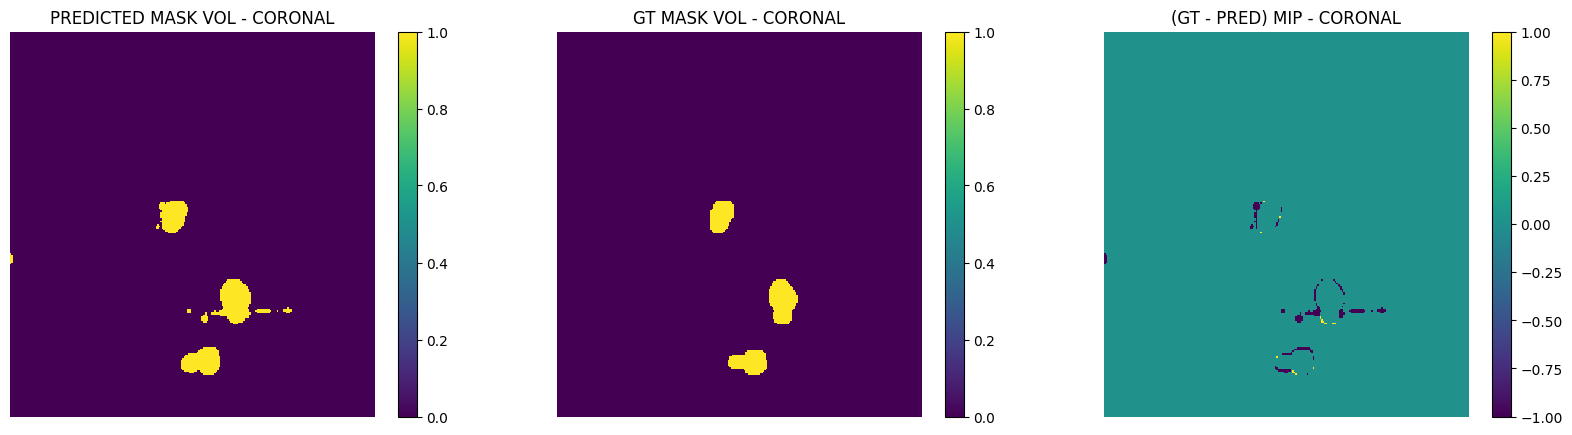

patient id: PSMA-01-982


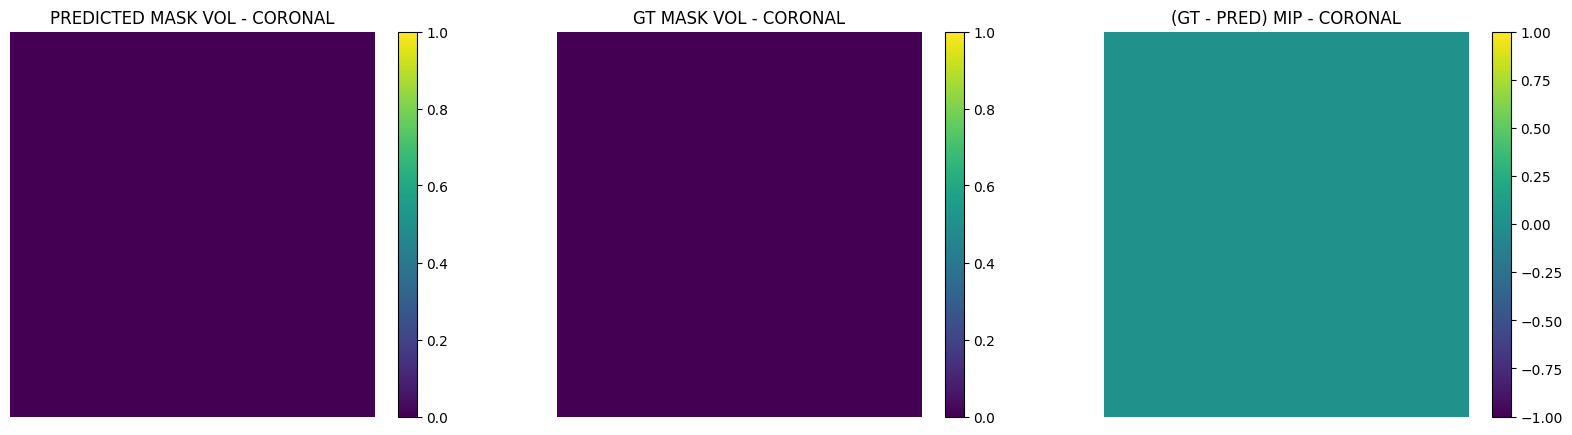

patient id: PSMA-01-982


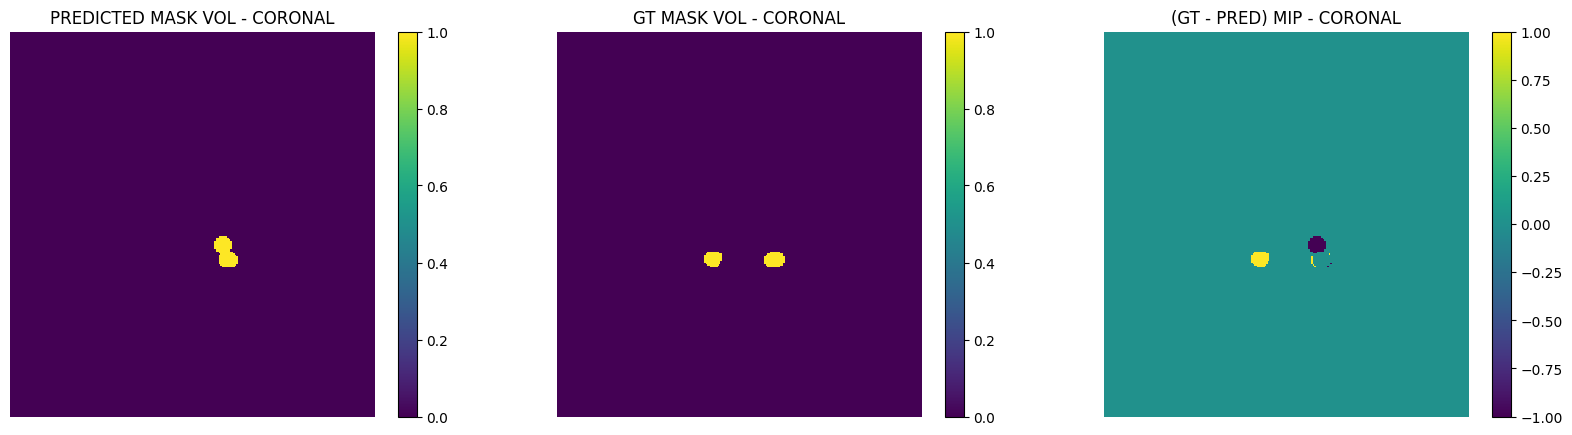

Threshold: 0.0017 | avg Dice: 0.5317365821094926


In [7]:
save_root = "/datassd/DET_SEG_REC/MASK_VOLS"
GT_vol_save_dir = os.path.join(save_root, "GT_VOLS")
PRED_vol_save_dir = os.path.join(save_root, "PRED_VOLS")

patients_list = os.listdir(GT_vol_save_dir)
patients_list = sorted(patients_list)
threshold = 0.0017
# for threshold in np.linspace(0.0001, 0.002, 20, endpoint=True):
# print(threshold)
dice_list = list()
for patient_id in patients_list:
    for top_bottom in ["01", "02"]:
        gt_vol = np.load(os.path.join(GT_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
        pred_vol = np.load(os.path.join(PRED_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
        gt_binary = np.zeros_like(gt_vol)
        pred_binary = np.zeros_like(pred_vol)

        gt_binary[gt_vol[...]/255.0 >= threshold] = 1
        gt_binary[gt_vol[...]/255.0 < threshold] = 0

        pred_binary[pred_vol[...]/255.0 >= threshold] = 1
        pred_binary[pred_vol[...]/255.0 < threshold] = 0
        
        if gt_binary.max() != 0:
            dice = dice_score(gt_binary, pred_binary)
            dice_list.append(dice)
            
            
        print(f"patient id: {patient_id}")    
        plt.subplots(1,3,figsize=(20,5))

        plt.subplot(131)
        plt.pcolormesh(np.max(pred_binary, axis=1).T, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar()
        plt.axis('off')
        plt.title('PREDICTED MASK VOL - CORONAL')

        plt.subplot(132)
        plt.pcolormesh(np.max(gt_binary, axis=1).T, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar()
        plt.axis('off')
        plt.title('GT MASK VOL - CORONAL')

        plt.subplot(133)
        plt.pcolormesh((np.max(gt_binary, axis=1).T - np.max(pred_binary, axis=1).T), cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.axis('off')
        plt.title('(GT - PRED) MIP - CORONAL')
        plt.show()

        # plt.subplots(1,3,figsize=(20,5))

        # plt.subplot(131)
        # plt.pcolormesh(np.max(pred_binary, axis=1).T, cmap='magma')
        # plt.colorbar()
        # plt.axis('off')
        # plt.title('PREDICTED MASK VOL - SAGITTAL')

        # plt.subplot(132)
        # plt.pcolormesh(np.max(gt_binary, axis=1).T, cmap='magma')
        # plt.colorbar()
        # plt.axis('off')
        # plt.title('GT MASK VOL - SAGITTAL')

        # plt.subplot(133)
        # plt.pcolormesh((np.max(gt_binary, axis=1).T - np.max(pred_binary, axis=1).T), cmap='cividis')
        # plt.colorbar()
        # plt.axis('off')
        # plt.title('(GT - PRED) MIP - SAGITTAL')
        # plt.show()
            
avg = sum(dice_list) / len(dice_list)
print(f"Threshold: {threshold} | avg Dice: {avg}")
asghar = "agha"

In [ ]:
save_root = "/datassd/DET_SEG_REC/MASK_VOLS"
GT_vol_save_dir = os.path.join(save_root, "GT_VOLS")
PRED_vol_save_dir = os.path.join(save_root, "PRED_VOLS")

patients_list = os.listdir(GT_vol_save_dir)

for threshold in np.linspace(0.0001, 0.002, 20, endpoint=True):
    # print(threshold)
    dice_list = list()
    for patient_id in patients_list:
        for top_bottom in ["01", "02"]:
            gt_vol = np.load(os.path.join(GT_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
            pred_vol = np.load(os.path.join(PRED_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
            gt_binary = np.zeros_like(gt_vol)
            pred_binary = np.zeros_like(pred_vol)

            gt_binary[gt_vol[...]/255.0 >= threshold] = 1
            gt_binary[gt_vol[...]/255.0 < threshold] = 0

            pred_binary[pred_vol[...]/255.0 >= threshold] = 1
            pred_binary[pred_vol[...]/255.0 < threshold] = 0
            
            if gt_binary.max() != 0:
                dice = dice_score(gt_binary, pred_binary)
                dice_list.append(dice)
                
    avg = sum(dice_list) / len(dice_list)
    print(f"Threshold: {threshold} | avg Dice: {avg}")
    asghar = "agha"

                    # plt.subplots(1,3,figsize=(20,5))

                    # plt.subplot(131)
                    # plt.pcolormesh(np.max(pred_binary, axis=0).T, cmap='magma')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('PREDICTED MASK VOL - CORONAL')

                    # plt.subplot(132)
                    # plt.pcolormesh(np.max(gt_binary, axis=0).T, cmap='magma')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('GT MASK VOL - CORONAL')

                    # plt.subplot(133)
                    # plt.pcolormesh((np.max(gt_binary, axis=0).T - np.max(pred_binary, axis=0).T), cmap='cividis')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('(GT - PRED) MIP - CORONAL')
                    # plt.show()

                    # plt.subplots(1,3,figsize=(20,5))

                    # plt.subplot(131)
                    # plt.pcolormesh(np.max(pred_binary, axis=1).T, cmap='magma')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('PREDICTED MASK VOL - SAGITTAL')

                    # plt.subplot(132)
                    # plt.pcolormesh(np.max(gt_binary, axis=1).T, cmap='magma')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('GT MASK VOL - SAGITTAL')

                    # plt.subplot(133)
                    # plt.pcolormesh((np.max(gt_binary, axis=1).T - np.max(pred_binary, axis=1).T), cmap='cividis')
                    # plt.colorbar()
                    # plt.axis('off')
                    # plt.title('(GT - PRED) MIP - SAGITTAL')
                    # plt.show()

In [5]:
from scipy.spatial.distance import directed_hausdorff


def hausdorff_distance(predicted_mask, ground_truth_mask):
    distances = []
    for i in range(predicted_mask.shape[0]):
        pred_indices = np.argwhere(predicted_mask[i] == 1)
        gt_indices = np.argwhere(ground_truth_mask[i] == 1)
        if len(pred_indices) > 0 and len(gt_indices) > 0:
            dist1 = directed_hausdorff(pred_indices, gt_indices)[0]
            dist2 = directed_hausdorff(gt_indices, pred_indices)[0]
            distances.append(max(dist1, dist2))
    percentile_95 = np.percentile(distances, 95)
    return percentile_95


def sensitivity(predicted_mask, ground_truth_mask):
    true_positives = np.sum(np.logical_and(predicted_mask == 1, ground_truth_mask == 1))
    total_positives = np.sum(ground_truth_mask == 1)
    sensitivity_score = true_positives / total_positives
    return sensitivity_score


def volume_error_percentage(predicted_mask, ground_truth_mask):
    predicted_volume = np.sum(predicted_mask)
    ground_truth_volume = np.sum(ground_truth_mask)
    
    error = np.abs(predicted_volume - ground_truth_volume)
    max_volume = max(predicted_volume, ground_truth_volume)
    error_percentage = (error / max_volume) * 100
    return error_percentage


def jaccard_index(predicted_mask, ground_truth_mask):
    intersection = np.sum(np.logical_and(predicted_mask, ground_truth_mask))
    union = np.sum(np.logical_or(predicted_mask, ground_truth_mask))
    jaccard_score = intersection / union
    return jaccard_score



save_root = "/datassd/DET_SEG_REC/MASK_VOLS"
GT_vol_save_dir = os.path.join(save_root, "GT_VOLS")
PRED_vol_save_dir = os.path.join(save_root, "PRED_VOLS")

patients_list = os.listdir(GT_vol_save_dir)
patients_list = sorted(patients_list)

threshold = 0.0017

dice_list = list()
hd_list = list()
vol_err_list = list()
sens_list = list()
jac_list = list()

for patient_id in patients_list:
    print(f"patient id : {patient_id}")
    for top_bottom in ["01", "02"]:
        gt_vol = np.load(os.path.join(GT_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
        pred_vol = np.load(os.path.join(PRED_vol_save_dir, patient_id, f"{patient_id}-{top_bottom}.npy"))
        gt_binary = np.zeros_like(gt_vol)
        pred_binary = np.zeros_like(pred_vol)

        gt_binary[gt_vol[...]/255.0 >= threshold] = 1
        gt_binary[gt_vol[...]/255.0 < threshold] = 0

        pred_binary[pred_vol[...]/255.0 >= threshold] = 1
        pred_binary[pred_vol[...]/255.0 < threshold] = 0
        
        if gt_binary.max() != 0:
            dice = dice_score(gt_binary, pred_binary)
            dice_list.append(dice)
            
            print("Dice Score:", dice)
        
            sensitivity_score = sensitivity(pred_binary, gt_binary)
            print("Sensitivity:", sensitivity_score)
            sens_list.append(sensitivity_score)
                
            volume_error = volume_error_percentage(pred_binary, gt_binary)
            print("Volume Error:", volume_error)
            vol_err_list.append(volume_error)
            
            jaccard_score = jaccard_index(pred_binary, gt_binary)
            print("Jaccard:", jaccard_score)
            jac_list.append(jaccard_score)
            
            if dice > 0:
                distance_95 = hausdorff_distance(pred_binary, gt_binary)
                print("95th Percentile Hausdorff Distance:", distance_95)
                hd_list.append(distance_95)
                
                
print("#############################################") 
            
# dice_avg = sum(dice_list) / len(dice_list)

print(f"Average Dice: {np.mean(dice_list):.4f}")
print(f"Average HD95: {np.mean(hd_list):.4f}")
print(f"Average Volume error: {np.mean(vol_err_list):.4f}")
print(f"Average Sensitivity: {np.mean(sens_list):.4f}")
print(f"Average Jaccard: {np.mean(jac_list):.4f}")

print("#############################################") 

patient id : PSMA-01-013
Dice Score: 0.5915864930029077
Sensitivity: 0.9849246231155779
Volume Error: 57.077378034591675
Jaccard: 0.42003750334851325
95th Percentile Hausdorff Distance: 15.073076207192367
patient id : PSMA-01-032
Dice Score: 0.0
Sensitivity: 0.0
Volume Error: 22.291548550128937
Jaccard: 0.0
patient id : PSMA-01-035
Dice Score: 0.30303030301794404
Sensitivity: 0.17934730134208748
Volume Error: 81.6307783126831
Jaccard: 0.17857142857142858
95th Percentile Hausdorff Distance: 24.873860345826174
patient id : PSMA-01-042
Dice Score: 0.8051090066493923
Sensitivity: 0.7896328293736501
Volume Error: 3.8444925099611282
Jaccard: 0.6737928492443789
95th Percentile Hausdorff Distance: 5.496611579062203
patient id : PSMA-01-097
Dice Score: 0.6186010495897272
Sensitivity: 0.9849315068493151
Volume Error: 54.22049164772034
Jaccard: 0.447807673143996
95th Percentile Hausdorff Distance: 27.564022173450503
patient id : PSMA-01-111
Dice Score: 0.0
Sensitivity: 0.0
Volume Error: 100.0
Jac